In [2]:
import glob
import os
import re
import sys
from collections import defaultdict
from functools import reduce, partial
from multiprocessing import Pool

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import tqdm

from pymutspec.annotation.spectra import get_cossim, complete_sbs192_columns, collapse_sbs192
from pymutspec.annotation import CodonAnnotation, rev_comp
from pymutspec.constants import possible_sbs192, possible_sbs12
from pymutspec.draw import plot_mutspec192, plot_mutspec12
import pymutspec

from Bio import SeqIO
from Bio.Data import CodonTable
from scipy import spatial

import warnings
warnings.filterwarnings("ignore")

In [2]:
paths12 = glob.glob('../data/chordata2/output/*/*/tables/ms12syn.tsv')
paths192 = glob.glob('../data/chordata2/output/*/*/tables/ms192syn.tsv')
paths12_internal = glob.glob('../data/chordata2/output/*/*/tables/ms12syn_internal.tsv')
paths192_internal = glob.glob('../data/chordata2/output/*/*/tables/ms192syn_internal.tsv')

paths_history = glob.glob('../data/chordata2/output/*/*/.nextflow/history')

gene_species = set([x.split('/')[5] for x in paths12])

## Execution time

In [2]:
h_pattern = re.compile("(\d{0,2})h")
m_pattern = re.compile("(\d{0,2})m")
s_pattern = re.compile("(\d{0,2})s")

def time_fmt(s):
    hours = mins = secs = 0
    h = h_pattern.search(s)
    if h:
        hours = int(h.group()[:-1])
    m = m_pattern.search(s)
    if m:
        mins = int(m.group()[:-1])
    sec = s_pattern.search(s)
    if sec:
        secs = int(sec.group()[:-1])
    return hours * 60 + mins + secs / 60

In [4]:
time_fmt('2h 1m 21s')

121.35

In [18]:
data = []
nerr = 0
for p in paths_history:
    p_elements = p.split('/')
    if p_elements[-3] in gene_species:
        gene = p_elements[-4]
        gs = p_elements[-3]
        hist = pd.read_csv(p, sep='\t', header=None).iloc[0]
        ok = hist[3]
        if ok != 'OK':
            nerr += 1
        time_raw = hist[1]
        minuts = time_fmt(time_raw)
        nleaves = 0
        with open('/'.join(p_elements[:-2]) + '/logs/branches.txt') as fin:
            for line in fin:
                nleaves += 1
        data.append([nleaves, minuts, gene, gs])

df = pd.DataFrame(data, columns=['nleaves', 'minuts', 'gene', 'gs'])

In [19]:
df.sort_values('minuts', ascending=False)

,nleaves,minuts,gene,gs
3152,500,94.066667,CO1,CO1__Pyura_chilensis
6407,501,49.883333,Cytb,Cytb__Homo_sapiens
306,492,41.900000,ND1,ND1__Homo_sapiens
759,469,41.100000,ND2,ND2__Heteronotia_binoei
7826,495,40.350000,ND4,ND4__Homo_sapiens
...,...,...,...,...
2380,18,0.016667,ND6,ND6__Syncerus_caffer
2278,15,0.016667,ND6,ND6__Setophaga_castanea
2384,11,0.016667,ND6,ND6__Aepyornis_maximus
6947,12,0.016667,ND3,ND3__Schetba_rufa


In [9]:
df.groupby('gene')[['nleaves', 'minuts']].describe()

nleaves                                                         minuts  \
       count       mean        std   min    25%   50%    75%    max   count   
gene                                                                          
A6     487.0  28.597536  31.753912  11.0  15.00  19.0  31.00  502.0   487.0   
A8     180.0  22.316667  36.475365  11.0  13.00  16.0  22.00  485.0   180.0   
CO1   1011.0  24.358061  33.986491  11.0  12.00  16.0  24.00  501.0  1011.0   
CO2    235.0  24.434043  35.546029  11.0  14.00  17.0  23.50  490.0   235.0   
CO3    245.0  27.518367  39.673729  11.0  14.00  17.0  26.00  500.0   245.0   
Cytb  3215.0  34.829238  40.356375  11.0  14.00  21.0  38.00  501.0  3215.0   
ND1    403.0  31.059553  38.871090  11.0  14.00  20.0  32.00  492.0   403.0   
ND2   1821.0  33.030752  38.998706  11.0  14.00  21.0  35.00  469.0  1821.0   
ND3    233.0  24.184549  32.782793  11.0  13.00  16.0  25.00  469.0   233.0   
ND4    716.0  31.515363  35.265047  11.0  14.75  21.0  33.25  495.0   716.0   
ND4L   129.0  24.333333  40.834141  11.0  13.00  16.0  23.00  458.0   129.0   
ND5    312.0  35.945513  46.984231  11.0  15.00  23.0  35.25  484.0   312.0   
ND6    245.0  27.061224  37.137984  11.0  14.00  18.0  26.00  487.0   245.0   

                                                                             
          mean       std       min       25%       50%       75%        max  
gene                                                                         
A6    1.551985  1.490055  0.016667  1.133333  1.366667  1.691667  22.366667  
A8    0.732222  1.485333  0.016667  0.100000  0.150000  1.133333  18.650000  
CO1   2.940109  3.358016  1.400000  2.266667  2.583333  2.966667  94.066667  
CO2   1.663404  1.753221  0.016667  1.200000  1.416667  1.716667  24.483333  
CO3   1.666054  2.062087  0.016667  1.133333  1.333333  1.700000  28.033333  
Cytb  2.529762  2.290499  1.000000  1.733333  1.966667  2.516667  49.883333  
ND1   2.395037  2.615981  0.050000  1.450000  1.766667  2.675000  41.900000  
ND2   2.981997  2.282577  1.083333  2.283333  2.650000  3.050000  41.100000  
ND3   1.230258  1.288952  0.016667  1.033333  1.200000  1.450000  17.516667  
ND4   2.026839  2.312624  0.016667  1.400000  1.600000  2.016667  40.350000  
ND4L  1.103618  2.241430  0.016667  0.100000  1.133333  1.283333  25.183333  
ND5   2.582158  3.455347  0.016667  1.579167  1.850000  2.383333  38.516667  
ND6   1.288639  1.463739  0.016667  1.016667  1.216667  1.466667  18.750000

In [10]:
df[df.nleaves.between(80, 120)].groupby('gene').minuts.describe()

,count,mean,std,min,25%,50%,75%,max
gene,,,,,,,,
A6,13.0,3.938462,1.029257,2.816667,3.250000,3.683333,3.916667,5.983333
A8,1.0,3.716667,NaN,3.716667,3.716667,3.716667,3.716667,3.716667
CO1,14.0,6.153571,1.469900,4.083333,5.162500,5.875000,6.937500,8.600000
CO2,2.0,3.866667,0.235702,3.700000,3.783333,3.866667,3.950000,4.033333
CO3,8.0,3.870833,0.536135,3.000000,3.508333,3.983333,4.245833,4.550000
Cytb,150.0,4.639778,0.924764,3.216667,3.987500,4.450000,5.166667,7.016667
ND1,16.0,4.535417,0.972147,3.300000,3.745833,4.275000,4.933333,6.766667
ND2,80.0,5.270833,1.384746,3.616667,4.408333,4.925000,5.812500,12.733333
ND3,2.0,3.525000,0.671751,3.050000,3.287500,3.525000,3.762500,4.000000


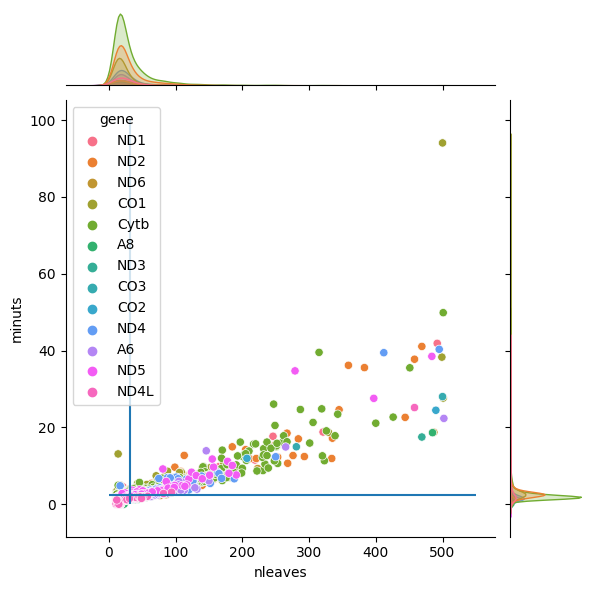

In [11]:
ax = sns.jointplot(df, x='nleaves', y='minuts', hue='gene')
plt.vlines([df.nleaves.mean()], 0, 100);
plt.hlines([df.minuts.mean()], 0, 550);


## Aggregate

In [4]:
paths12 = glob.glob('../data/chordata2/output/*/*/tables/ms12syn.tsv')
paths192 = glob.glob('../data/chordata2/output/*/*/tables/ms192syn.tsv')
paths12_internal = glob.glob('../data/chordata2/output/*/*/tables/ms12syn_internal.tsv')
paths192_internal = glob.glob('../data/chordata2/output/*/*/tables/ms192syn_internal.tsv')

In [4]:
total_data = []
for lbl, paths in zip(['12', '192', '12_internal', '192_internal'],
                      [paths12, paths192, paths12_internal, paths192_internal]):
    data = []
    for p in tqdm.tqdm(paths, 'Species-Gene'):
        gene, species = p.split('/')[5].split('__')
        spectrum = pd.read_csv(p, sep='\t')
        spectrum = spectrum.assign(Species=species, Gene=gene)
        data.append(spectrum)
    df = pd.concat(data)
    total_data.append(df.copy())
    df.to_csv(f'../data/chordata2/raw_spectum{lbl}.csv')

Species-Gene: 100%|██████████| 5925/5925 [00:11<00:00, 508.59it/s]


## Process

In [12]:
total_data = [
    pd.read_csv('../data/chordata2/raw_spectum12.csv', index_col=0),
    pd.read_csv('../data/chordata2/raw_spectum192.csv', index_col=0),
    pd.read_csv('../data/chordata2/raw_spectum12_internal.csv', index_col=0),
    pd.read_csv('../data/chordata2/raw_spectum192_internal.csv', index_col=0),
]

In [13]:
df_info = pd.read_csv('../data/chordata2/info.csv')
df_info['species'] = df_info['species'].str.replace(' ', '_')
df_info

,acc,gene,taxa,species
0,AB478558.1.8820.9502_BAH86124.1,A6,Chordata_7711;Leptocardii_2682552;Amphioxiform...,Branchiostoma_belcheri
1,AB478590.1.8806.9488_BAH86540.1,A6,Chordata_7711;Leptocardii_2682552;Amphioxiform...,Branchiostoma_floridae
2,Y09525.1.238.>921_CAA70712.1,A6,Chordata_7711;Leptocardii_2682552;Amphioxiform...,Branchiostoma_lanceolatum
3,KP722183.1.159.>838_AJV90905.1,A6,Chordata_7711;Hyperoartia_117569;Petromyzontif...,Lampetra_fluviatilis
4,FR669668.2.1432.>2101_CBW30998.1,A6,Chordata_7711;Hyperoartia_117569;Petromyzontif...,Lampetra_planeri
...,...,...,...,...
18932,KY676708.1.1.519_AVM18678.1,ND6,Chordata_7711;Amphibia_8292;Caudata_8293;Pleth...,Eurycea_braggi
18933,KY676695.1.1.519_AVM18665.1,ND6,Chordata_7711;Amphibia_8292;Caudata_8293;Pleth...,Eurycea_spelaea
18934,EU880310.1.14048.13530_ACJ43568.1,ND6,Chordata_7711;Amphibia_8292;Caudata_8293;Salam...,Cynops_ensicauda
18935,EU880313.1.14046.13528_ACJ43607.1,ND6,Chordata_7711;Amphibia_8292;Caudata_8293;Salam...,Cynops_pyrrhogaster


### Calculate class abundance

In [22]:
cab = total_data[0].merge(df_info, right_on=['species', 'gene'], left_on=['Species', 'Gene'])
cab['cls'] = cab.taxa.apply(lambda x: ' '.join(x.split(';')[1].split('_')[:-1]))
abund = cab.drop_duplicates(['species', 'gene']).groupby(['cls', 'gene']).Species.count()\
    .unstack().fillna(0).astype(int).sort_values('Cytb', ascending=False)

In [23]:
abund = abund.append(pd.Series({'Cytb': 33962,
         'CO1': 33506,
         'ND2': 23602,
         'ND4': 14985,
         'ND3': 12754,
         'ND1': 12684,
         'A6': 12543,
         'A8': 12033,
         'CO2': 10931,
         'ND5': 10789,
         'CO3': 10428,
         'ND4L': 10350,
         'ND6': 10300}, name='Total'))

abund.to_csv('../data/supplementary_files/Supplementary_Table_3.csv')

In [24]:
abund

,A6,A8,CO1,CO2,CO3,Cytb,ND1,ND2,ND3,ND4,ND4L,ND5,ND6
cls,,,,,,,,,,,,,
Mammalia,121,70,309,145,142,1123,153,210,97,174,81,155,118
Actinopteri,167,56,334,31,34,1026,76,235,25,68,21,57,40
Lepidosauria,51,21,110,7,8,435,61,425,5,337,5,12,8
Aves,122,23,79,40,44,314,44,718,79,60,14,57,61
Amphibia,14,5,135,8,13,242,63,181,22,52,5,20,12
class Testudines,0,0,3,0,0,40,1,1,1,16,0,2,2
class Crocodylia,1,1,3,1,1,10,1,1,1,1,1,1,1
Hyperoartia,2,1,1,0,0,9,0,1,1,0,0,0,0
Chondrichthyes,5,3,15,1,1,8,1,46,0,5,0,4,1


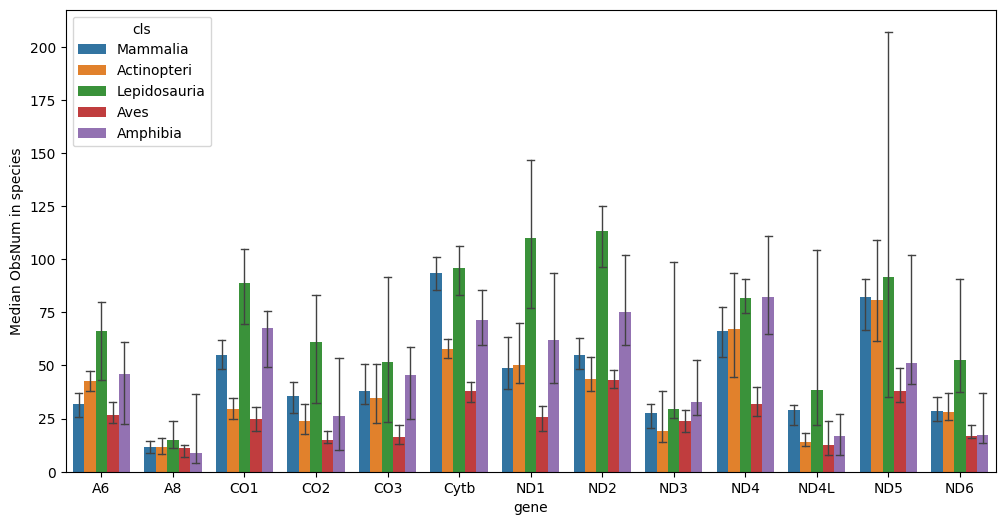

In [31]:
plt.figure(figsize=(12, 6))
sns.barplot(
    data=cab.groupby(['cls', 'gene', 'species']).ObsNum.sum().reset_index(), 
    x='gene', y='ObsNum', hue='cls', 
    hue_order=['Mammalia', 'Actinopteri', 'Lepidosauria', 'Aves', 'Amphibia'],
    capsize=0.1, estimator='median', errwidth=1,
).set_ylabel('Median ObsNum in species');

## Find errors

## Get final tables; find min number of mutations threshold 

In [5]:
total_data[0]

,Mut,ObsNum,ExpNum,MutSpec,Species,Gene
0,A>G,11.97280,30.91470,0.370075,Eleotris_fusca,ND1
1,C>T,4.98631,46.08120,0.103398,Eleotris_fusca,ND1
2,G>A,6.98846,21.08200,0.316758,Eleotris_fusca,ND1
3,T>C,8.98184,40.91500,0.209769,Eleotris_fusca,ND1
4,T>A,0.00000,16.91510,0.000000,Eleotris_fusca,ND1
...,...,...,...,...,...,...
7,T>C,2.99998,40.79990,0.026493,Branchiostoma_belcheri,ND4L
8,T>G,3.99994,10.90000,0.132223,Branchiostoma_belcheri,ND4L
9,G>T,0.00000,4.69996,0.000000,Branchiostoma_belcheri,ND4L
10,A>C,0.00000,12.90000,0.000000,Branchiostoma_belcheri,ND4L


<AxesSubplot:>

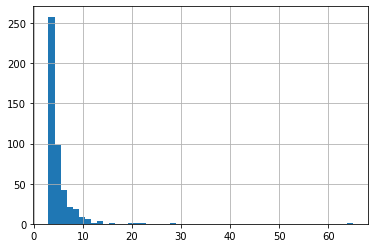

In [42]:
a = (total_data[0].ObsNum / total_data[0].ExpNum)
a[a > 3].hist(bins=50)

In [62]:
tr_space = np.linspace(0, 5, 100)
dlen = [total_data[0][(total_data[0].ExpNum.between(0, tr, 'right')) & (total_data[0].ObsNum.between(0, tr, 'right'))].shape[0] for tr in tr_space]

In [86]:
tr = 0.99
total_data[0][(total_data[0].ExpNum.between(0, tr, 'right')) & (total_data[0].ObsNum.between(0, tr, 'right'))] #& (~(total_data[0].ObsNum / total_data[0].ExpNum).fillna(0).between(0.8, 1.2))]

,Mut,ObsNum,ExpNum,MutSpec,Species,Gene
4,G>C,0.984329,0.532810,0.293537,Podarcis_lilfordi,ND2
6,G>T,0.981711,0.943558,0.099573,Pedioplanis_burchelli,ND2
6,G>T,0.808355,0.537496,0.197909,Didemnum_granulatum,CO1
4,G>A,0.899284,0.872553,0.368168,Crotaphytus_nebrius,Cytb
7,G>C,0.567060,0.320491,0.394275,Reithrodontomys_chrysopsis,Cytb
5,G>A,0.973297,0.571058,0.592833,Dipodomys_agilis,Cytb
6,G>T,0.800593,0.911391,0.123866,Misgurnus_anguillicaudatus,A8
4,G>T,0.984943,0.317911,0.396533,Phrynosoma_orbiculare,A8
2,G>A,0.966622,0.305126,0.656641,Dicrostonyx_torquatus,A8
1,C>A,0.317641,0.022745,0.694539,Pituophis_deppei,A8


In [91]:
total_data[0][(total_data[0].ExpNum.between(0.99, 1, 'right')) | (total_data[0].ObsNum.between(0.99, 1, 'right'))] 

,Mut,ObsNum,ExpNum,MutSpec,Species,Gene
3,C>G,1.00000,23.59860,0.012763,Anaxyrus_fowleri,ND1
1,A>T,1.00000,80.26720,0.011597,Anaxyrus_woodhousii,ND1
5,G>C,1.00000,6.67245,0.139505,Anaxyrus_woodhousii,ND1
2,A>T,1.00000,22.64750,0.021682,Corvus_corax,ND1
8,T>G,0.99997,21.06580,0.010808,Lasiopodomys_gregalis,ND1
...,...,...,...,...,...,...
1,C>A,1.00000,13.99980,0.103928,Macrhybopsis_aestivalis,ND4L
5,T>G,1.00000,8.98997,0.161843,Macrhybopsis_aestivalis,ND4L
2,C>A,0.99998,2.50000,0.144122,Branchiostoma_belcheri,ND4L
5,G>C,0.99995,4.69996,0.076659,Branchiostoma_belcheri,ND4L


In [93]:
get_cossim(
    total_data[0].pivot(['Gene', 'Species'], 'Mut', 'MutSpec'), 
    total_data[2].pivot(['Gene', 'Species'], 'Mut', 'MutSpec'),
).quantile([.25, .5, .75])

0.25    0.940835
0.50    0.981491
0.75    0.993853
dtype: float64

In [95]:
tr = 0.99
get_cossim(
    total_data[0][(total_data[0].ExpNum > tr) & (total_data[0].ObsNum > tr)].pivot(['Gene', 'Species'], 'Mut', 'MutSpec'), 
    total_data[2][(total_data[2].ExpNum > tr) & (total_data[2].ObsNum > tr)].pivot(['Gene', 'Species'], 'Mut', 'MutSpec'),
).quantile([.25, .5, .75])

0.25    0.937508
0.50    0.981007
0.75    0.993736
dtype: float64

In [96]:
tr = 0.99
get_cossim(
    total_data[0].pivot(['Gene', 'Species'], 'Mut', 'MutSpec'), 
    total_data[0][(total_data[0].ExpNum >= tr) & (total_data[0].ObsNum >= tr)].pivot(['Gene', 'Species'], 'Mut', 'MutSpec'),
).quantile([.05, .5])

0.05    0.988551
0.50    1.000000
dtype: float64

## Calculate Expected Mutspec with conservative sites for CytB

### Derive exp full

In [4]:
paths_msa = glob.glob('/home/kpotoh/nemu-pipeline/data/chordata2/output/*/*/msa_nuc.fasta') 
len(paths_msa)

9252

In [5]:
coda = CodonAnnotation(gencode=2)

In [6]:
def my_process_parallel(seq: str):
    exp12, exp192 = coda.collect_exp_mut_freqs(seq, labels=['syn'])
    return exp12['syn'], exp192['syn']

In [8]:
msa = [str(r.seq) for r in list(SeqIO.parse(paths_msa[10], 'fasta')) if r.id != 'OUTGRP']
my_process_parallel(msa[0])


p = Pool(64)
_ = p.map(my_process_parallel, msa)

In [9]:
data = dict()
list_of_species = list()

i = 0
for path_fasta in tqdm.tqdm(paths_msa):
    i += 1
    p_elements = path_fasta.split('/')
    
    gene_species = p_elements[8]
    list_of_species.append(gene_species)

    msa = [str(r.seq) for r in list(SeqIO.parse(path_fasta, 'fasta')) if r.id != 'OUTGRP']
    raw = p.map(my_process_parallel, msa)

    raw_exp12  = [x[0] for x in raw]
    raw_exp192 = [x[1] for x in raw]

    nseqs = len(msa)
    mean_exp = defaultdict(int)
    for sbs in possible_sbs192:
        for rex in raw_exp192:
            mean_exp[sbs] += rex.get(sbs, 0) / nseqs
    for sbs in possible_sbs12:
        for rex in raw_exp12:
            mean_exp[sbs] += rex.get(sbs, 0) / nseqs
        
    data[gene_species] = mean_exp

exp_final_df = pd.DataFrame(data).T

  0%|          | 6/9252 [00:00<02:43, 56.66it/s]

100%|██████████| 9252/9252 [02:06<00:00, 72.99it/s] 


### QC of exp

In [10]:
exp_final_df.index.name == 'gene__species'
exp_final_df.size

1887408

In [25]:
exp_final_df.to_csv('../data/chordata2/exp_num_raw.csv')

In [12]:
# number and share of useless values: (0, 0.9] - 10%
nuseless = ((exp_final_df > 0) & (exp_final_df <= 0.9)).sum().sum()
nuseless, (nuseless / exp_final_df.size).round(4)

(188620, 0.0999)

In [21]:
(exp_final_df > 0.9).sum().value_counts().sort_index()

0       32
1818     2
1879     2
2526     1
2560     3
        ..
9211     1
9227     2
9239     1
9249     2
9252     5
Length: 102, dtype: int64

In [23]:
(exp_final_df > 0.9).sum().sum()

1207264

In [26]:
(pd.read_csv('../data/chordata2/exp_num_raw.csv', index_col=0) > 0.9).sum().sum()

1207264

In [27]:
exp_final_df = exp_final_df[(exp_final_df > 0.9)]

In [30]:
# 12-comp exps are good
(exp_final_df[possible_sbs12] > 0).sum(axis=1).sort_values()

A8__Henicorhina_leucophrys          8
ND3__Erythropitta_erythrogaster     9
ND3__Sus_scrofa                     9
A8__Calothorax_lucifer              9
CO3__Peromyscus_fraterculus         9
                                   ..
CO1__Coryphopterus_thrix           12
CO1__Vipera_ursinii                12
CO1__Austrolebias_nachtigalli      12
CO1__Cottus_gulosus                12
ND4L__Branchiostoma_belcheri       12
Length: 9252, dtype: int64

In [32]:
# 192-comp exps are normal
(exp_final_df[possible_sbs192] > 0).sum(axis=1).sort_values()

A8__Crotalus_triseriatus          12
A8__Artamus_superciliosus         21
A8__Hydrophis_elegans             24
A8__Potamotrygon_motoro           25
A8__Tor_khudree                   26
                                ... 
ND4__Rhinichthys_cataractae      157
ND5__Felis_silvestris            158
ND5__Felis_catus                 158
ND5__Phyllopteryx_taeniolatus    159
ND5__Boreogadus_saida            160
Length: 9252, dtype: int64

In [33]:
exp_final_df.to_csv('../data/chordata2/exp_num.csv')

### Use cytb exp full

In [14]:
exp_final_df = pd.read_csv('../data/chordata2/exp_num.csv', index_col=0)
exp_final_df = exp_final_df[exp_final_df.index.str.startswith('Cytb__')]
exp_final_df.index = exp_final_df.index.str.slice(6)
# exp_final_df12 = exp_final_df[possible_sbs12].fillna(0.)
exp_final_df = exp_final_df[possible_sbs192].fillna(0.)
exp_final_df.head(2)

,A[A>C]A,A[A>C]C,A[A>C]G,A[A>C]T,C[A>C]A,C[A>C]C,C[A>C]G,C[A>C]T,G[A>C]A,G[A>C]C,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
Aulacorhynchus_haematopygus,0.0,0.0,0.0,0.0,8.300000,4.300000,8.500000,8.6,2.800000,1.90000,...,3.000000,0.000000,0.0,0.0,1.800000,1.000000,1.000000,1.500000,1.400000,1.8
Tarsius_dentatus,0.0,0.0,0.0,0.0,11.571429,10.380952,10.142857,13.0,3.857143,3.47619,...,8.333333,4.142857,1.0,0.0,1.190476,1.428571,3.047619,2.857143,2.142857,0.0


### Species-specific compare: obs, exp and spectum

In [15]:
exp_freqs_new_full = exp_final_df[possible_sbs192]

obs_freqs_new = total_data[1].pivot(['Gene', 'Species'], 'Mut', 'ObsNum').loc['Cytb', possible_sbs192]
exp_freqs_new_excons = total_data[1].pivot(['Gene', 'Species'], 'Mut', 'ExpNum').loc['Cytb', possible_sbs192]

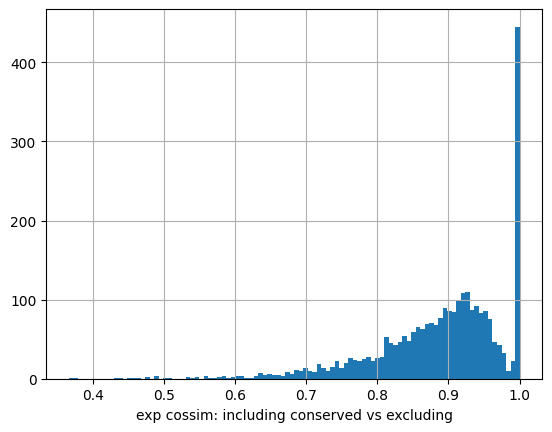

In [16]:
plt.xlabel('exp cossim: including conserved vs excluding')
get_cossim(exp_freqs_new_excons, exp_freqs_new_full).hist(bins=100);

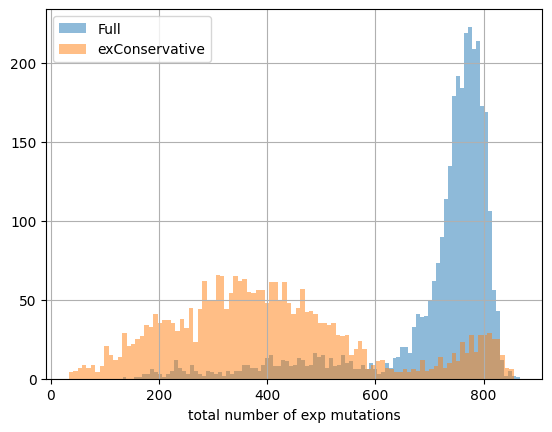

In [17]:
exp_freqs_new_full.sum(axis=1).hist(bins=100, alpha=0.5, label='Full')
exp_freqs_new_excons.sum(axis=1).hist(bins=100, alpha=0.5, label='exConservative')
plt.xlabel('total number of exp mutations')
plt.legend();

## Compare with old dataset 

In [122]:
old_dataset = pd.read_csv('../../192/data/MutSpecVertebratescytb.csv')
old_dataset['Mut'] = old_dataset['Mut'].apply(rev_comp)
old_dataset.head()

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,A[A>C]A,0.0,0.0,0.0,1.088889,0.0,T>G,TTT,Actinopterygii
1,Abbottina_obtusirostris,A[A>C]C,0.0,0.0,0.0,1.088889,0.0,T>G,GTT,Actinopterygii
2,Abbottina_obtusirostris,A[A>C]G,0.0,0.0,0.0,1.088889,0.0,T>G,CTT,Actinopterygii
3,Abbottina_obtusirostris,A[A>C]T,0.0,0.0,0.0,1.088889,0.0,T>G,ATT,Actinopterygii
4,Abbottina_obtusirostris,A[A>G]A,8.0,0.0,0.0,1.088889,0.0,T>C,TTT,Actinopterygii


In [123]:
obs_freqs_old = old_dataset.pivot('Species', 'Mut', 'Observed')[possible_sbs192]
exp_freqs_old = old_dataset.pivot('Species', 'Mut', 'Expected')[possible_sbs192]

In [126]:
thr_obs = 0.9
thr_exp = 0.9

# obs_freqs_old_filtered = obs_freqs_old[obs_freqs_old > thr].fillna(0.) # useless, there are no proba...
# exp_freqs_old_filtered = exp_freqs_old[exp_freqs_old > thr].fillna(0.)
obs_freqs_new_filtered = obs_freqs_new[obs_freqs_new > thr_obs].fillna(0.)
exp_freqs_new_full_filtered = exp_freqs_new_full[exp_freqs_new_full > thr_exp].fillna(0.)
exp_freqs_new_excons_filtered = exp_freqs_new_excons[exp_freqs_new_excons > thr_exp].fillna(0.)

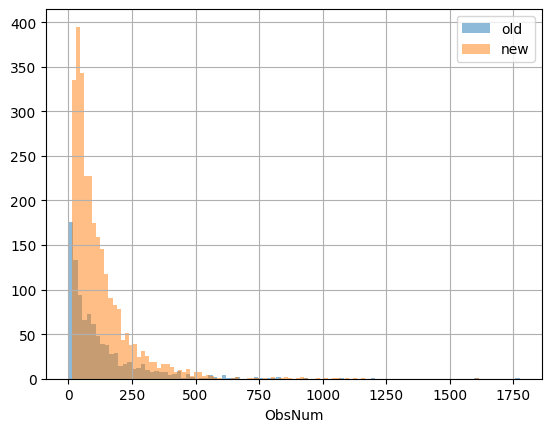

In [127]:
obs_freqs_old.sum(axis=1).hist(bins=100, label='old', alpha=0.5)
obs_freqs_new.sum(axis=1).hist(bins=100, label='new', alpha=0.5)
plt.xlabel('ObsNum')
plt.legend();

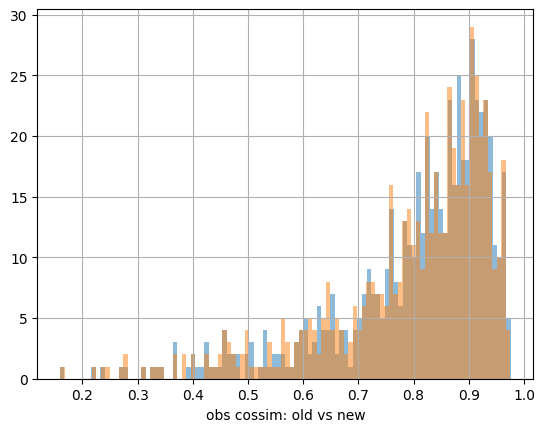

In [12]:
get_cossim(obs_freqs_new, obs_freqs_old).hist(bins=100, alpha=0.5)
get_cossim(obs_freqs_new_filtered, obs_freqs_old).hist(bins=100, alpha=0.5)
plt.xlabel('obs cossim: old vs new');

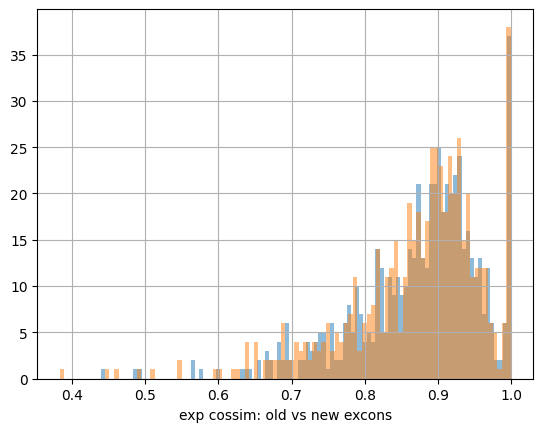

In [13]:
get_cossim(exp_freqs_new_excons, exp_freqs_old).hist(bins=100, alpha=0.5)
get_cossim(exp_freqs_new_excons_filtered, exp_freqs_old).hist(bins=100, alpha=0.5)
plt.xlabel('exp cossim: old vs new excons');

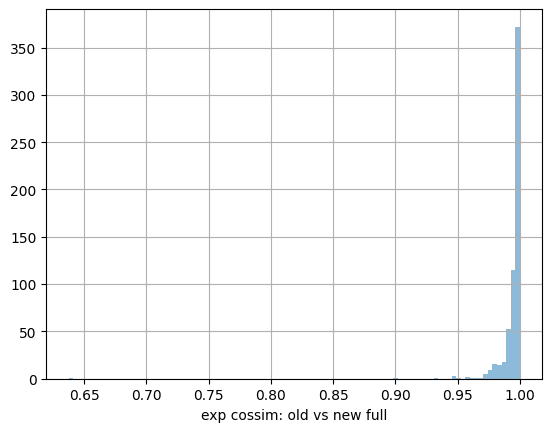

In [14]:
get_cossim(exp_freqs_new_full, exp_freqs_old).hist(bins=100, alpha=0.5)
plt.xlabel('exp cossim: old vs new full');

In [128]:
spectrum_old = (obs_freqs_old / exp_freqs_old).fillna(0.).replace(np.inf, 0.)

spectrum_new_full = (obs_freqs_new / exp_freqs_new_full).fillna(0.).replace(np.inf, 0.)
spectrum_new_excons = (obs_freqs_new / exp_freqs_new_excons).fillna(0.).replace(np.inf, 0.)

spectrum_new_full_filtered   = (obs_freqs_new_filtered / exp_freqs_new_full_filtered).fillna(0.).replace(np.inf, 0.)
spectrum_new_excons_filtered = (obs_freqs_new_filtered / exp_freqs_new_excons_filtered).fillna(0.).replace(np.inf, 0.)

### Cossims

<AxesSubplot:>

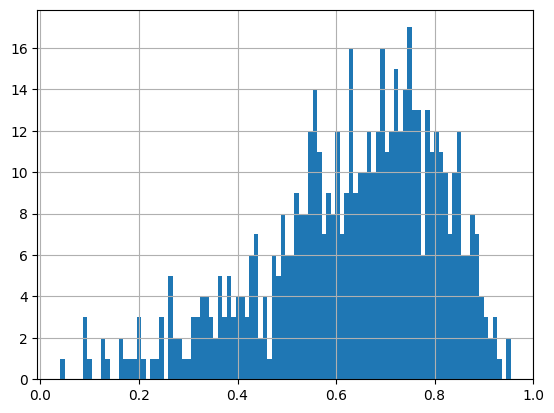

In [129]:
get_cossim(spectrum_old, spectrum_new_full).hist(bins=100)

0.6169111183164705


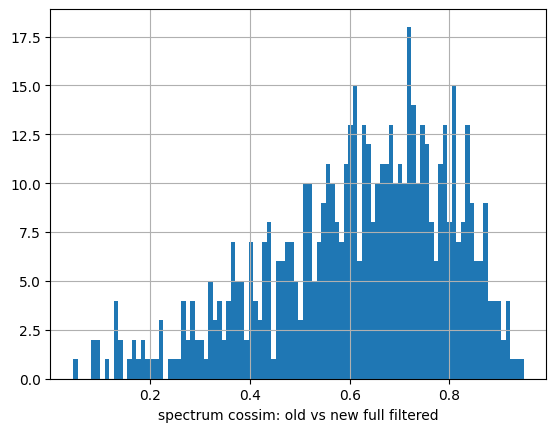

In [17]:
a = get_cossim(spectrum_old, spectrum_new_full_filtered)
print(a.mean())
a.hist(bins=100)
plt.xlabel('spectrum cossim: old vs new full filtered');

<AxesSubplot:>

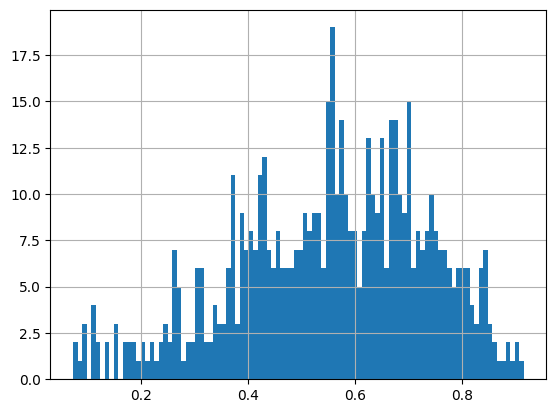

In [18]:
get_cossim(spectrum_old, spectrum_new_excons_filtered).hist(bins=100)

### Need to compare only values of sbs, that was observed in old dataset!
old dataset has more zeroes, therefore when calculating cossim, huge difference raised from zeroes,
that are not zeroes in the new dataset

In [96]:
from scipy.spatial.distance import cosine
cosine([1,2,3,4], [1,0,3,4])

0.06905066374873725

In [19]:
species = obs_freqs_old.index.intersection(obs_freqs_new.index)


obs_freqs_new_filtered_as_in_old = obs_freqs_new_filtered.loc[species][obs_freqs_old.loc[species] > 0].fillna(0.)

spectrum_new_full_filtered_as_in_old = (obs_freqs_new_filtered_as_in_old / exp_freqs_new_full_filtered)\
                                            .fillna(0.).replace(np.inf, 0.)

0.6640302629311805


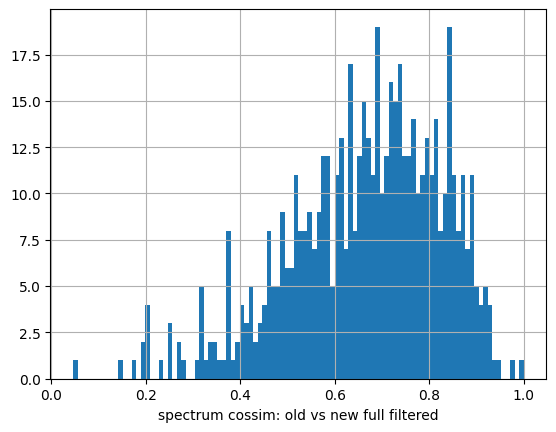

In [20]:
a = get_cossim(spectrum_old, spectrum_new_full_filtered_as_in_old)
print(a.mean())
a[a>0].hist(bins=100)
plt.xlabel('spectrum cossim: old vs new full filtered');

0.9012186784038454


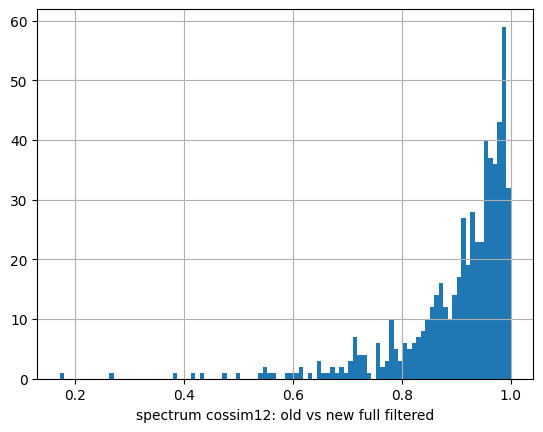

In [26]:
# 12-comp
a = get_cossim(
    collapse_sbs192(spectrum_old), 
    collapse_sbs192(spectrum_new_full_filtered_as_in_old))
print(a.mean())
a[a>0].hist(bins=100)
plt.xlabel('spectrum cossim12: old vs new full filtered');

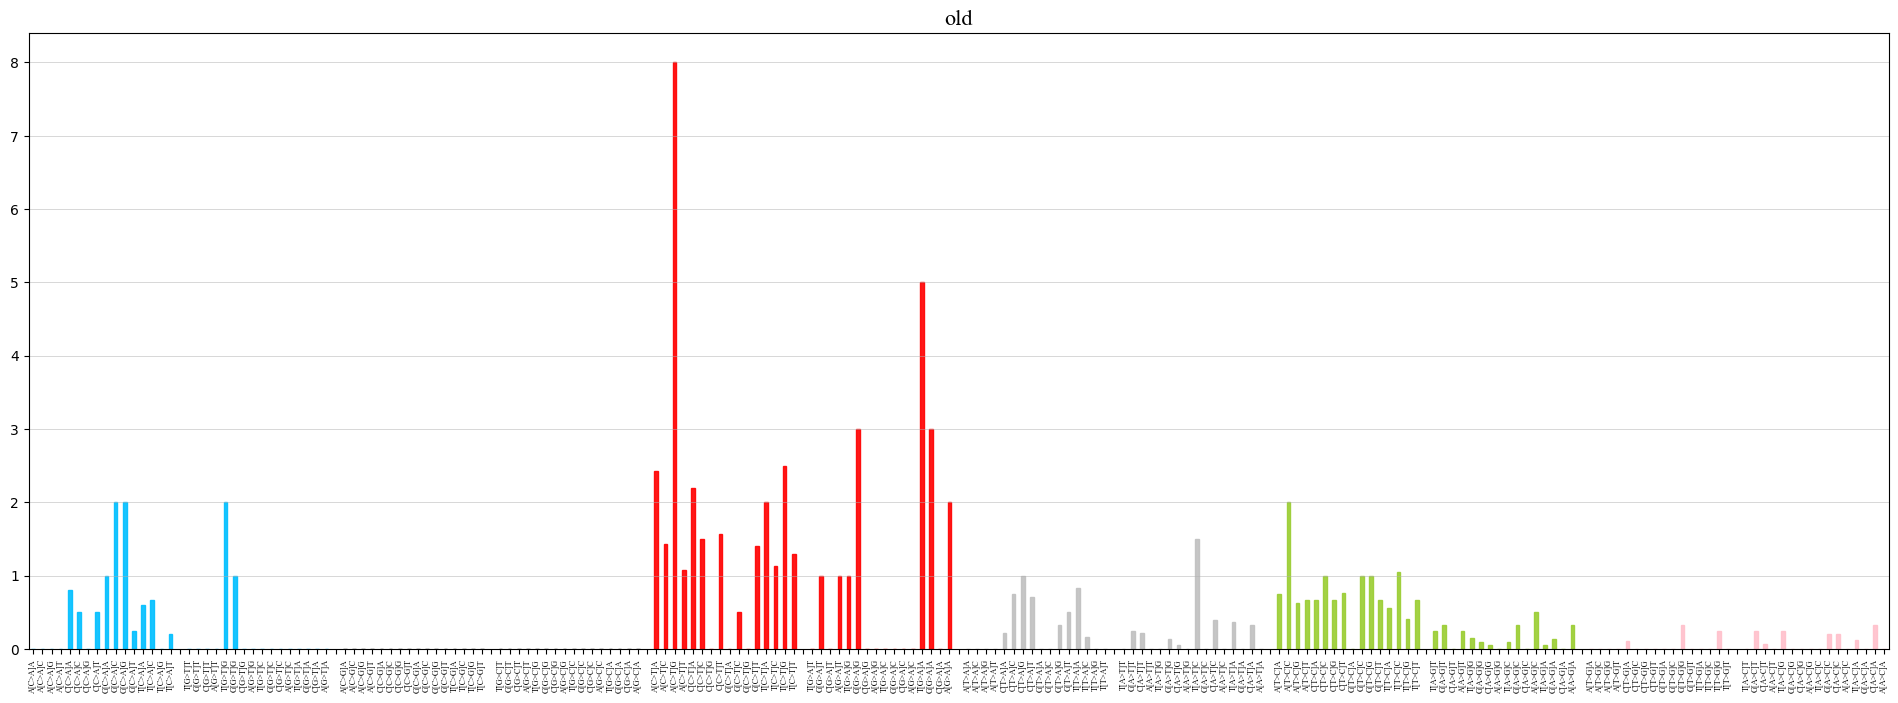

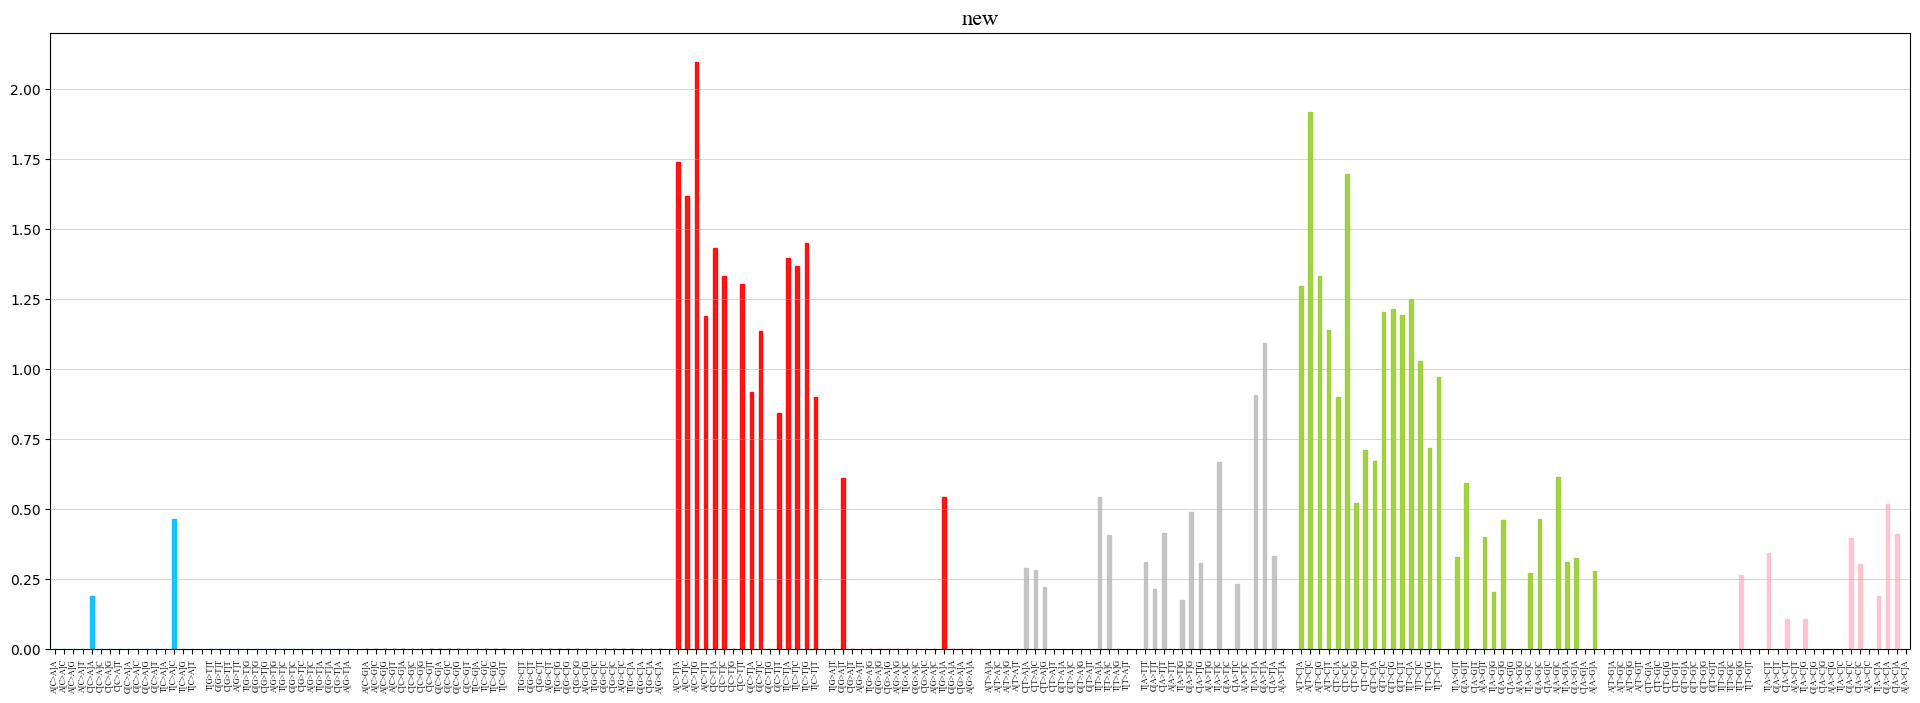

In [186]:
o = spectrum_old.sample()
if o.index.values.item() in spectrum_new_full_filtered.index:
    n = spectrum_new_full_filtered.loc[o.index.values.item()]
    plot_mutspec192(o.iloc[0].to_frame('MutSpec').reset_index(), title='old');
    plot_mutspec192(n.to_frame('MutSpec').reset_index(), title='new');
else:
    print('again')

### Plot barplot of mean spectrum

In [130]:
def scale_spectrum(df):
    return (df.T / df.sum(axis=1)).T

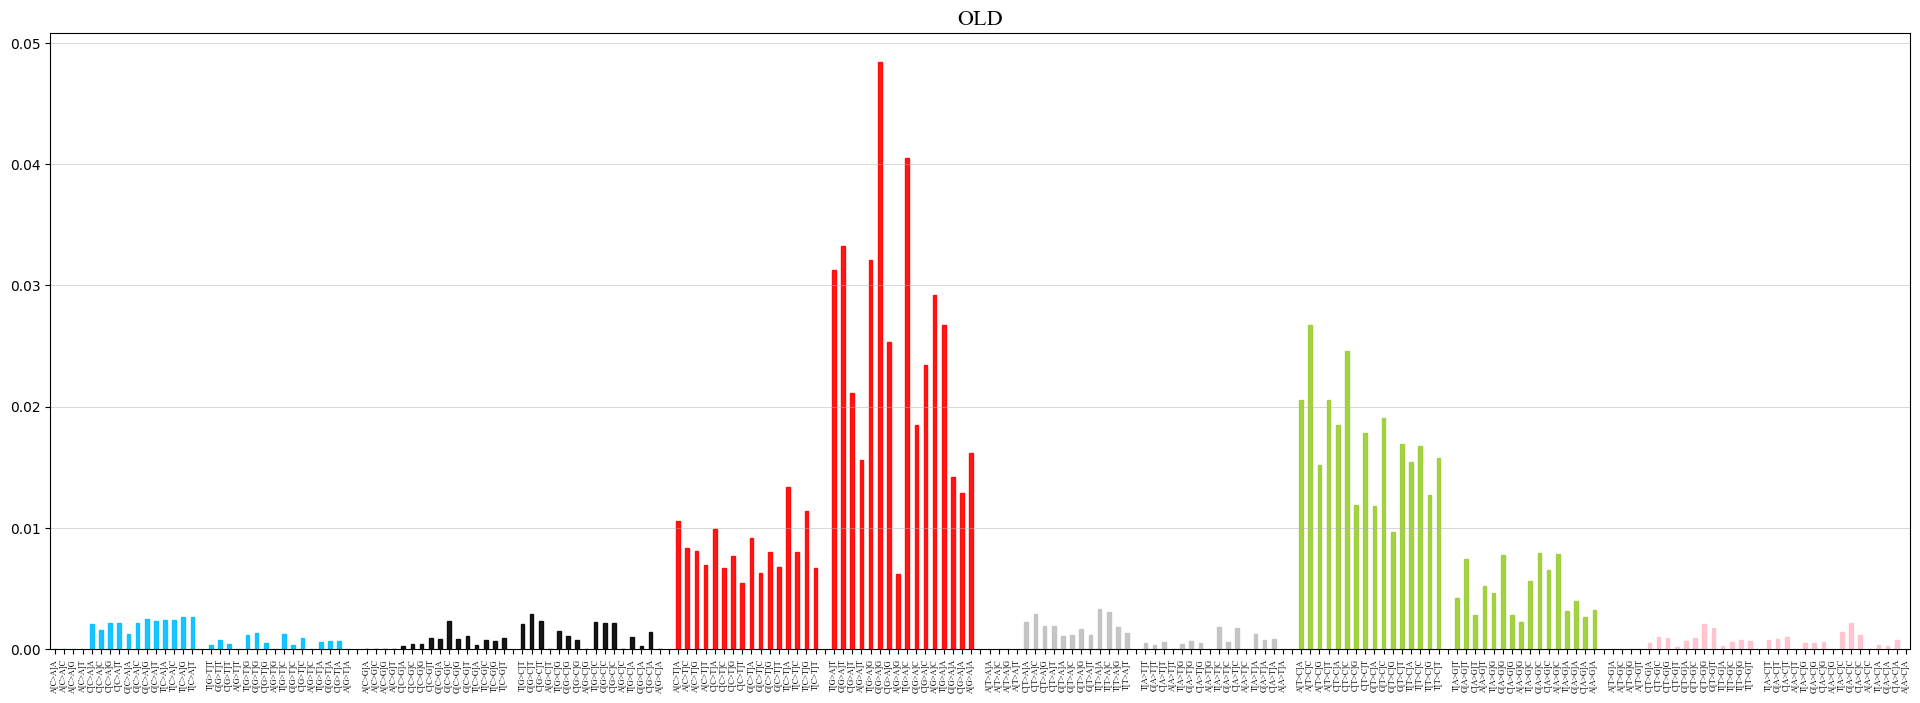

In [131]:
plot_mutspec192(scale_spectrum(spectrum_old).mean(axis=0).rename('MutSpec').to_frame().reset_index(), title='OLD');

In [132]:
species = spectrum_old.index.intersection(spectrum_new_full.index).intersection(spectrum_new_excons.index)

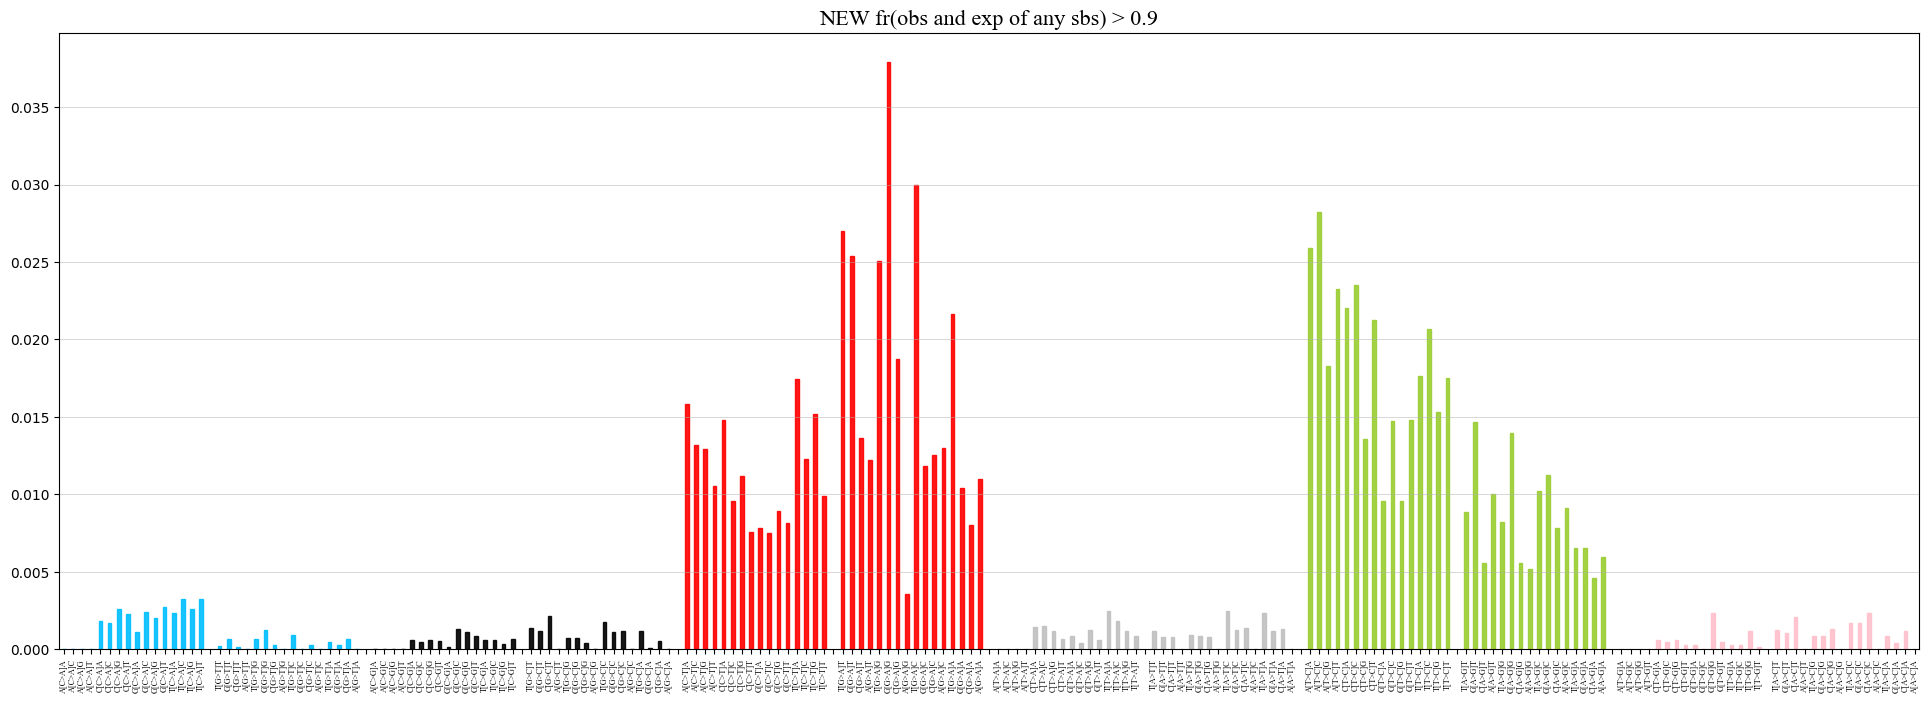

In [133]:
plot_mutspec192(scale_spectrum(spectrum_new_full_filtered.loc[species])\
                    .mean(axis=0).rename('MutSpec').to_frame().reset_index(), title='NEW fr(obs and exp of any sbs) > 0.9');

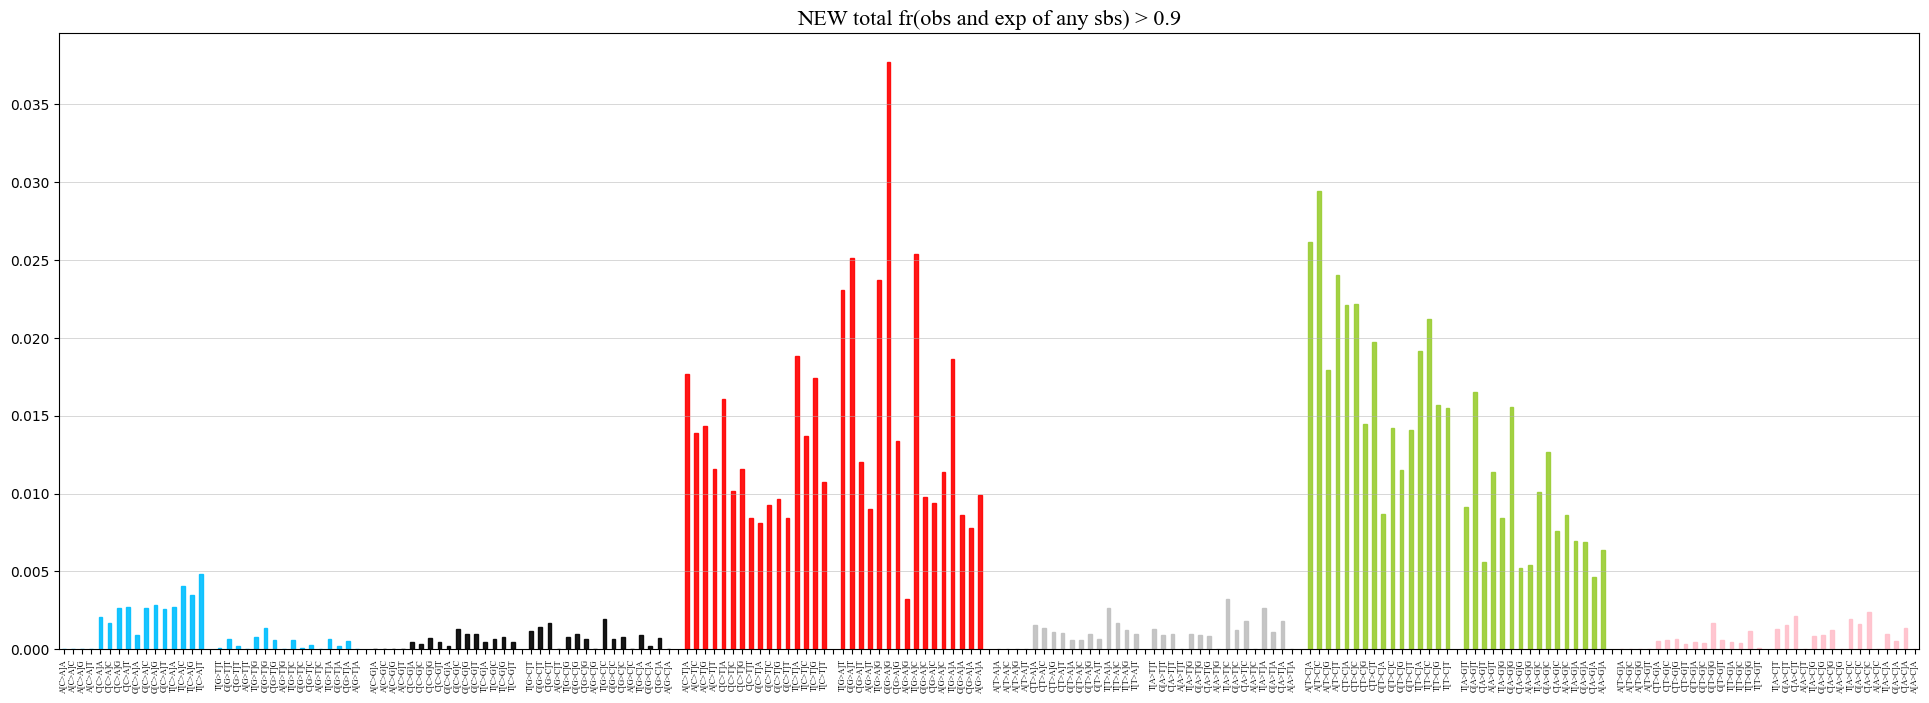

In [134]:
plot_mutspec192(scale_spectrum(spectrum_new_full_filtered)\
                    .mean(axis=0).rename('MutSpec').to_frame().reset_index(), title='NEW total fr(obs and exp of any sbs) > 0.9');

In [ ]:
plot_mutspec192(scale_spectrum(spectrum_new_full.loc[species])\
                    .mean(axis=0).rename('MutSpec').to_frame().reset_index(), title='NEW');

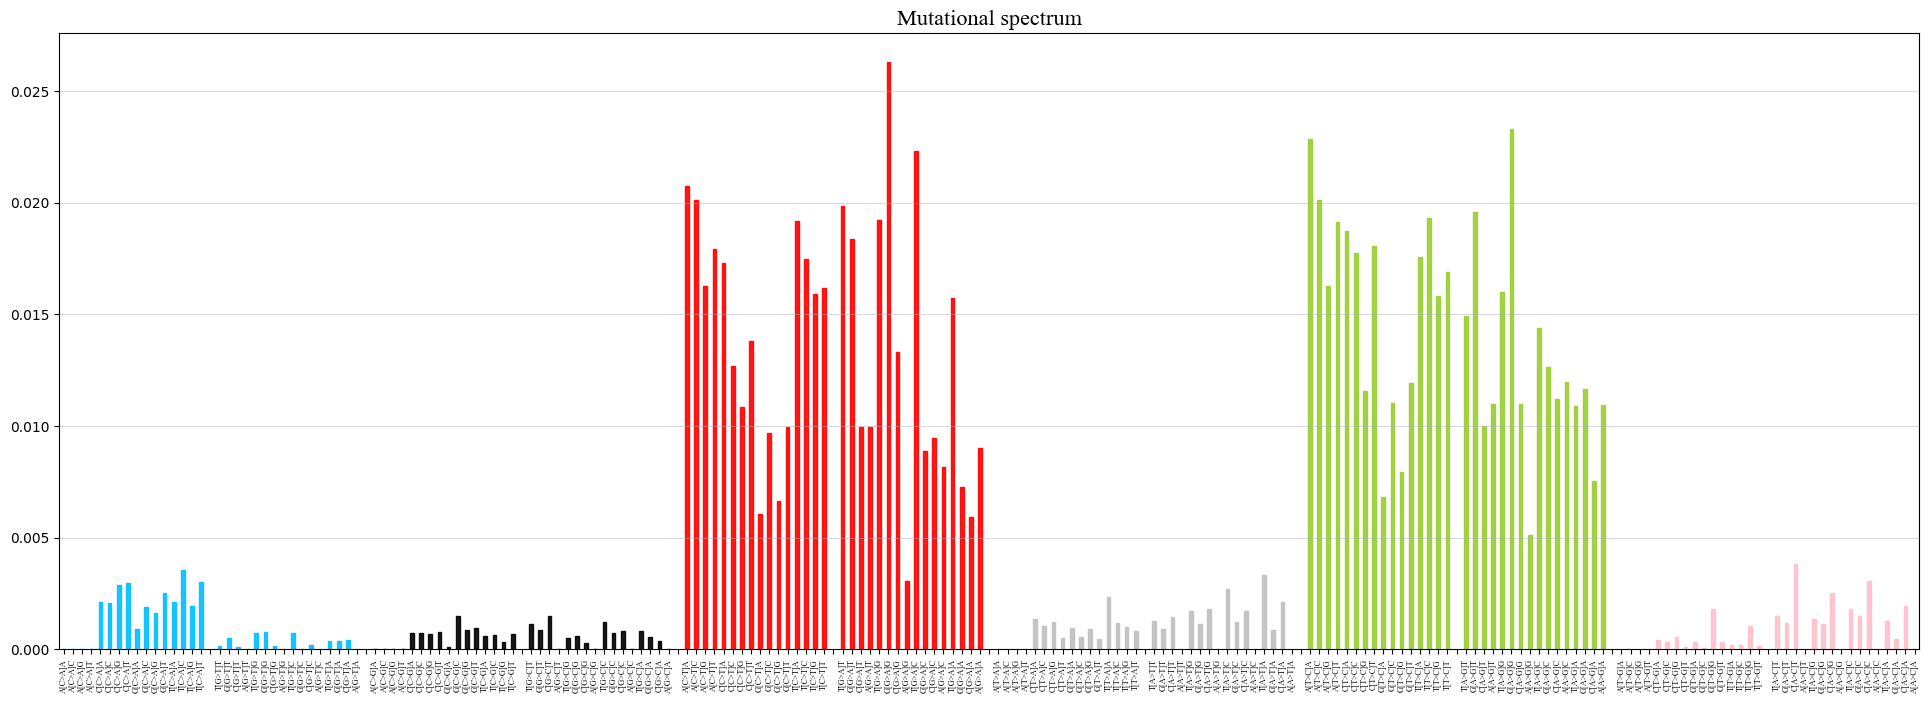

In [94]:
plot_mutspec192(scale_spectrum(spectrum_new_excons_filtered.loc[species])\
                    .mean(axis=0).rename('MutSpec').to_frame().reset_index());

## Save final tables

### save

In [18]:
exp = pd.read_csv('../data/chordata2/exp_num.csv', index_col=0)

In [31]:
exp.head(2)

,A[A>C]A,A[A>C]C,A[A>C]G,A[A>C]T,C[A>C]A,C[A>C]C,C[A>C]G,C[A>C]T,G[A>C]A,G[A>C]C,...,A>T,C>A,C>G,C>T,G>A,G>C,G>T,T>A,T>C,T>G
ND1__Eleotris_fusca,NaN,NaN,NaN,NaN,14.076923,8.461538,13.000000,6.769231,2.000000,NaN,...,82.230769,58.230769,58.230769,137.923077,24.307692,15.384615,15.384615,23.076923,61.461538,23.076923
ND1__Lasiurus_blossevillii,NaN,NaN,NaN,NaN,7.909091,9.636364,6.090909,10.272727,1.909091,NaN,...,72.090909,35.909091,35.909091,93.909091,22.727273,9.000000,9.000000,29.000000,93.181818,29.000000


In [38]:
total_data[0]['gene__species'] = total_data[0].Gene + '__' + total_data[0].Species
total_data[1]['gene__species'] = total_data[1].Gene + '__' + total_data[1].Species

In [ ]:
obs_freqs_new = total_data[1].pivot(['Gene', 'Species'], 'Mut', 'ObsNum').loc['Cytb', possible_sbs192]

In [39]:
obs12  = total_data[0].pivot('gene__species', 'Mut', 'ObsNum')[possible_sbs12]
obs192 = total_data[1].pivot('gene__species', 'Mut', 'ObsNum')[possible_sbs192]

In [46]:
((obs12 > 0) & (obs12 <= 0.9)).sum().sum(), ((obs12 > 0) & (obs12 <= 0.9)).sum().sum()/obs12.size

(2931, 0.026456889081455805)

In [45]:
((obs192 > 0) & (obs192 <= 0.9)).sum().sum(), ((obs192 > 0) & (obs192 <= 0.9)).sum().sum()/obs192.size

(47003, 0.03273700075777837)

In [49]:
obs12[obs12 > 0.9].to_csv('../data/chordata2/obs_num12.csv')
obs192[obs192 > 0.9].to_csv('../data/chordata2/obs_num192.csv')

In [61]:
obs12[obs12 > 0.9].shape, exp.shape

((9232, 12), (9252, 204))

In [112]:
def scale_spectrum(df):
    return (df.T / df.sum(axis=1)).T

In [143]:
idx12 = obs12.index.intersection(exp.index)

a = obs12[obs12 > 0.9].loc[idx12]
b = exp.loc[idx12, possible_sbs12]

assert (a.index == b.index).all()
assert (obs12[obs12 > 0.9].columns == possible_sbs12).all()
sp12 = a / b
sp12 = sp12[((sp12 > 0).sum(axis=1) >= 4)]
sp12 = scale_spectrum(sp12)
sp12.to_csv('../data/chordata2/spectra12.csv')

In [144]:
idx192 = obs192.index.intersection(exp.index)

a = obs192[obs192 > 0.9].loc[idx192]
b = exp.loc[idx192, possible_sbs192]

assert (a.index == b.index).all()
assert (obs192[obs192 > 0.9].columns == possible_sbs192).all()
sp192 = a / b
sp192 = sp192[((sp192 > 0).sum(axis=1) >= 16)]
sp192 = scale_spectrum(sp192)
sp192.to_csv('../data/chordata2/spectra192.csv')

<AxesSubplot:>

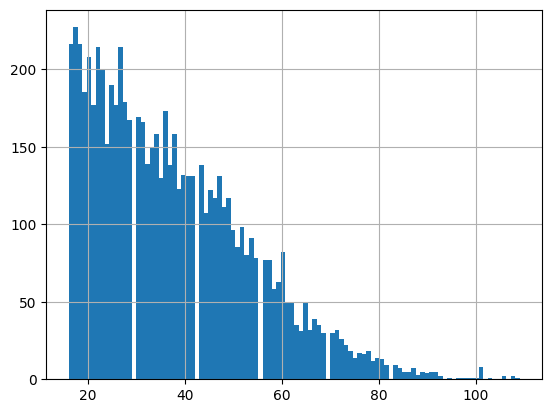

In [115]:
(sp192 > 0).sum(axis=1).hist(bins=100)

### Spectrum QC

In [3]:
sp12 = pd.read_csv('../data/chordata2/spectra12.csv', index_col=0).fillna(0.)
sp192 = pd.read_csv('../data/chordata2/spectra192.csv', index_col=0).fillna(0.)
sp12.columns.rename('Mut', inplace=True)
sp192.columns.rename('Mut', inplace=True)

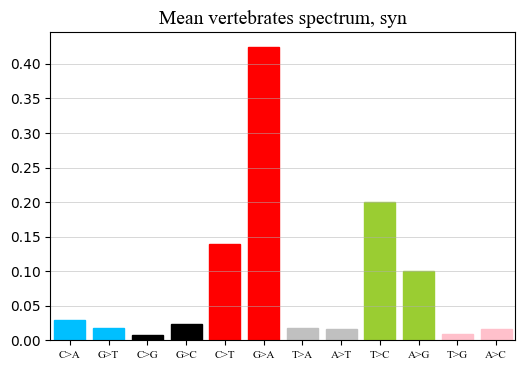

In [4]:
plot_mutspec12(sp12.mean(axis=0).rename('MutSpec').reset_index(), title='Mean vertebrates spectrum, syn');

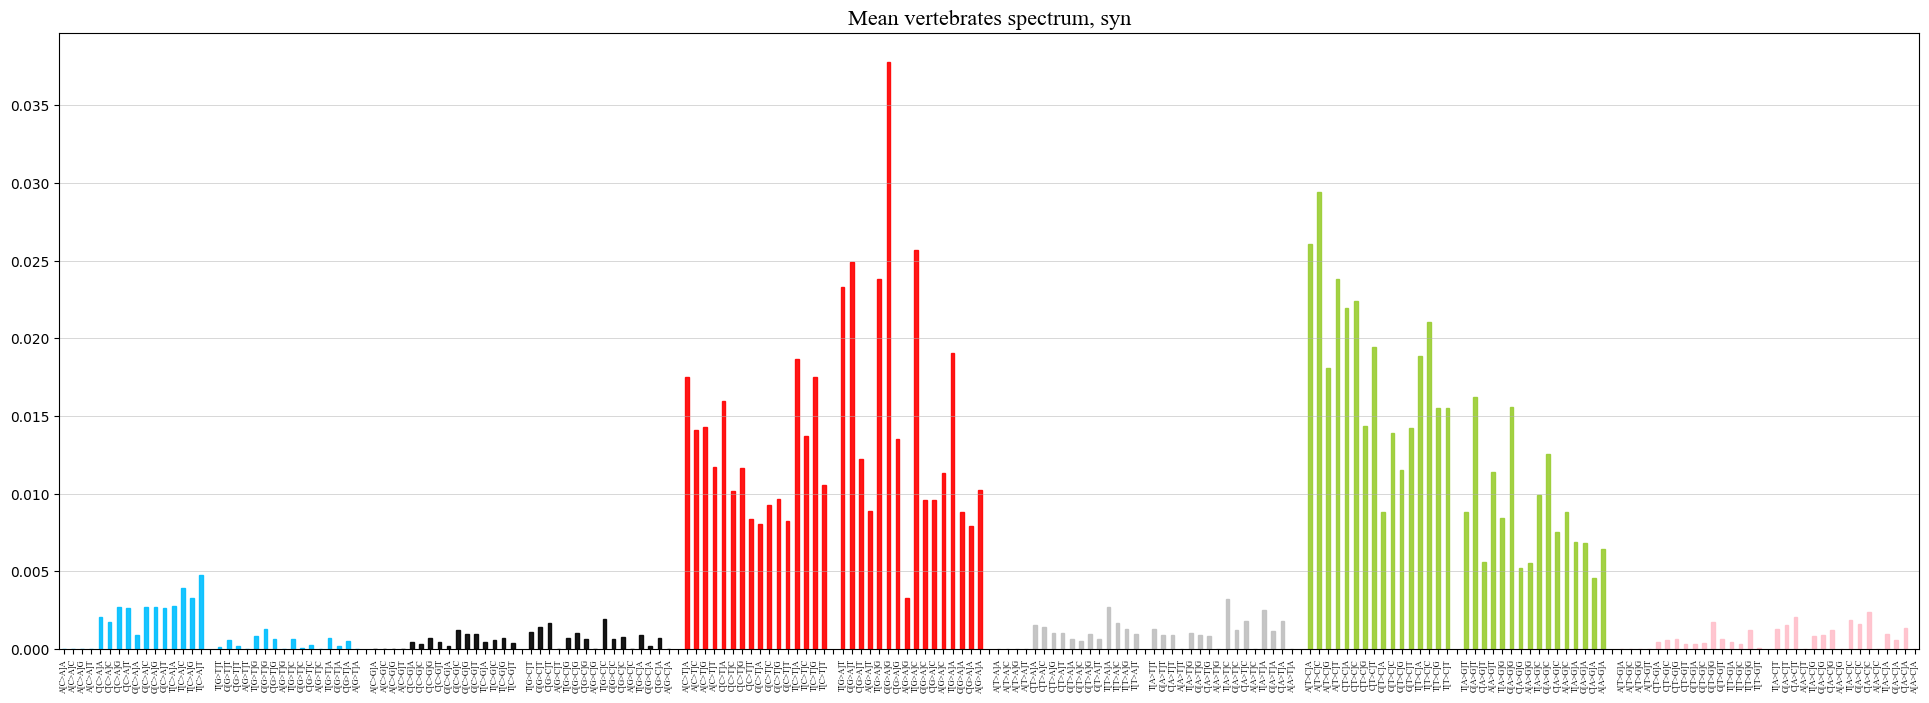

In [5]:
plot_mutspec192(sp192[sp192.index.str.startswith('Cytb')].fillna(0.).mean(axis=0).rename('MutSpec').reset_index(), title='Mean vertebrates spectrum, syn');

### PCA

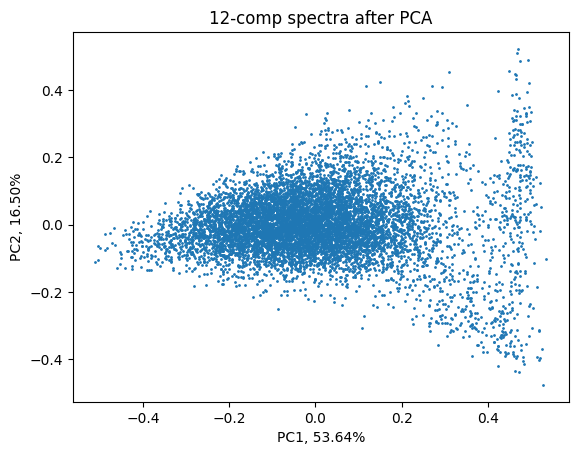

In [6]:
import pandas as pd
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

X = sp12.fillna(0.)
n_components = 2  # Specify the number of dimensions you want to reduce to
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

# Plot the reduced dimensions
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=1)  # Modify according to your number of components
plt.xlabel(f'PC1, {pca.explained_variance_ratio_[0]*100:.2f}%')
plt.ylabel(f'PC2, {pca.explained_variance_ratio_[1]*100:.2f}%')
plt.title('12-comp spectra after PCA')
plt.show()

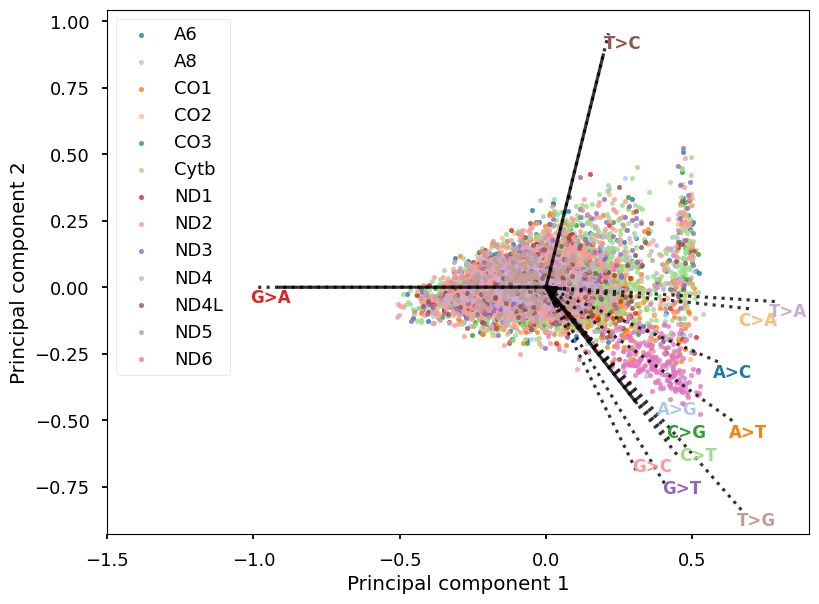

In [143]:
from sklearn.datasets import load_breast_cancer
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from psynlig import pca_2d_scores, pca_2d_loadings
plt.style.use('seaborn-talk')

X = sp12.fillna(0.)
xvars = X.columns.values

labels = X.index.to_series().apply(lambda x: x.split('__')[0]).astype('category')
class_data = labels.cat.codes.values
class_names = {i:s for i,s in enumerate(labels.cat.categories)}

pca = PCA(2)
scores = pca.fit_transform(X)

loading_settings = {
    'adjust_text': True,
    'add_text': True,
    # 'jiggle_text': True,
}

figs, axes = pca_2d_scores(
    pca,
    scores,
    xvars=xvars,
    class_data=class_data,
    class_names=class_names,
    select_components={(1, 2)},
    loading_settings=loading_settings,
    s=10,
    alpha=.8,
    # cmap_class='Dark2',
)
figs[0].set_size_inches(8, 6)
axes[0].set_xlim(-1.5, 0.9)
# plt.legend(loc='upper left')
plt.show()

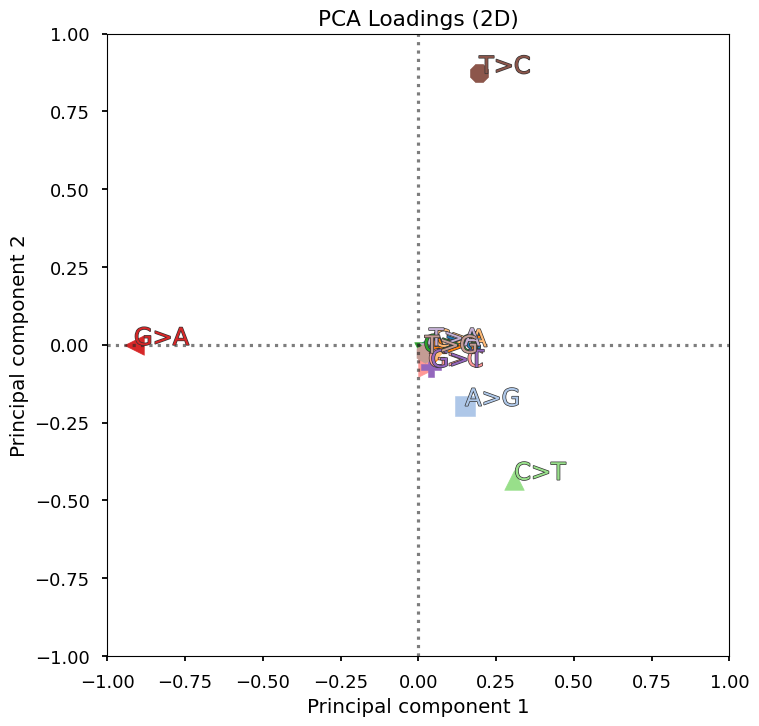

In [74]:
# PCA Loadings (2D)

text_settings = {
    'fontsize': 'xx-large',
    'outline': {'foreground': '0.2'}
}
pca_2d_loadings(
    pca, xvars,
    select_components={(1, 2)},
    text_settings=text_settings
)
plt.title('PCA Loadings (2D)')
plt.show()

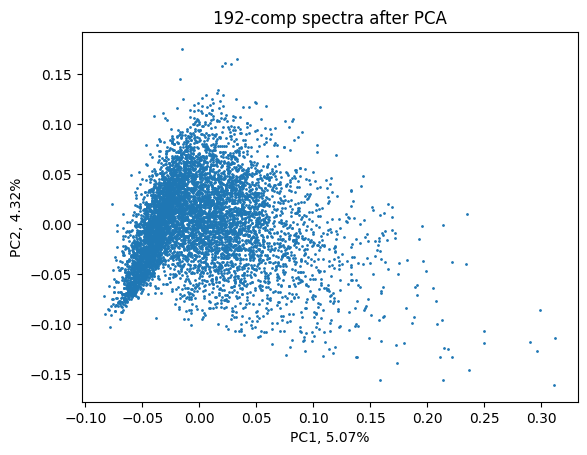

In [7]:
X = sp192.fillna(0.)
n_components = 2  # Specify the number of dimensions you want to reduce to
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)

# Plot the reduced dimensions
plt.scatter(X_pca[:, 0], X_pca[:, 1], s=1)  # Modify according to your number of components
plt.xlabel(f'PC1, {pca.explained_variance_ratio_[0]*100:.2f}%')
plt.ylabel(f'PC2, {pca.explained_variance_ratio_[1]*100:.2f}%')
plt.title('192-comp spectra after PCA')
plt.show()

### Spectrum on genes

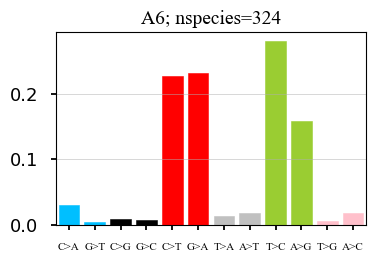

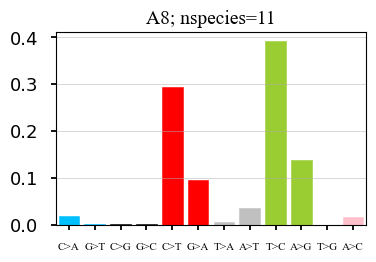

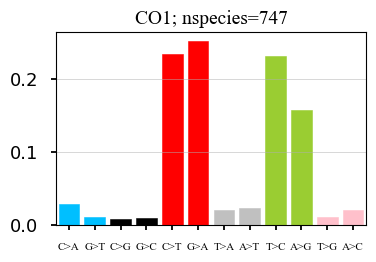

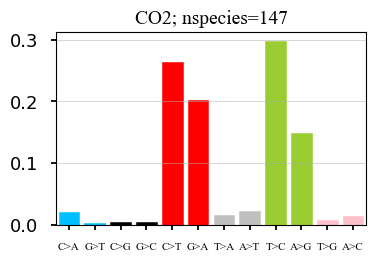

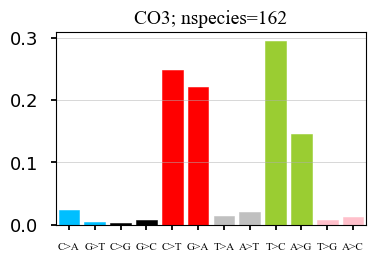

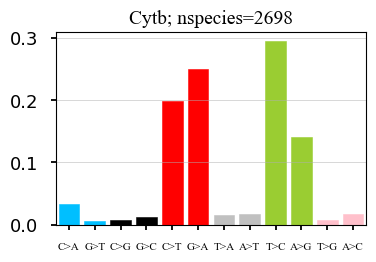

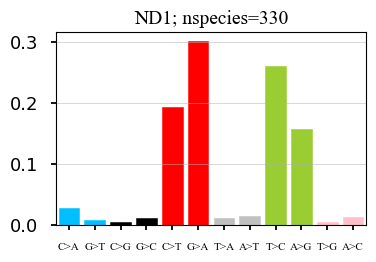

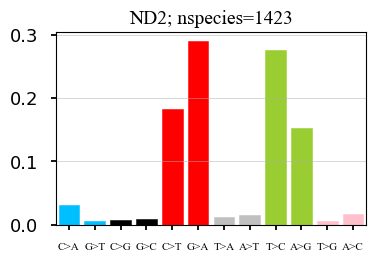

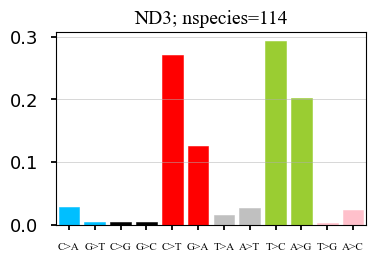

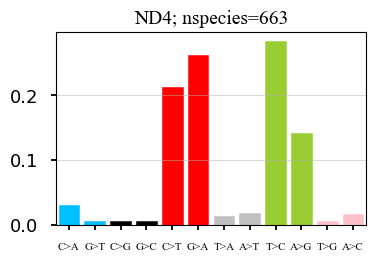

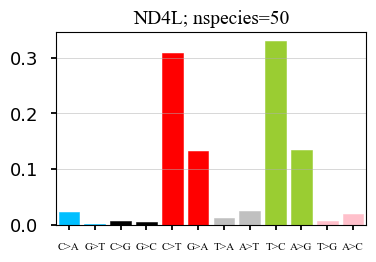

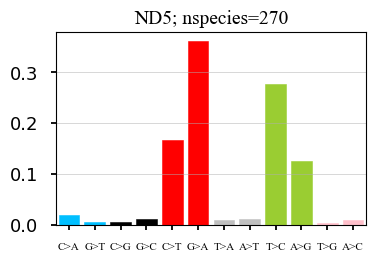

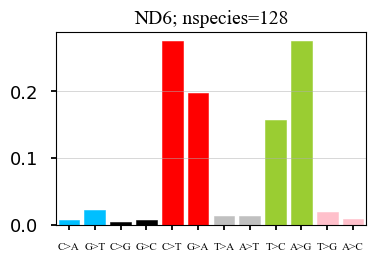

In [128]:
sp = pd.read_csv('../data/chordata2/spectra192.csv', index_col=0).fillna(0.)
for gene in class_names.values():
    a = sp.loc[sp.index.str.startswith(gene)]
    nspecies = len(a)
    a = a.mean(axis=0).reset_index()
    a.columns = ['Mut', 'MutSpec']

    plot_mutspec12(collapse_sbs192(a.set_index('Mut').T).T.reset_index(), 
                   title=f"{gene}; nspecies={nspecies}", figsize=(4, 2.5));

## Decomposition
ha-ha

ncomp = 1, train cossim = 0.55, test cossim = 0.54
ncomp = 2, train cossim = 0.57, test cossim = 0.57
ncomp = 3, train cossim = 0.60, test cossim = 0.60


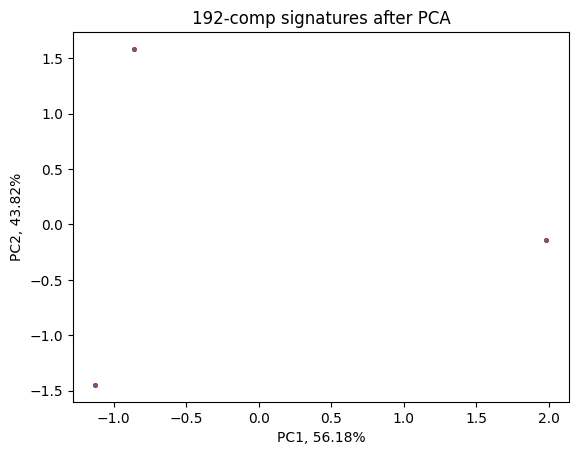


ncomp = 4, train cossim = 0.62, test cossim = 0.62


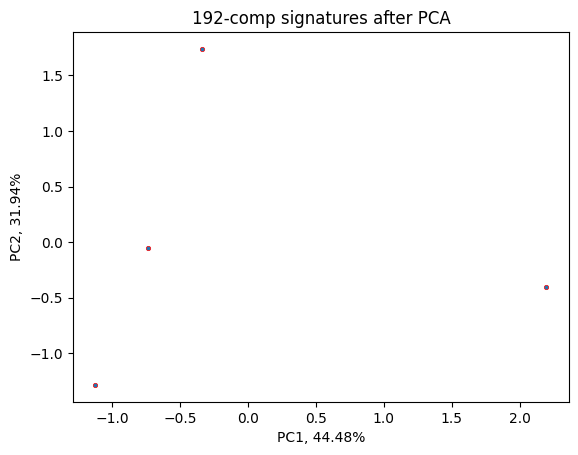


ncomp = 5, train cossim = 0.64, test cossim = 0.63


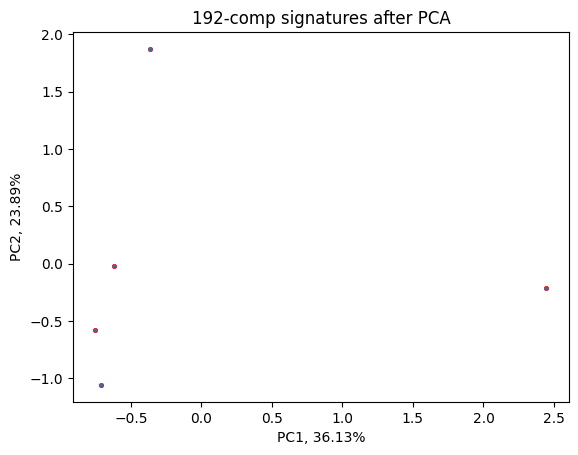


ncomp = 6, train cossim = 0.66, test cossim = 0.65


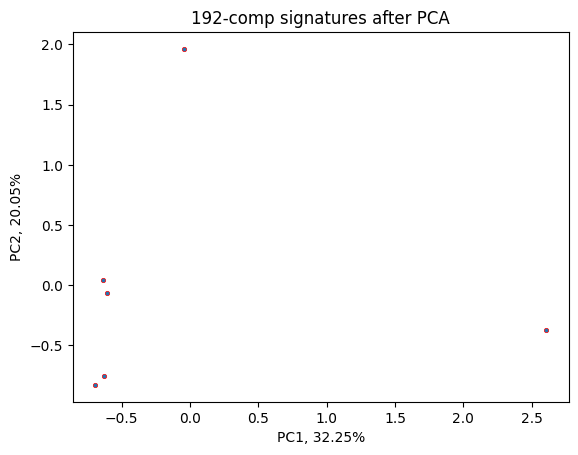


ncomp = 7, train cossim = 0.67, test cossim = 0.67


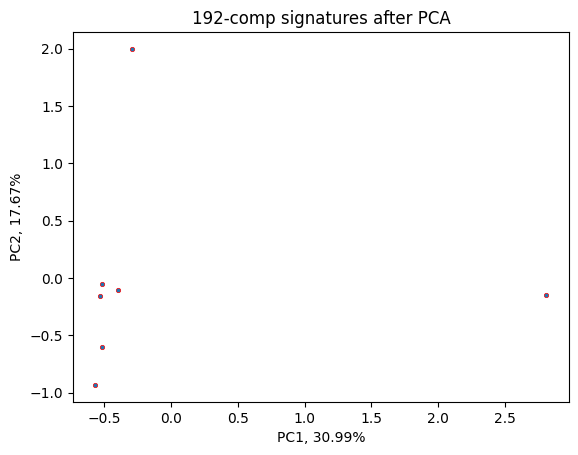


ncomp = 8, train cossim = 0.69, test cossim = 0.68


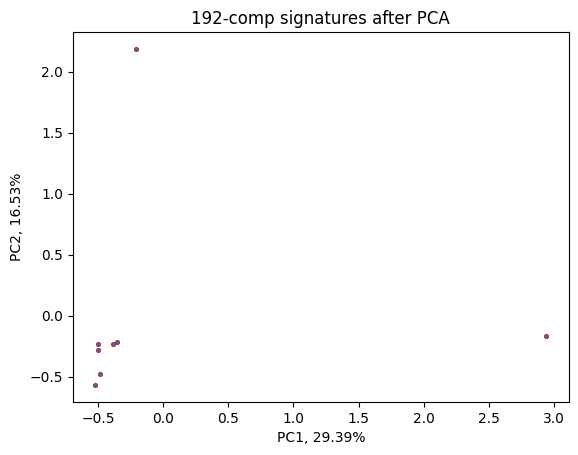


ncomp = 9, train cossim = 0.71, test cossim = 0.70


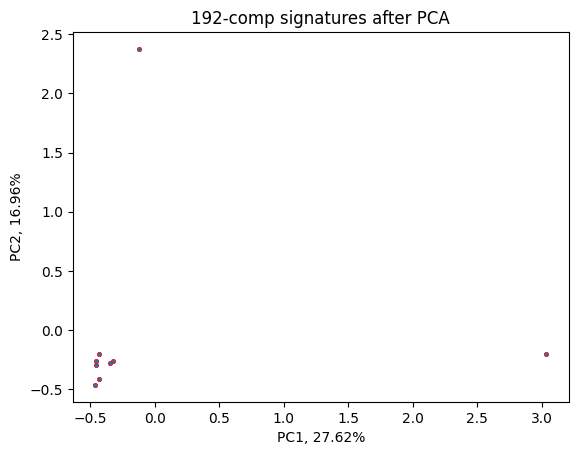


ncomp = 10, train cossim = 0.72, test cossim = 0.71


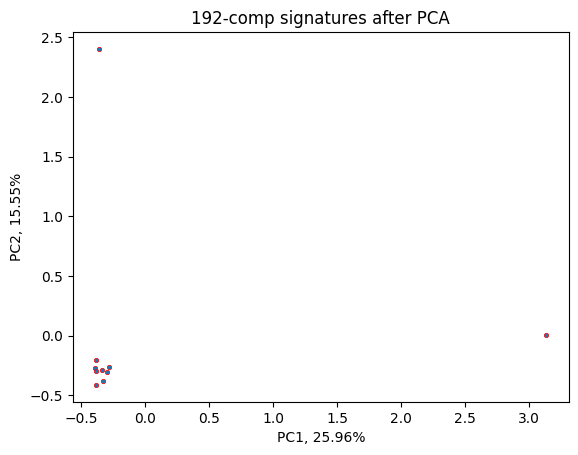

In [35]:
import numpy as np
from sklearn.decomposition import NMF
from sklearn.model_selection import train_test_split

# Example data matrix X (replace this with your actual data)
X = sp192.copy()

# Split the data into training and test sets
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Range of component numbers to try
component_range = range(1, 11)

# Test NMF with different numbers of components
for n_components in component_range:
    # Create and fit the NMF model to the training data
    model = NMF(n_components=n_components, random_state=42, max_iter=500)
    W = model.fit_transform(X_train)
    H = model.components_
    
    # Reconstruct the test data
    X_reconstructed = np.dot(W, H)
    rec_df_train = pd.DataFrame(X_reconstructed, index=X_train.index, columns=X_train.columns)
    
    X_reconstructed_test = model.inverse_transform(model.transform(X_test))
    rec_df_test = pd.DataFrame(X_reconstructed_test, index=X_test.index, columns=X_test.columns)

    # Calculate the reconstruction error on the test data
    cossims_train = get_cossim(X_train, rec_df_train)
    cossims_test = get_cossim(X_test, rec_df_test)

    print(f"ncomp = {n_components}, train cossim = {cossims_train.mean():.2f}, test cossim = {cossims_test.mean():.2f}")

    if n_components > 2:
        signatures = pd.DataFrame(H, columns=X_train.columns)
        pca = PCA(2)
        X_pca = pca.fit_transform(signatures)

        # Plot the reduced dimensions
        plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, edgecolors='red', linewidths=0.5)
        plt.xlabel(f'PC1, {pca.explained_variance_ratio_[0]*100:.2f}%')
        plt.ylabel(f'PC2, {pca.explained_variance_ratio_[1]*100:.2f}%')
        plt.title('192-comp signatures after PCA')
        plt.show()
        print()


In [17]:
Ts_lst = []
for x in possible_sbs192:
    for _ts in ['C>T','T>C','A>G','G>A']:
        if _ts in x:
            Ts_lst.append(x)

In [37]:
# Ts only
import numpy as np
from sklearn.decomposition import NMF
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

# Example data matrix X (replace this with your actual data)
X = sp192[Ts_lst].copy()

# Split the data into training and test sets
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Range of component numbers to try
component_range = range(1, 21)

# Test NMF with different numbers of components
for n_components in component_range:
    # Create and fit the NMF model to the training data
    model = NMF(n_components=n_components, random_state=42, max_iter=500)
    W = model.fit_transform(X_train)
    H = model.components_
    
    # Reconstruct the test data
    X_reconstructed = np.dot(W, H)
    rec_df_train = pd.DataFrame(X_reconstructed, index=X_train.index, columns=X_train.columns)
    
    X_reconstructed_test = model.inverse_transform(model.transform(X_test))
    rec_df_test = pd.DataFrame(X_reconstructed_test, index=X_test.index, columns=X_test.columns)

    # Calculate the reconstruction error on the test data
    cossims_train = get_cossim(X_train, rec_df_train)
    cossims_test = get_cossim(X_test, rec_df_test)

    print(f"{n_components}, train cossim = {cossims_train.mean():.2f}, test cossim = {cossims_test.mean():.2f}")

    # if n_components > 2:
    #     signatures = pd.DataFrame(H, columns=X_train.columns)
    #     pca = PCA(2)
    #     X_pca = pca.fit_transform(signatures)

    #     # Plot the reduced dimensions
    #     plt.scatter(X_pca[:, 0], X_pca[:, 1], s=10, edgecolors='red', linewidths=0.5)
    #     plt.xlabel(f'PC1, {pca.explained_variance_ratio_[0]*100:.2f}%')
    #     plt.ylabel(f'PC2, {pca.explained_variance_ratio_[1]*100:.2f}%')
    #     plt.title('192-comp signatures after PCA')
    #     plt.show()
    #     print()


1, train cossim = 0.56, test cossim = 0.56
2, train cossim = 0.59, test cossim = 0.59
3, train cossim = 0.62, test cossim = 0.62
4, train cossim = 0.64, test cossim = 0.64
5, train cossim = 0.66, test cossim = 0.66
6, train cossim = 0.68, test cossim = 0.67
7, train cossim = 0.70, test cossim = 0.69
8, train cossim = 0.72, test cossim = 0.71
9, train cossim = 0.73, test cossim = 0.72
10, train cossim = 0.74, test cossim = 0.73
11, train cossim = 0.76, test cossim = 0.75
12, train cossim = 0.77, test cossim = 0.76
13, train cossim = 0.78, test cossim = 0.77
14, train cossim = 0.79, test cossim = 0.78
15, train cossim = 0.80, test cossim = 0.79
16, train cossim = 0.81, test cossim = 0.80
17, train cossim = 0.82, test cossim = 0.81
18, train cossim = 0.83, test cossim = 0.82
19, train cossim = 0.84, test cossim = 0.83
20, train cossim = 0.84, test cossim = 0.84


### Let's visualise the signatures

ncomp = 1, train cossim = 0.55, test cossim = 0.54


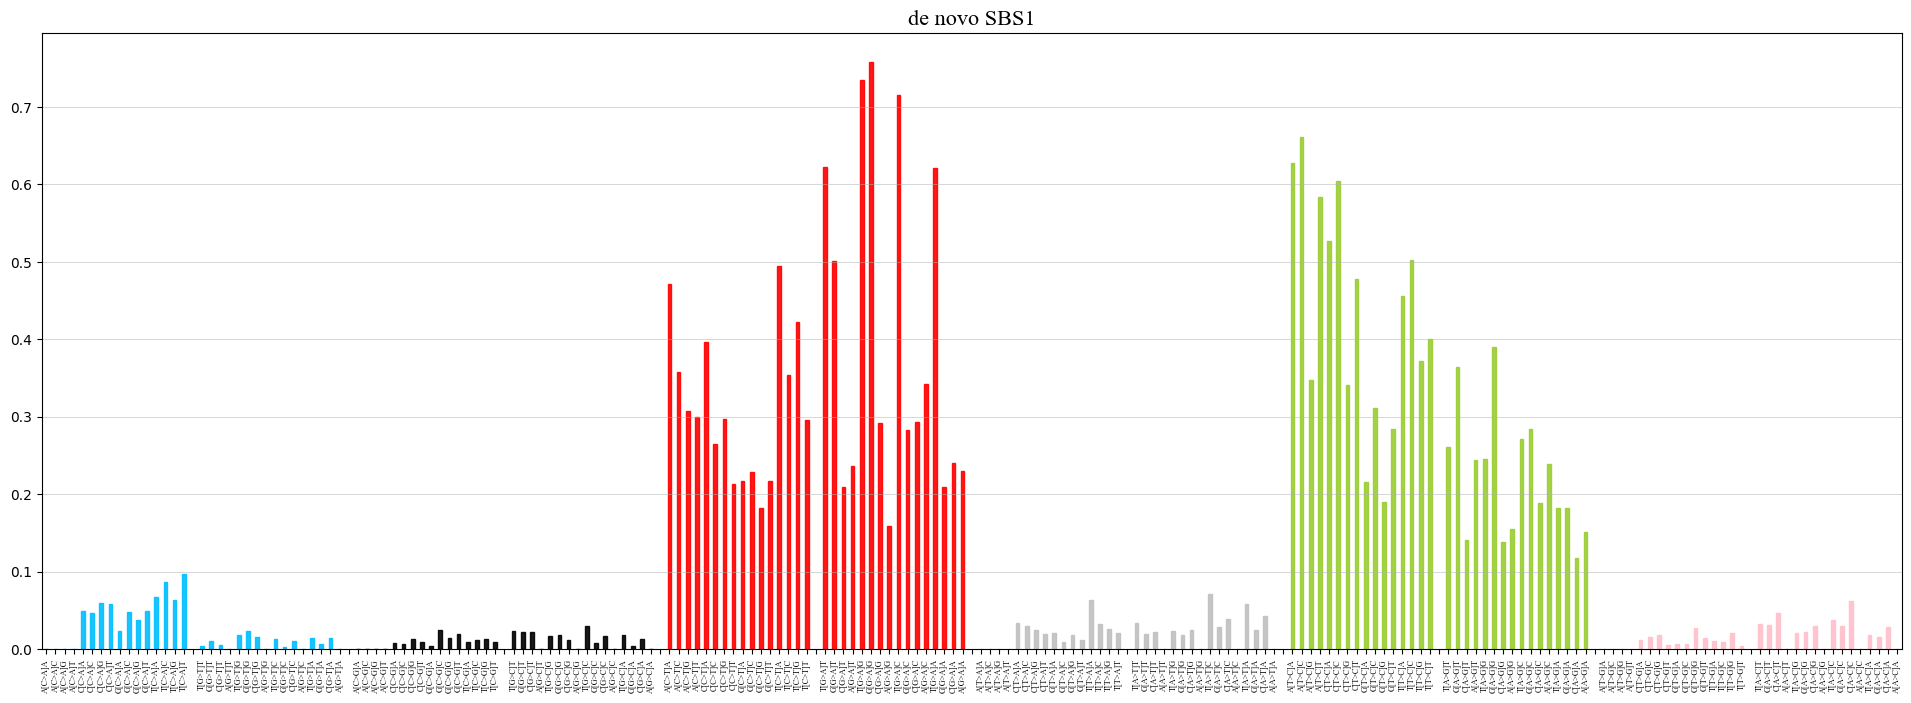

ncomp = 2, train cossim = 0.57, test cossim = 0.57


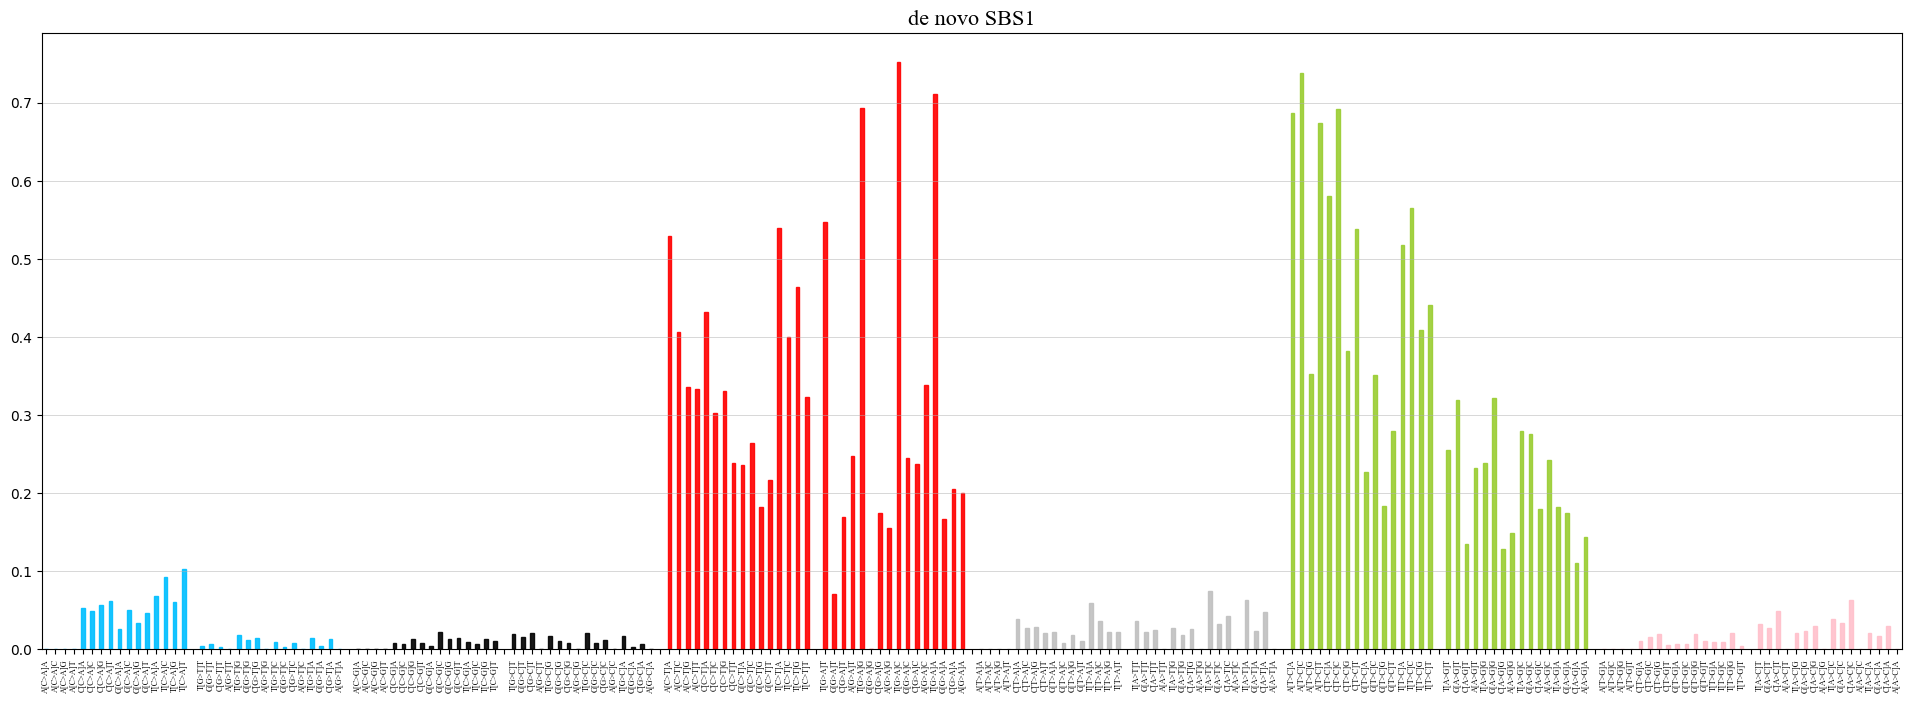

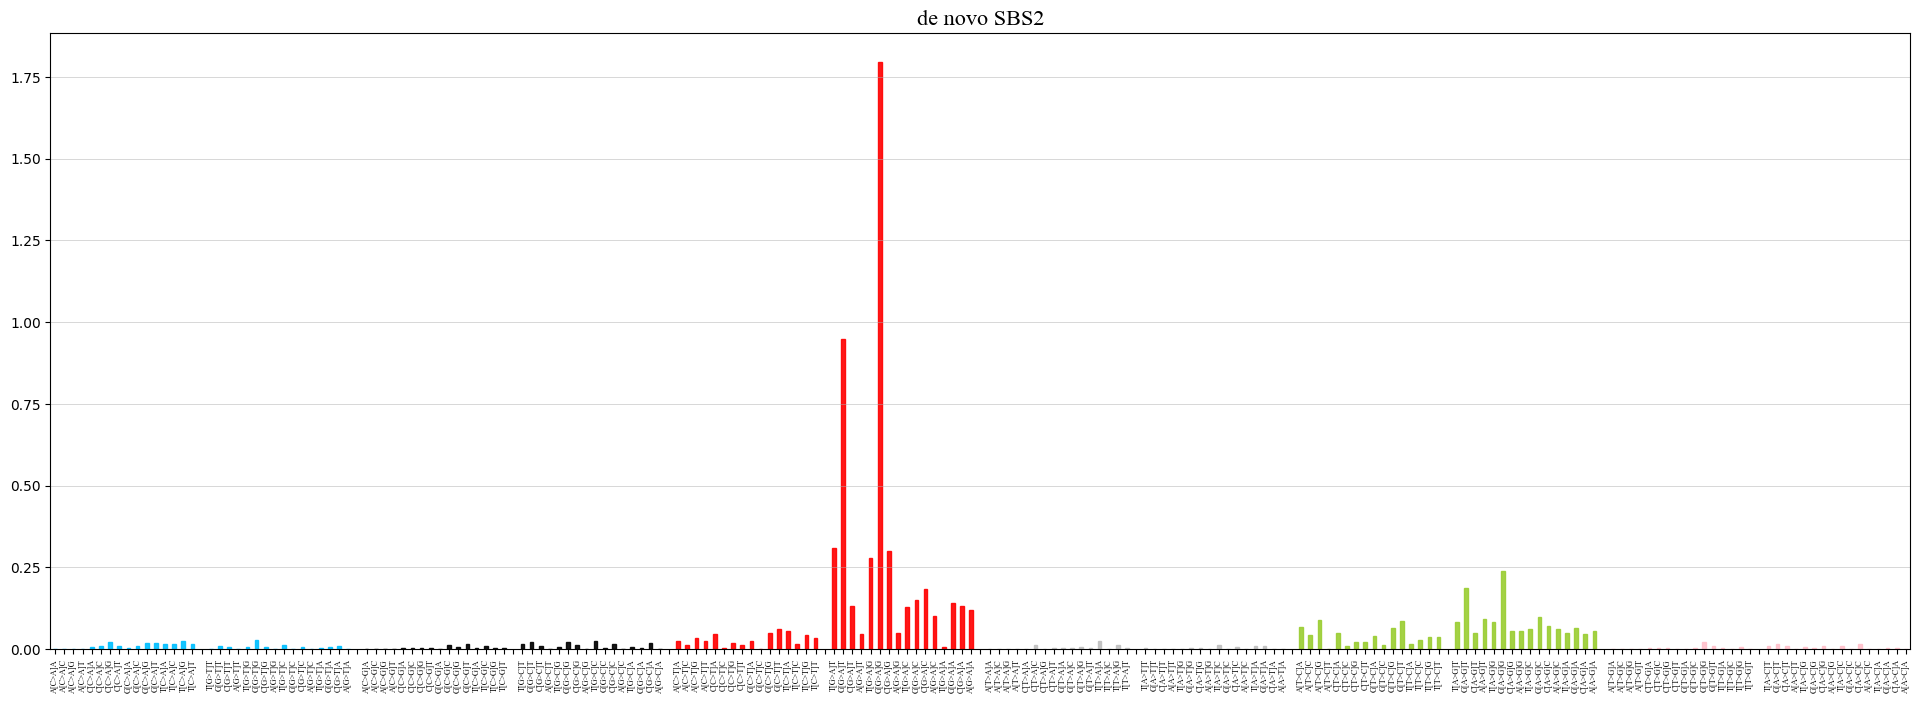

ncomp = 3, train cossim = 0.60, test cossim = 0.60


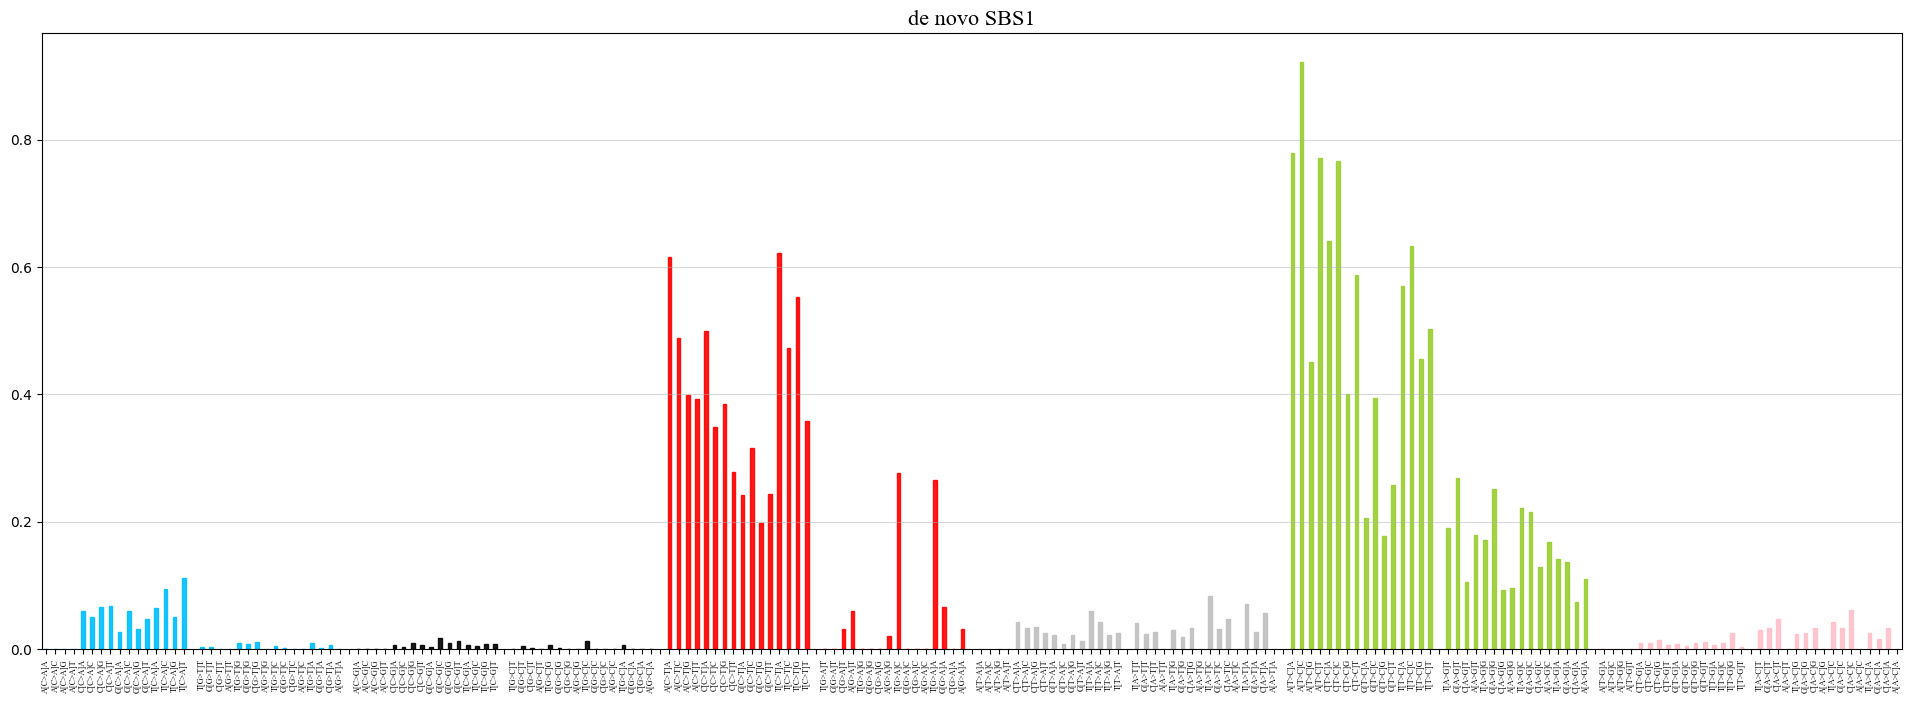

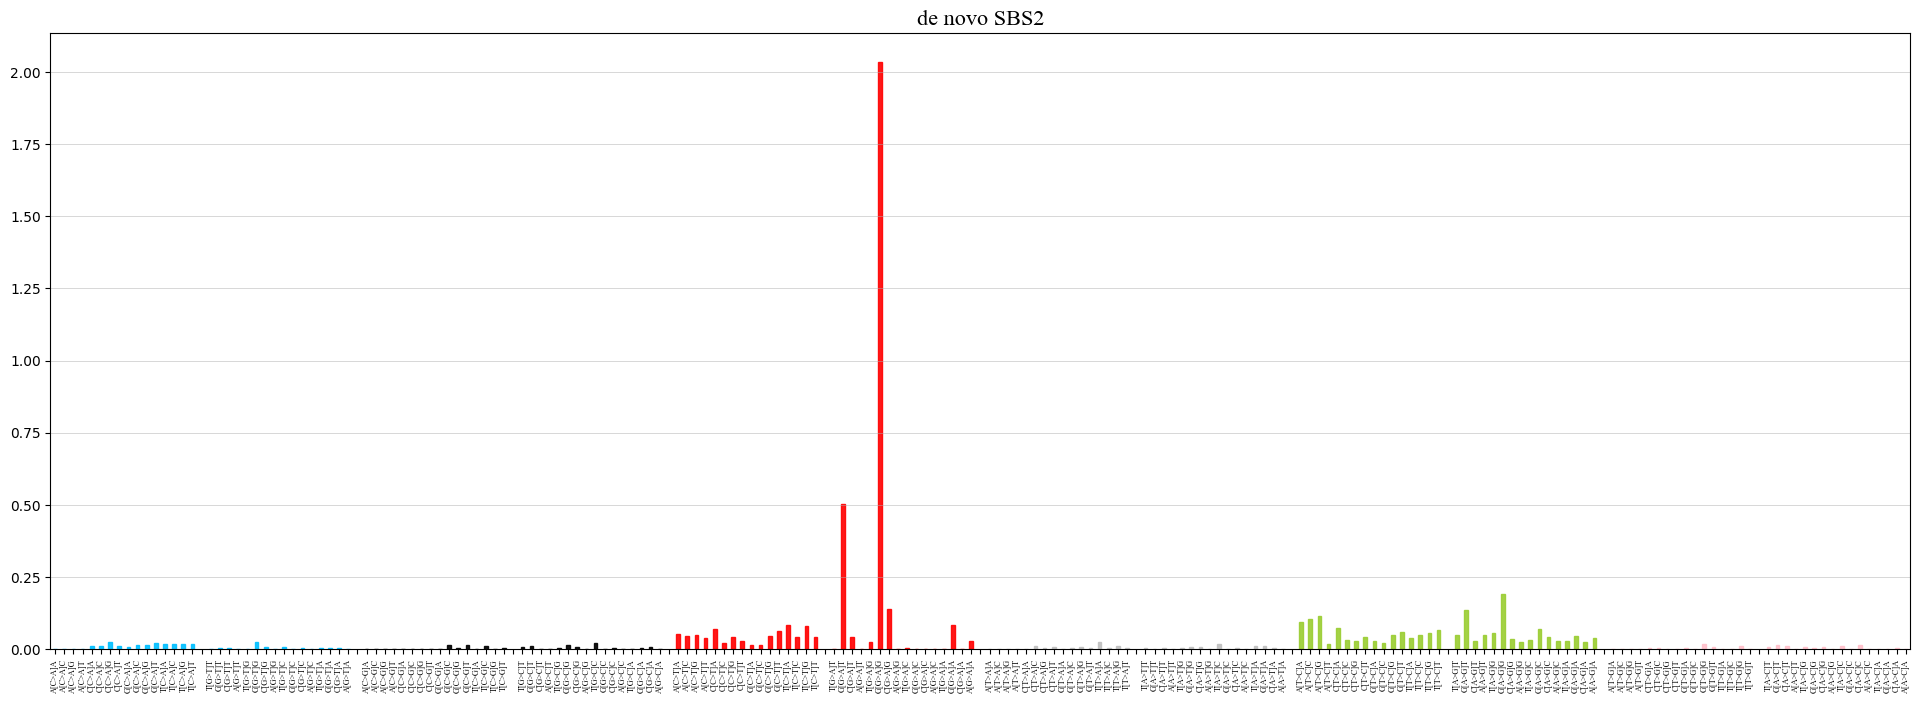

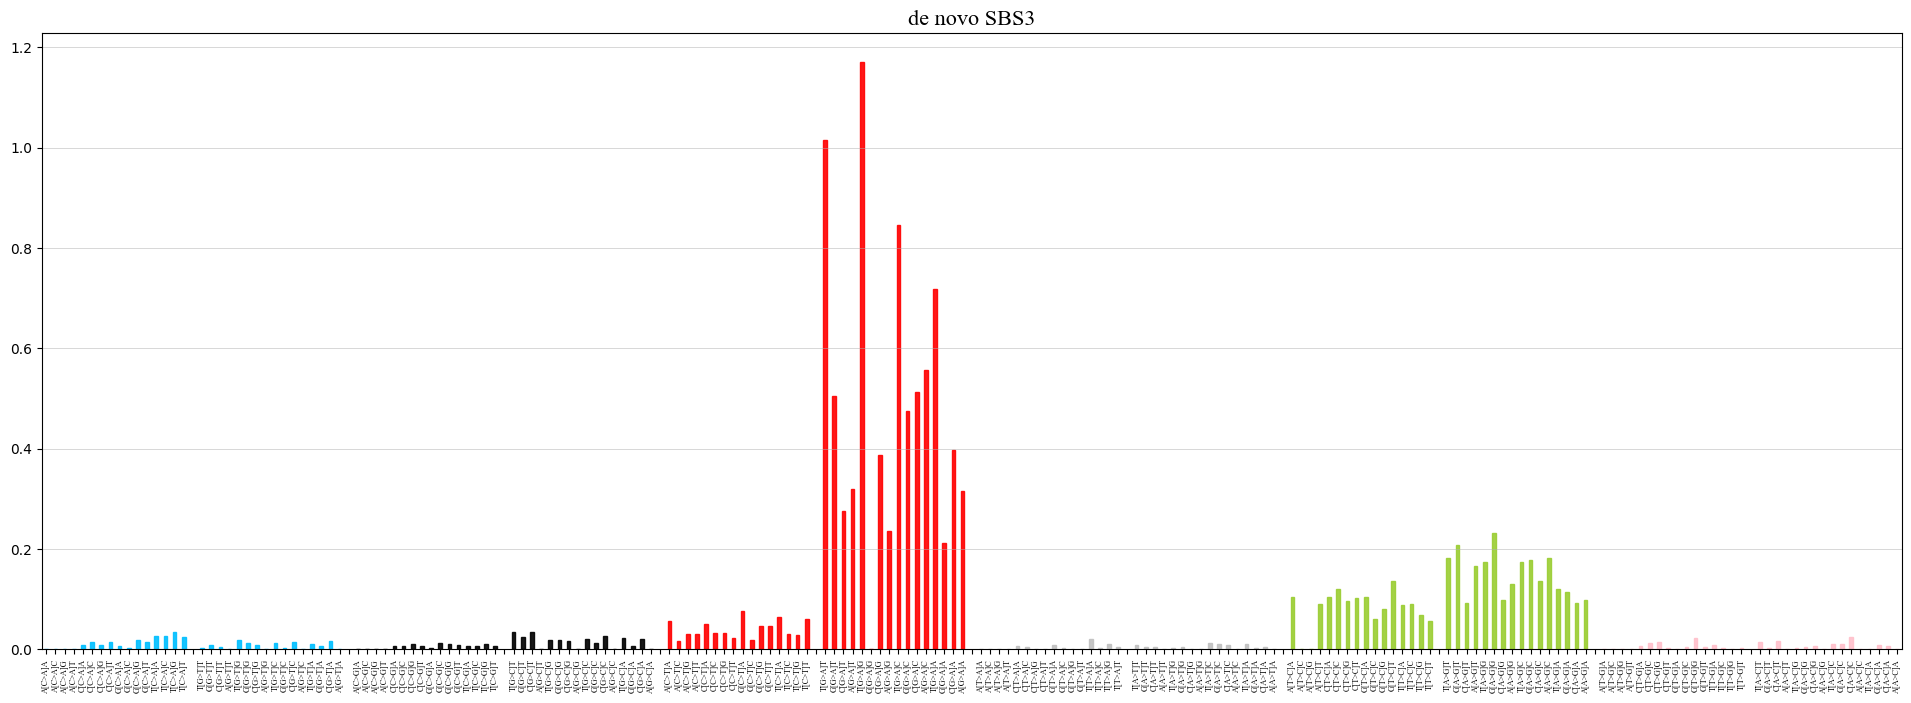

ncomp = 4, train cossim = 0.62, test cossim = 0.62


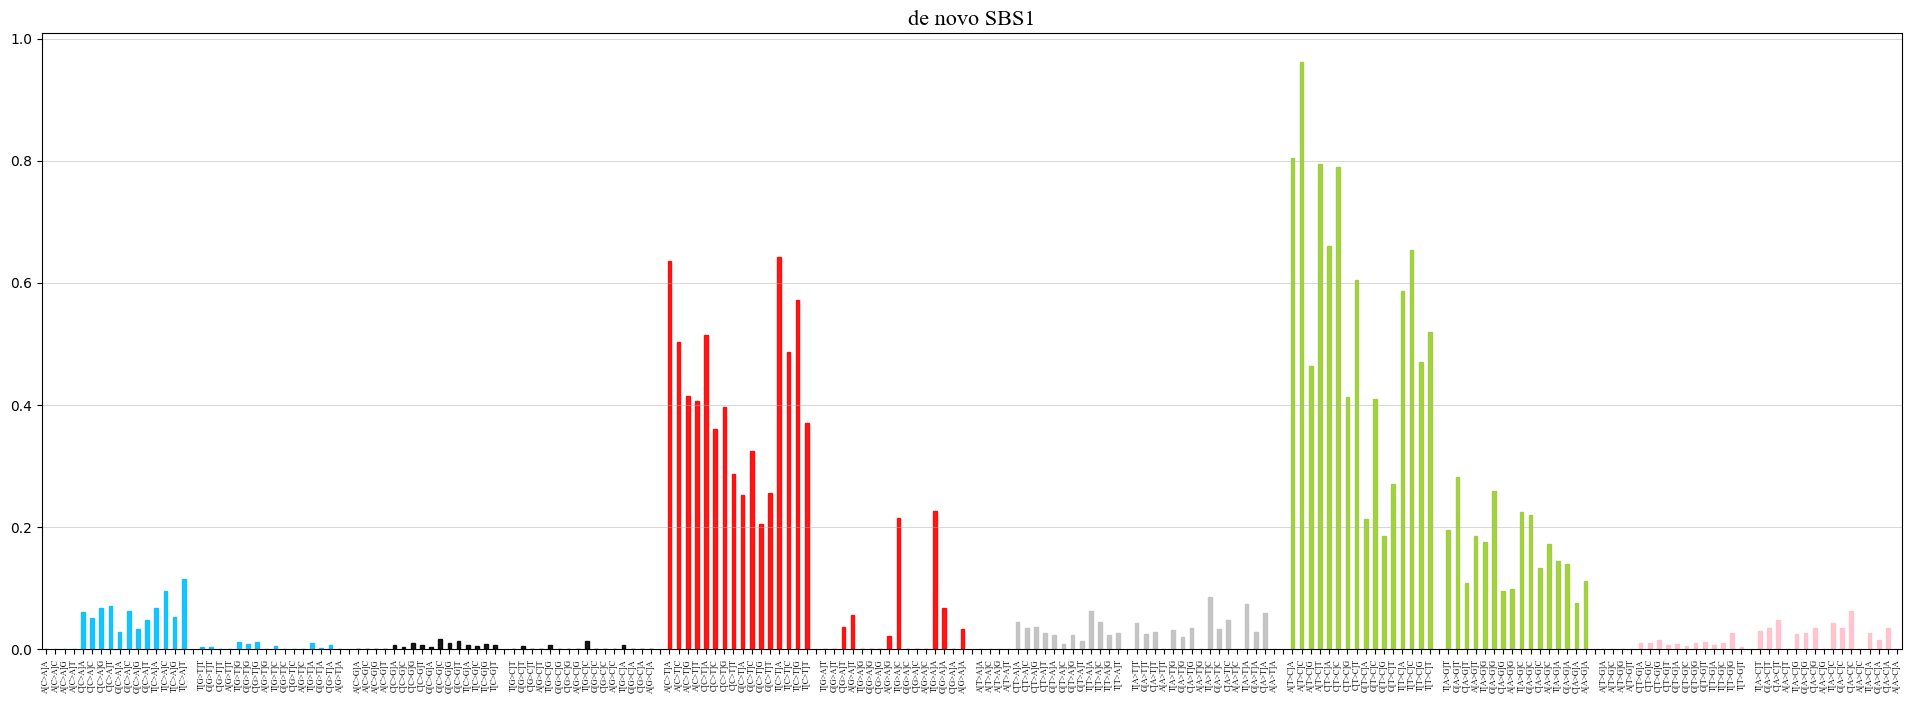

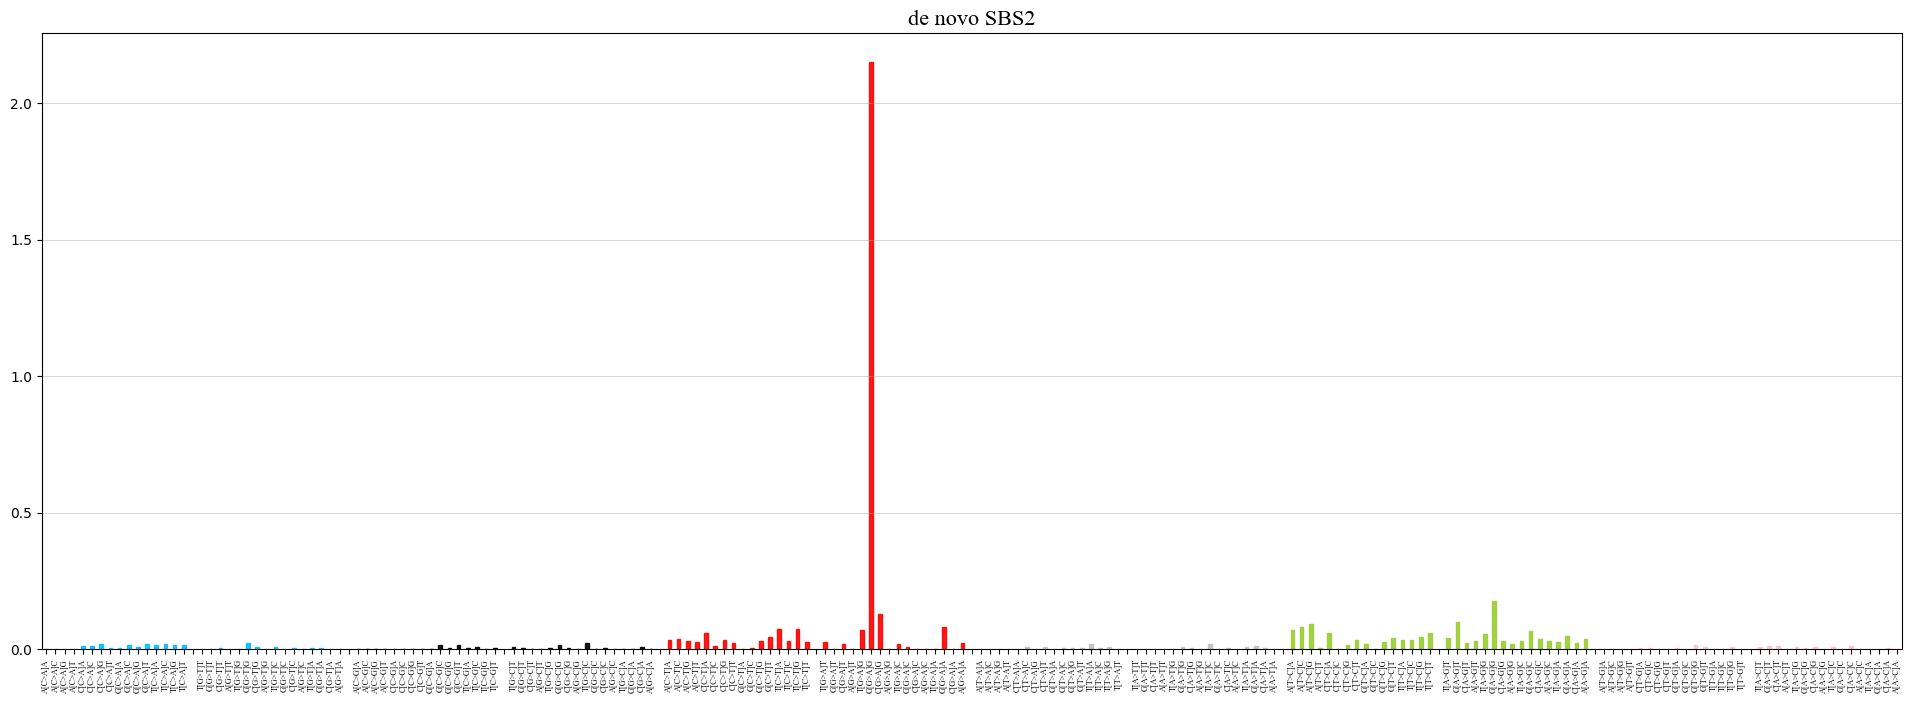

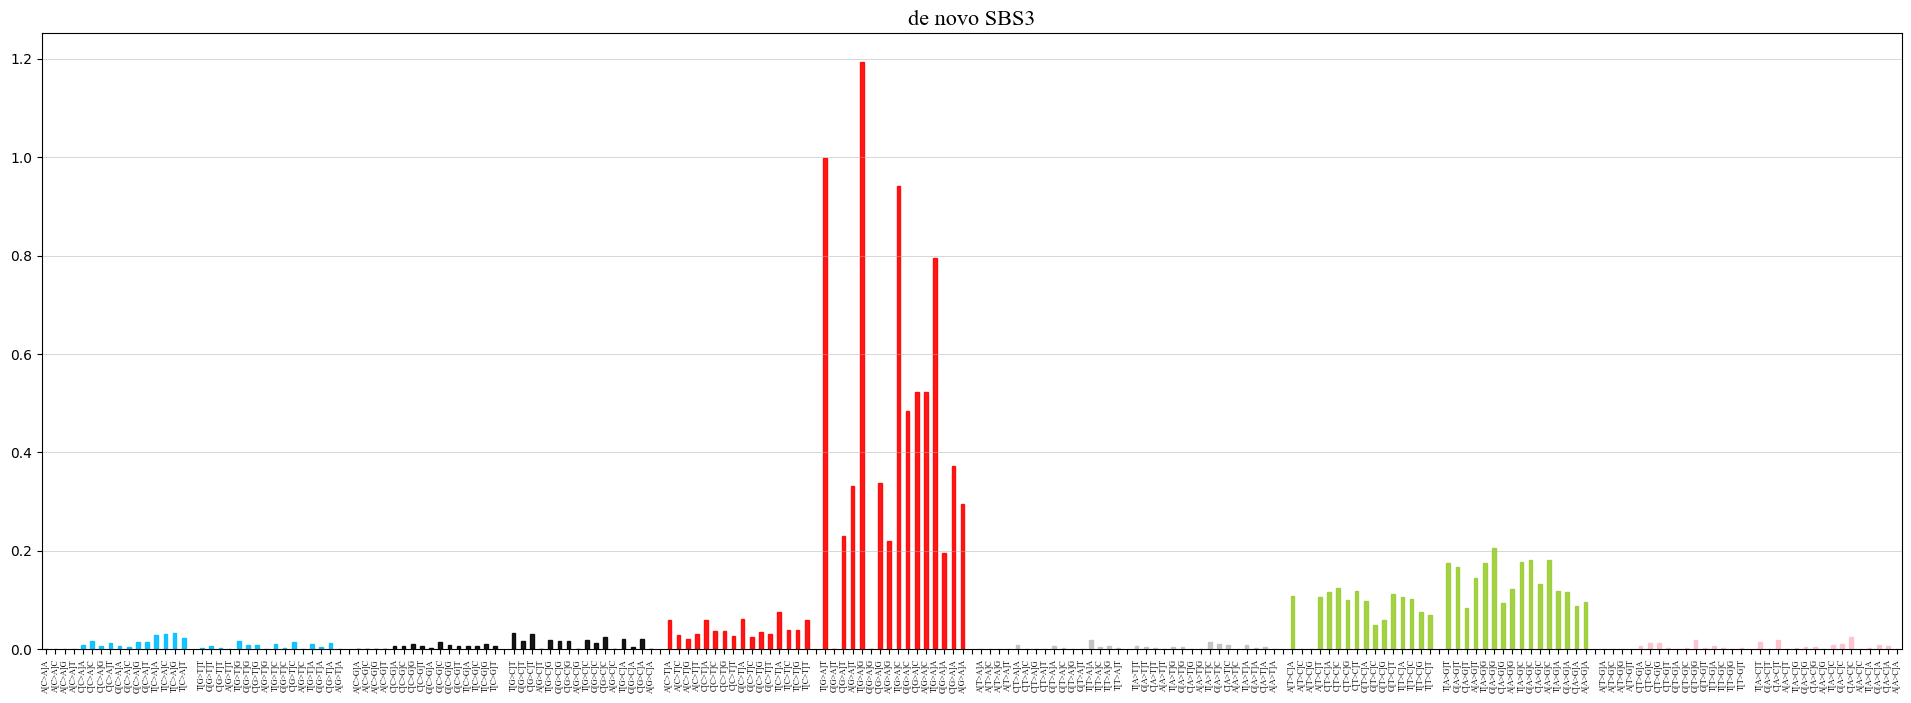

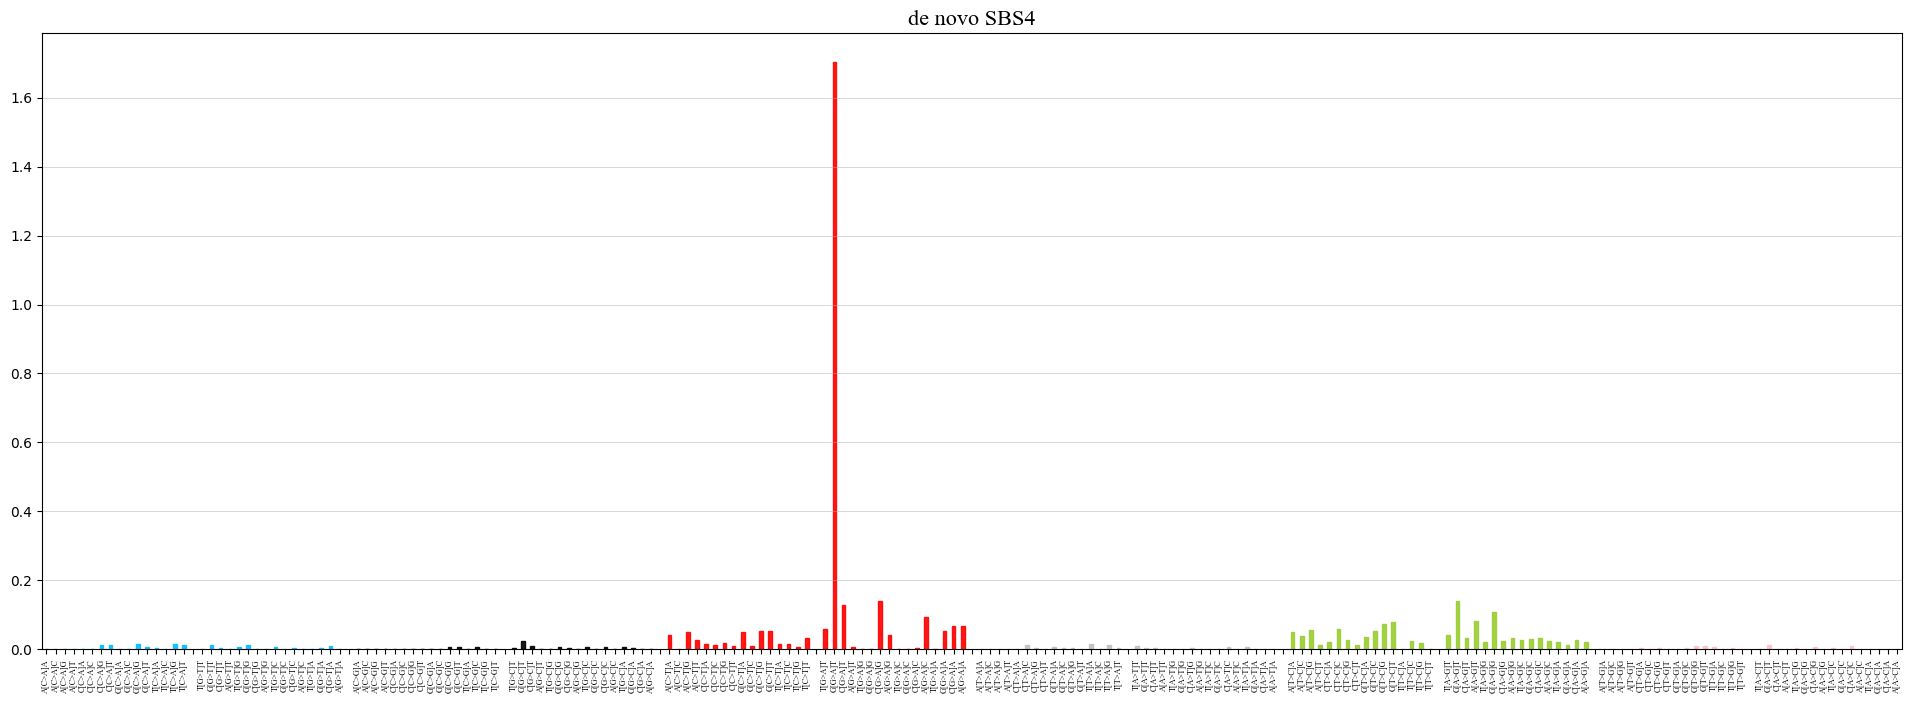

ncomp = 5, train cossim = 0.64, test cossim = 0.63


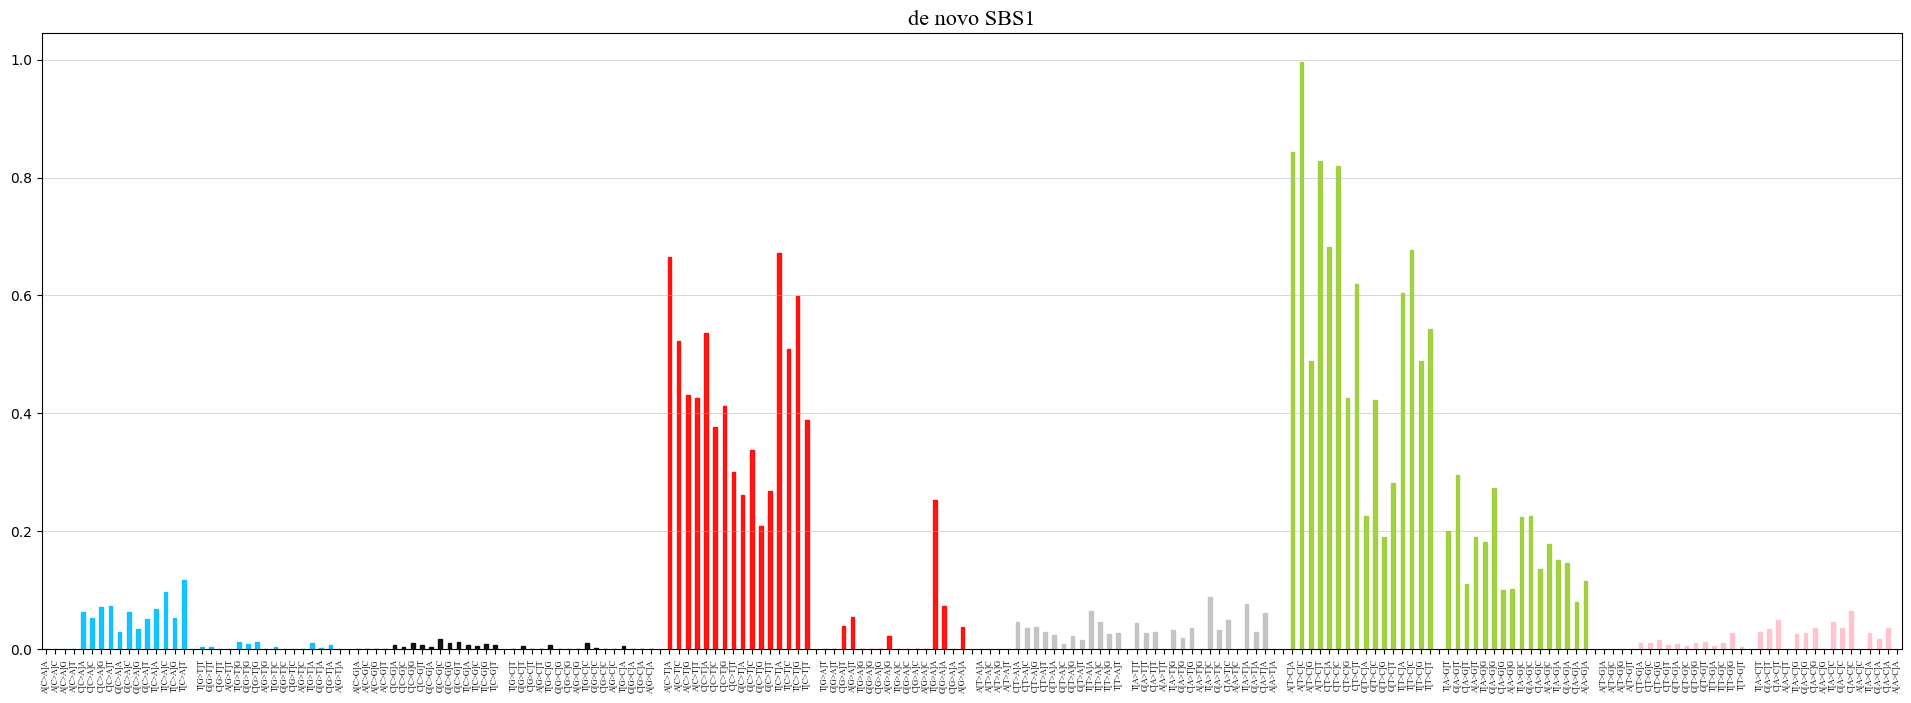

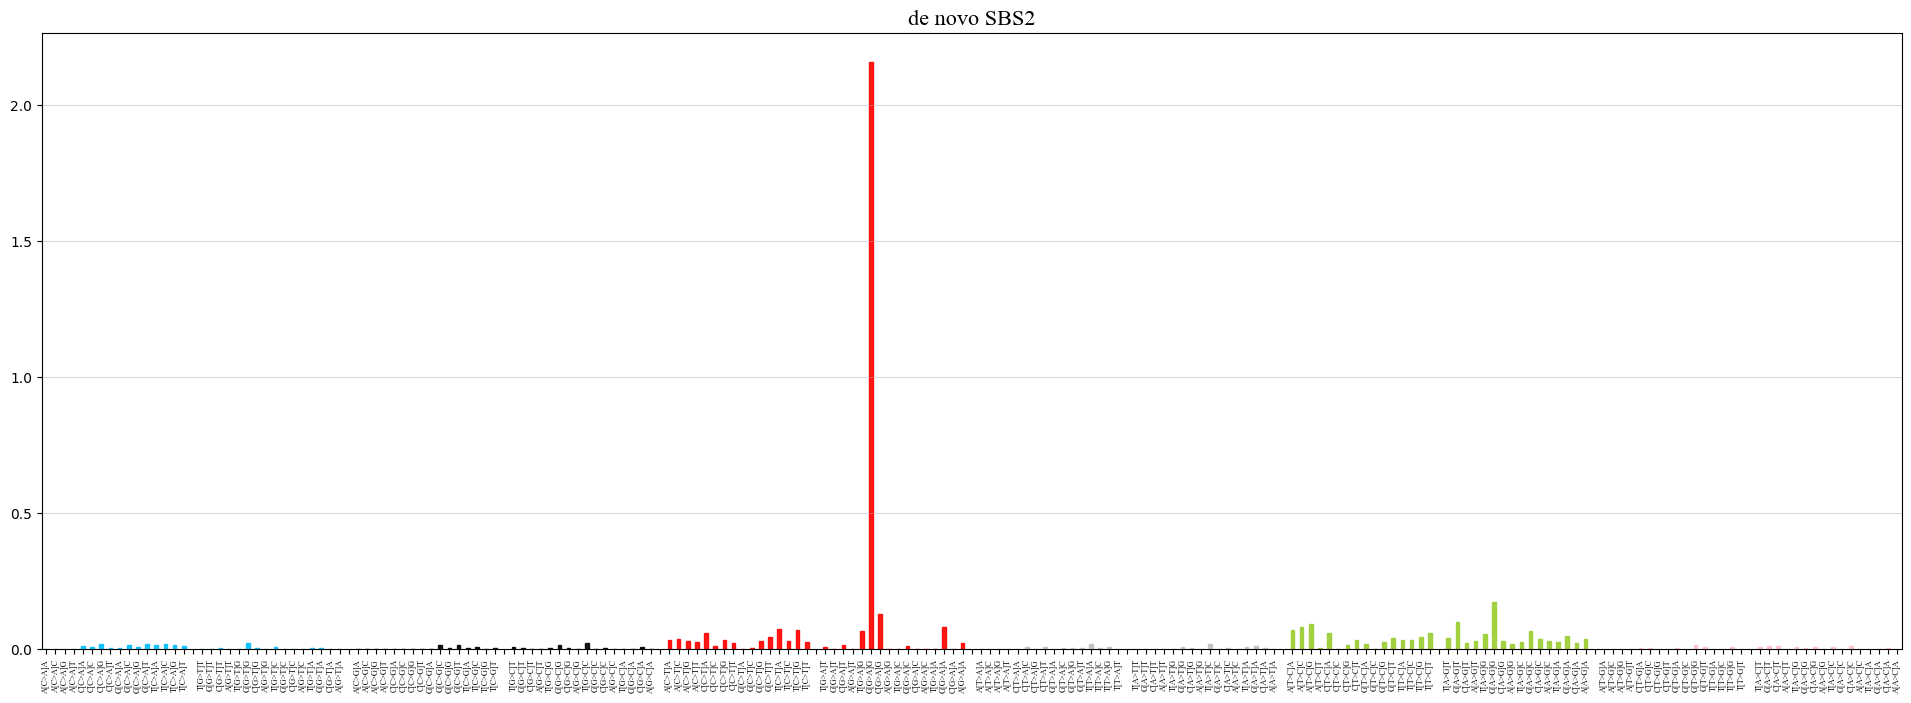

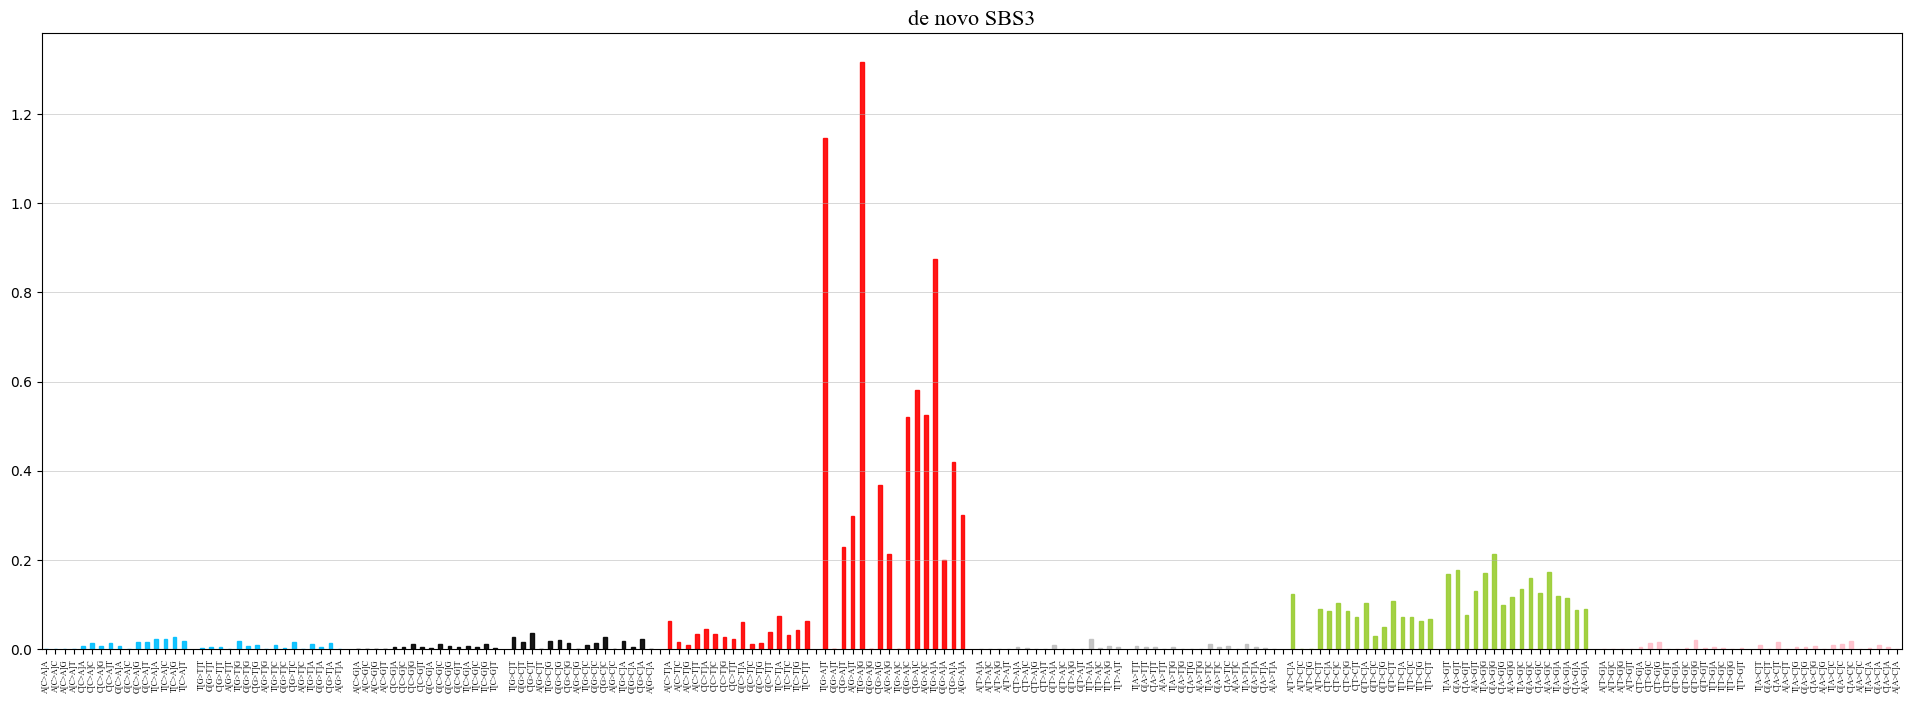

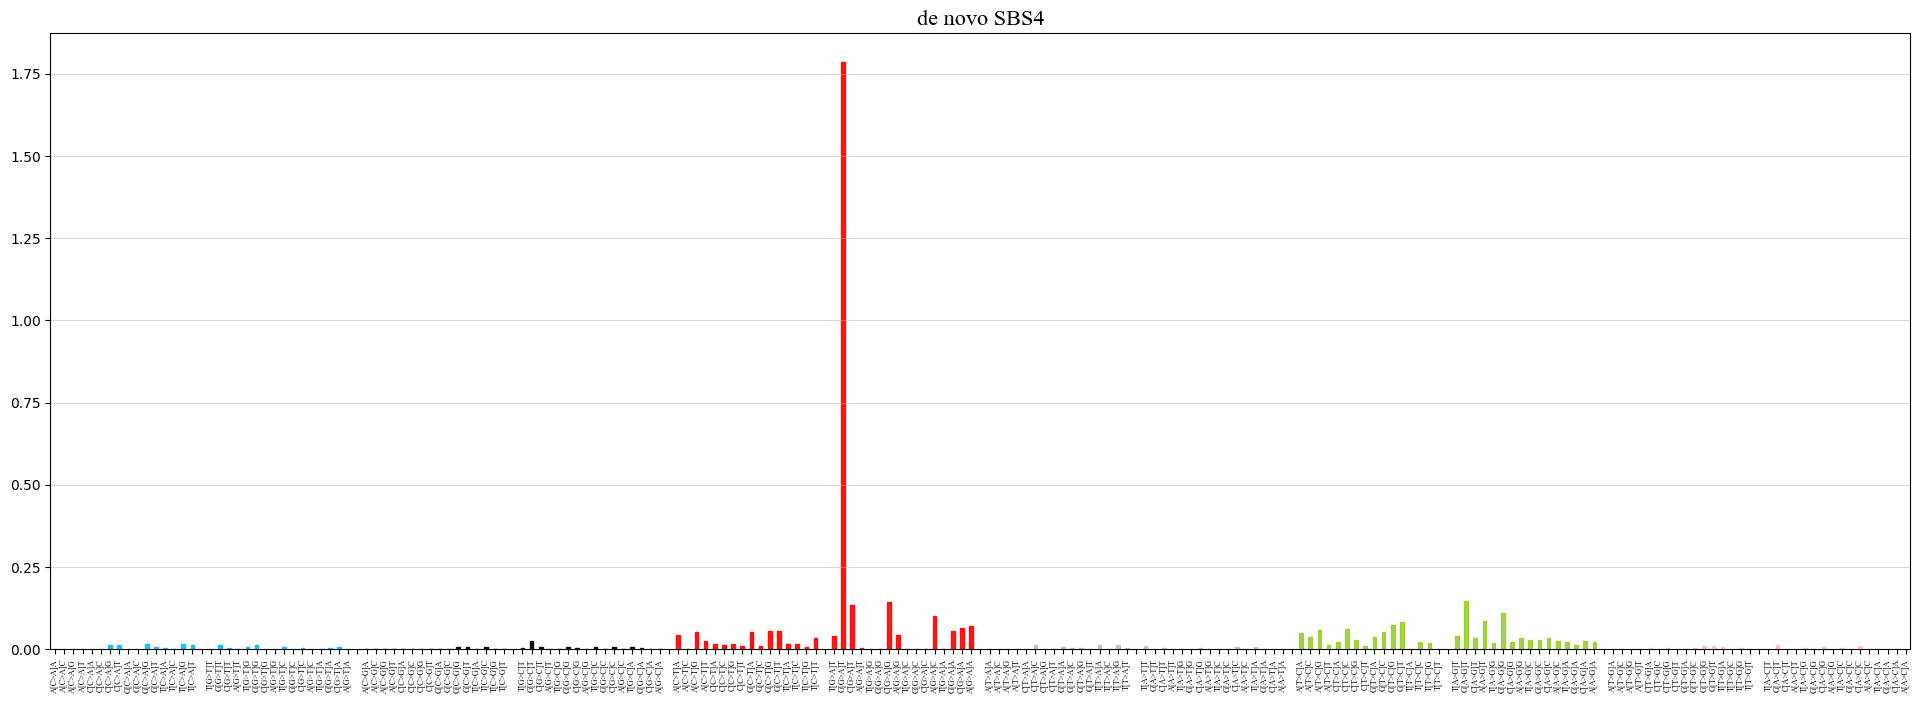

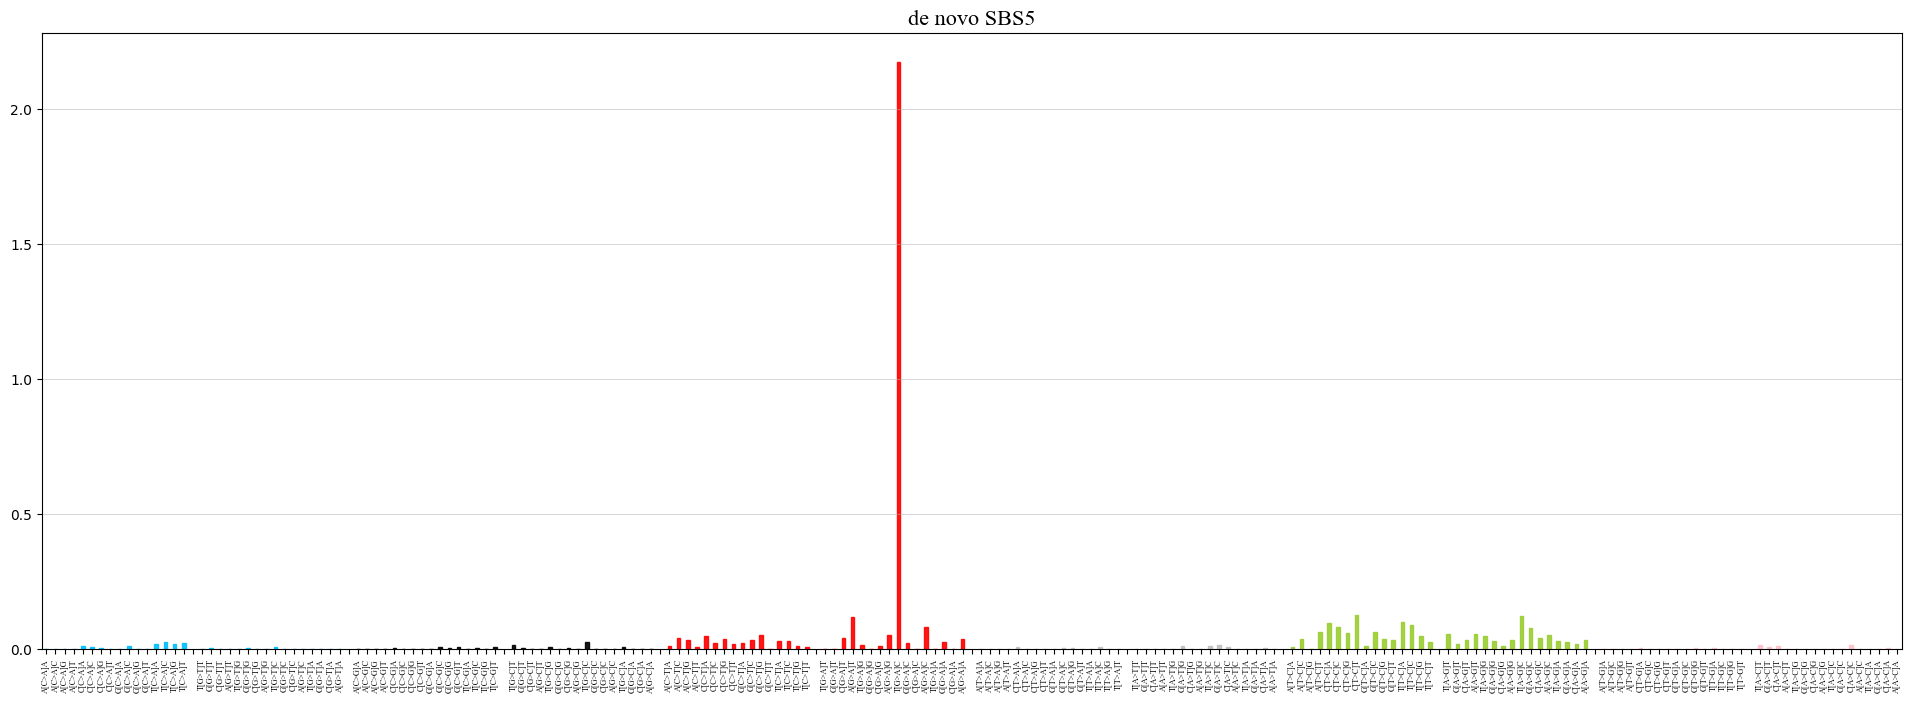

ncomp = 6, train cossim = 0.66, test cossim = 0.65


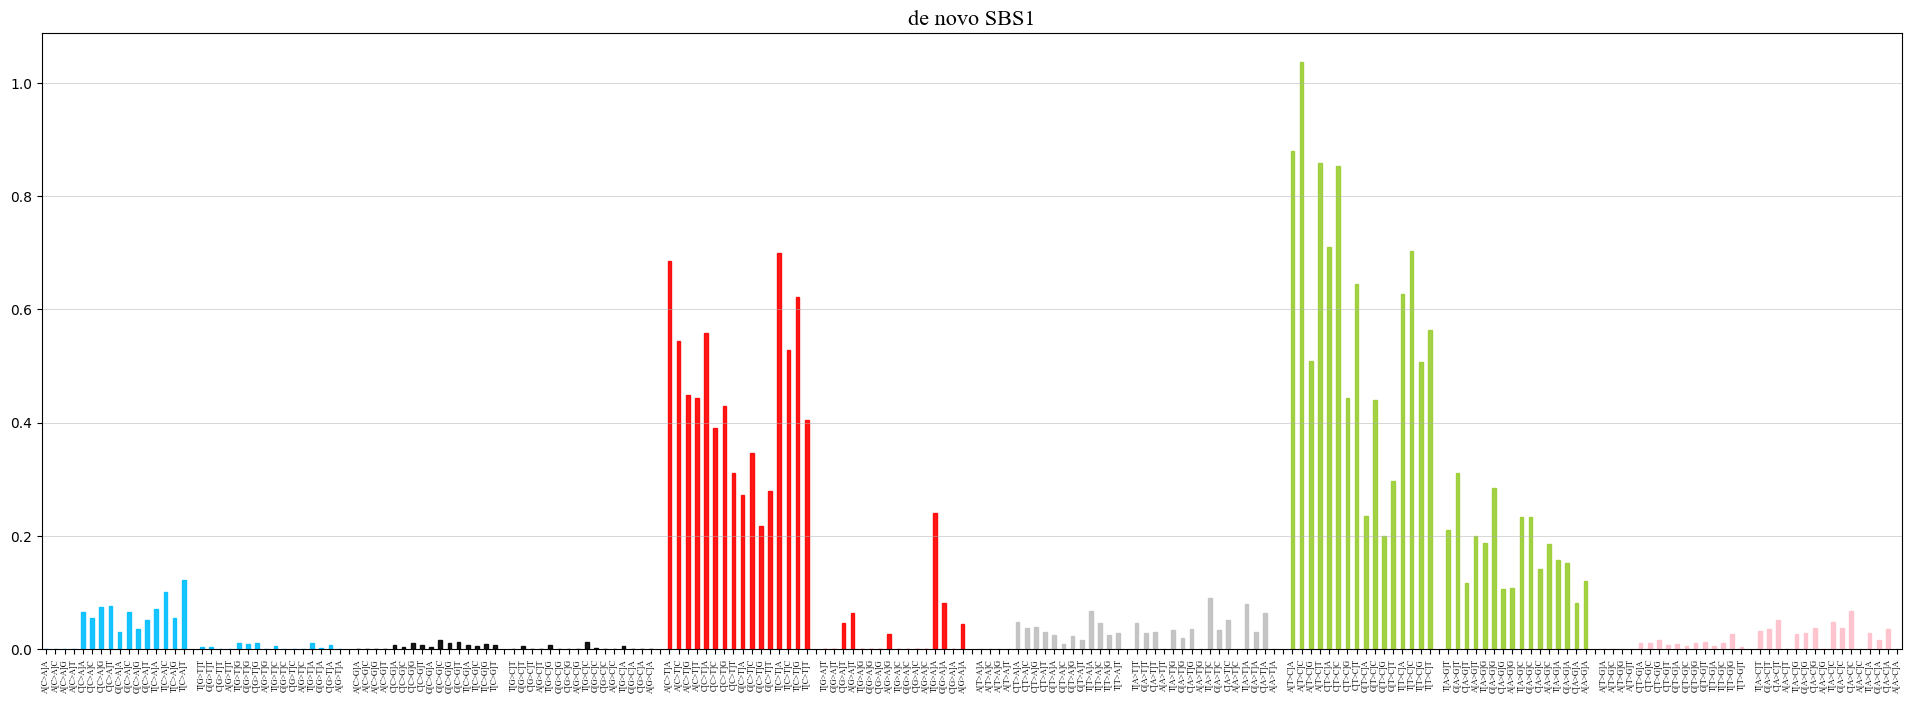

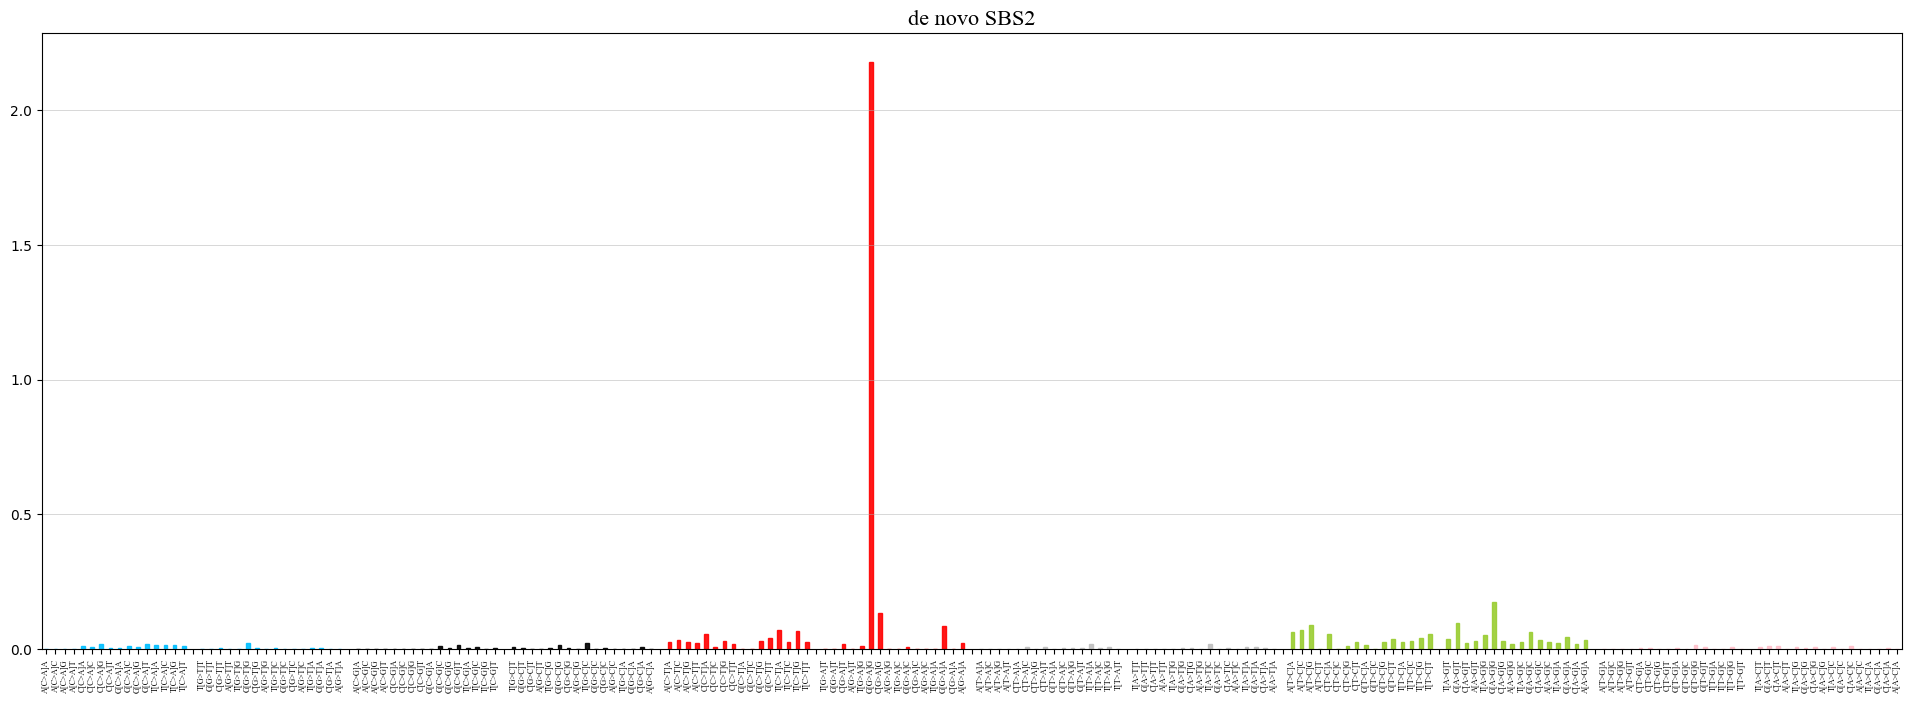

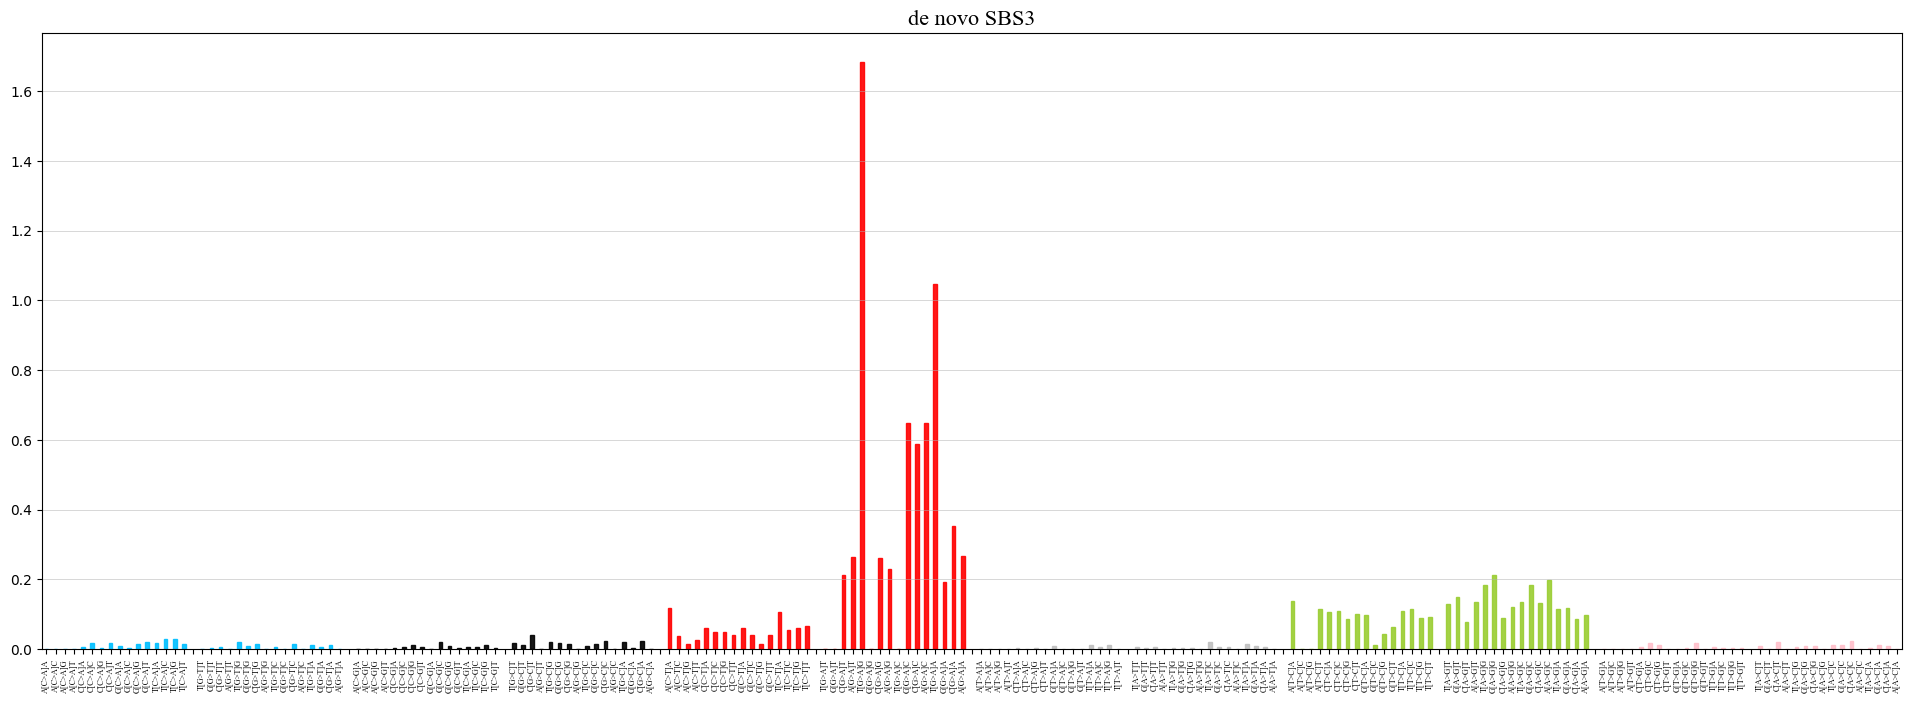

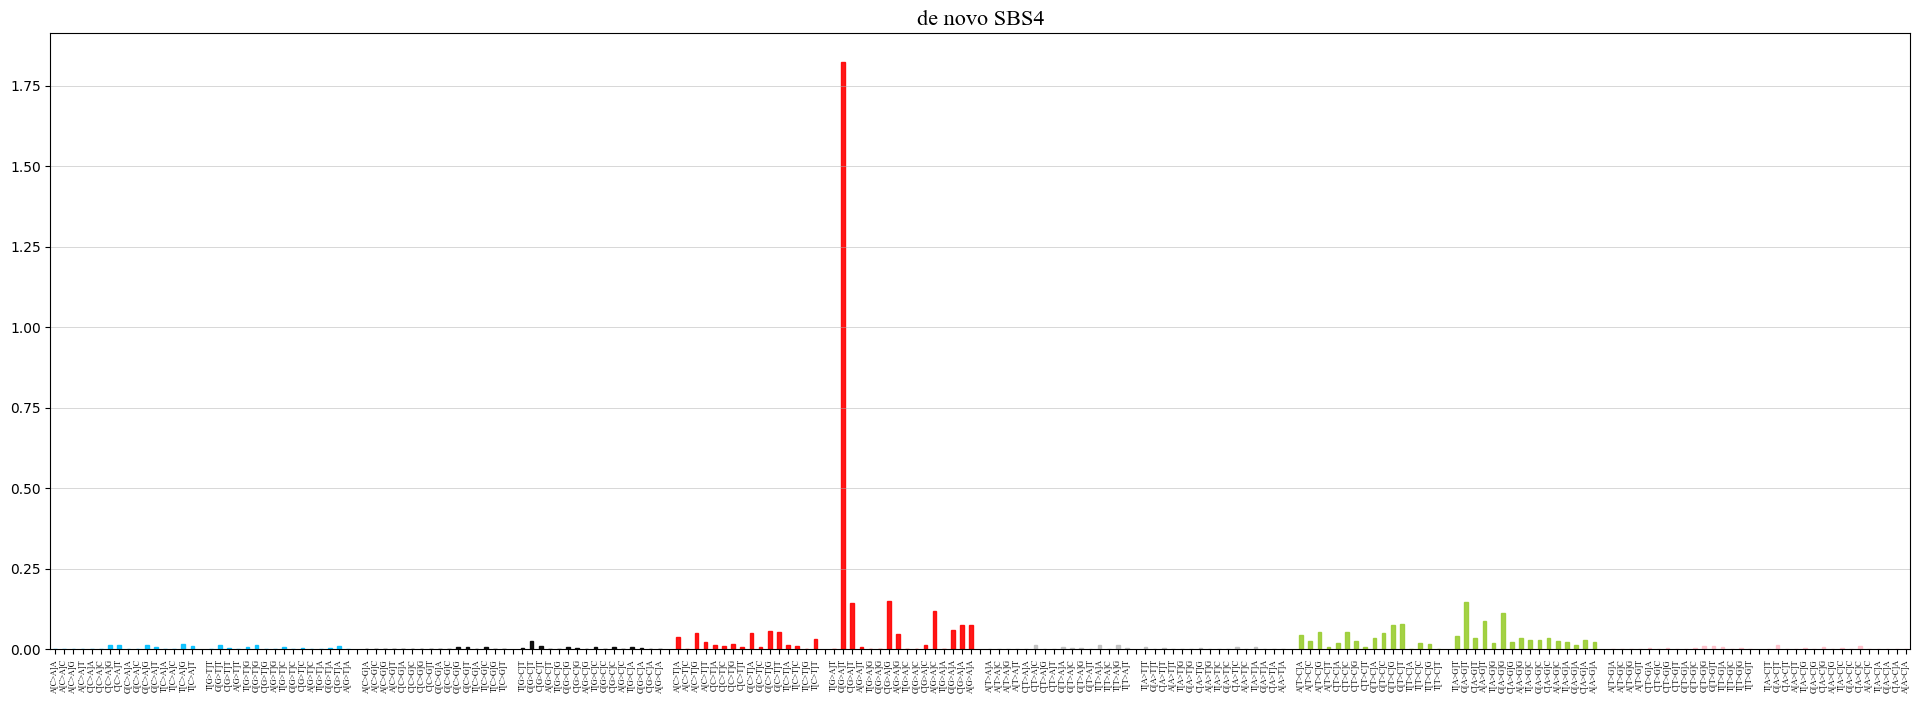

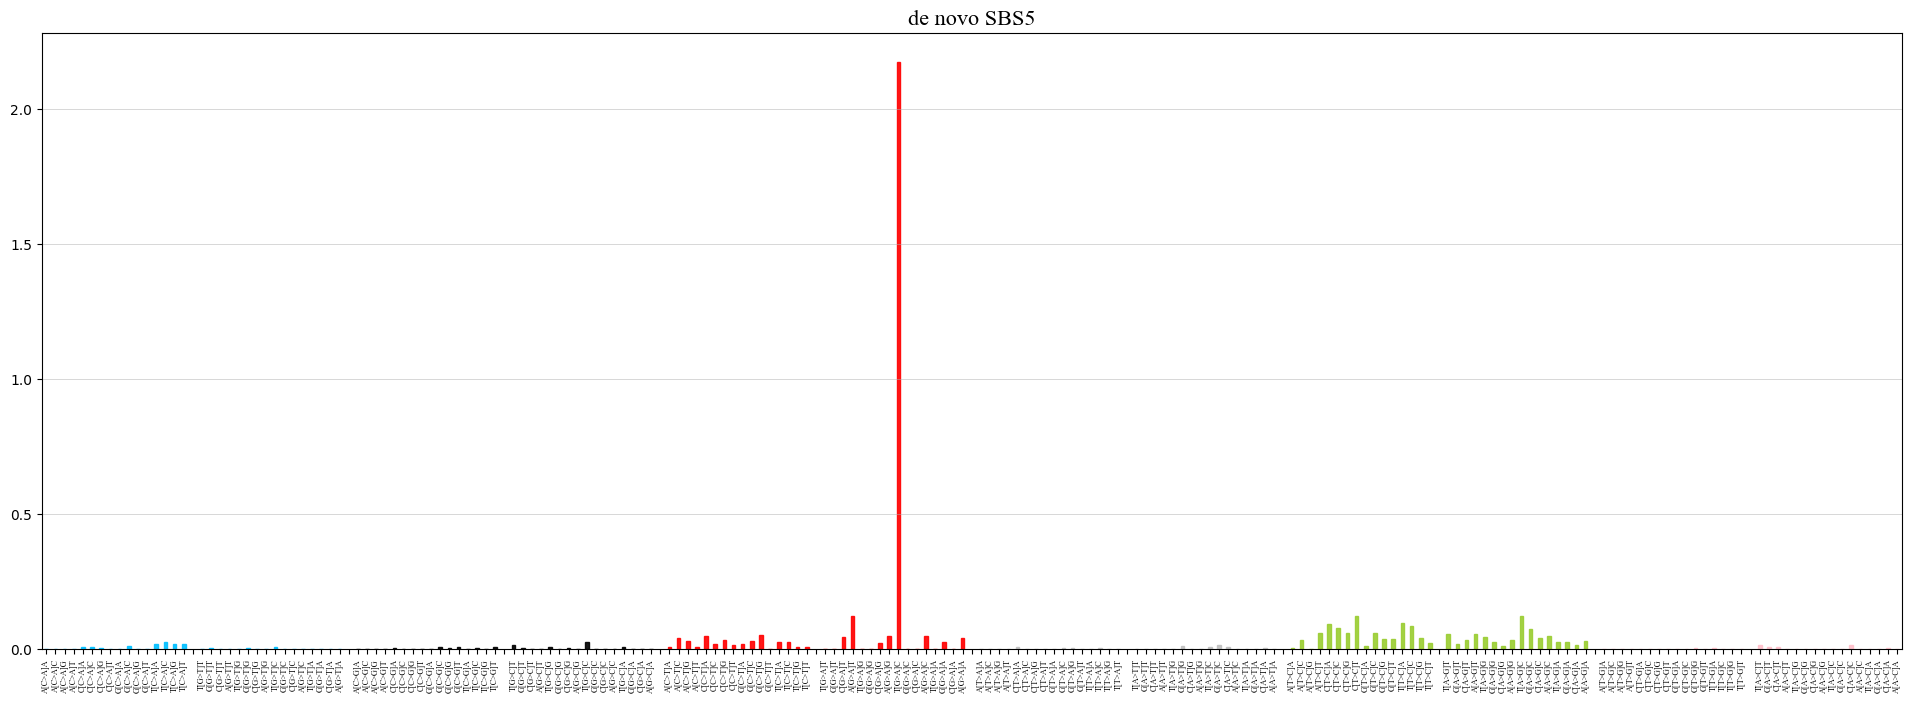

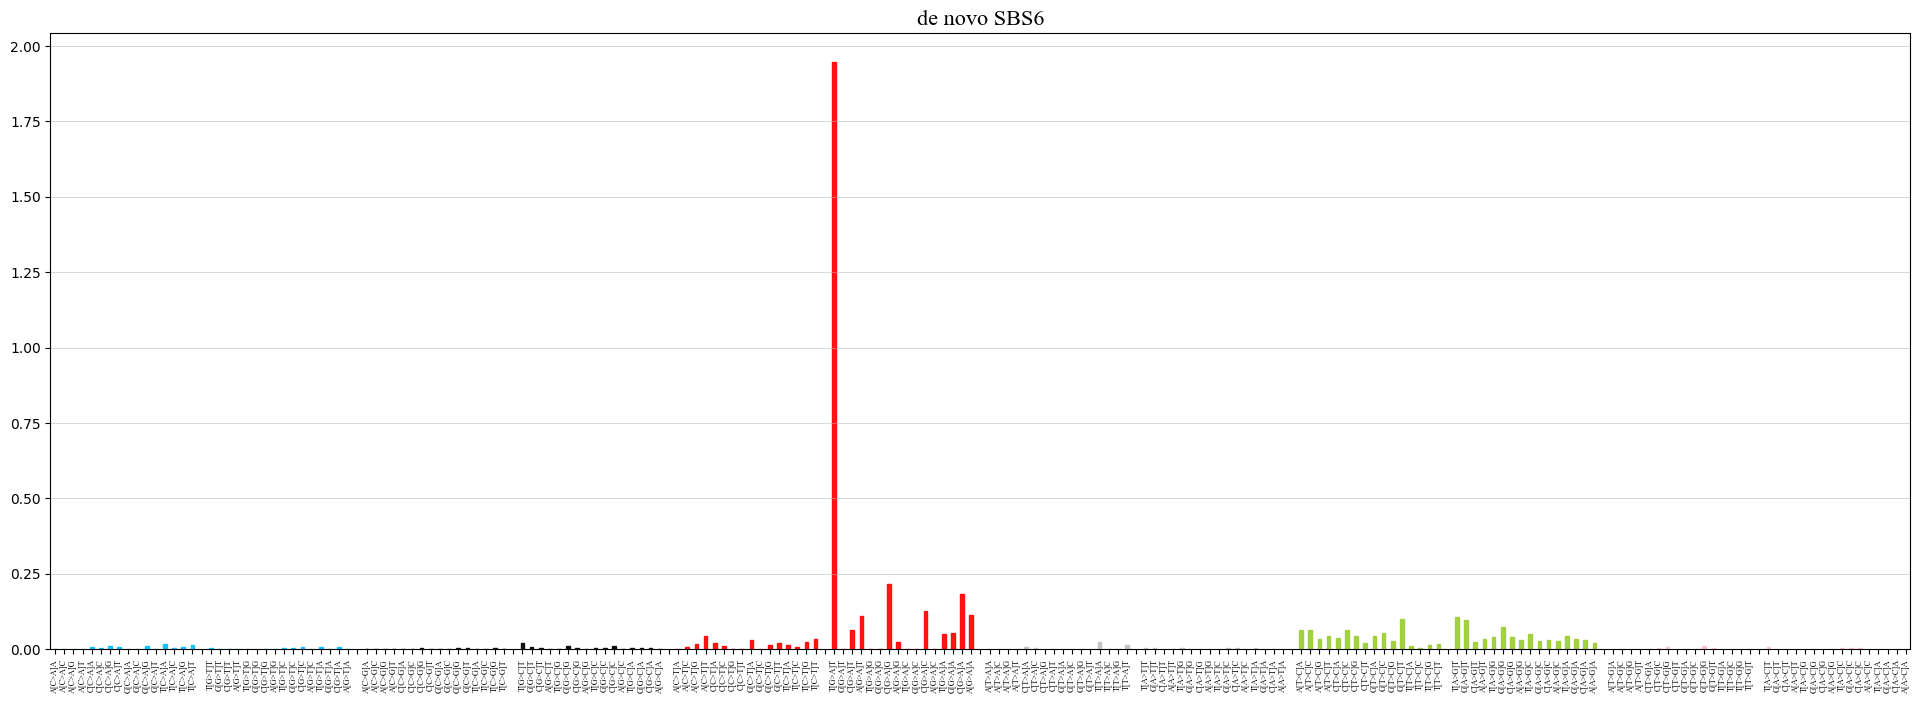

In [56]:
# Example data matrix X (replace this with your actual data)
X = sp192.copy()

# Split the data into training and test sets
X_train, X_test = train_test_split(X, test_size=0.2, random_state=42)

# Range of component numbers to try
component_range = range(1, 7)

# Test NMF with different numbers of components
for n_components in component_range:
    # Create and fit the NMF model to the training data
    model = NMF(n_components=n_components, random_state=42, max_iter=500)
    W = model.fit_transform(X_train)
    H = model.components_
    
    # Reconstruct the test data
    X_reconstructed = np.dot(W, H)
    rec_df_train = pd.DataFrame(X_reconstructed, index=X_train.index, columns=X_train.columns)
    
    X_reconstructed_test = model.inverse_transform(model.transform(X_test))
    rec_df_test = pd.DataFrame(X_reconstructed_test, index=X_test.index, columns=X_test.columns)

    # Calculate the reconstruction error on the test data
    cossims_train = get_cossim(X_train, rec_df_train)
    cossims_test = get_cossim(X_test, rec_df_test)

    print(f"ncomp = {n_components}, train cossim = {cossims_train.mean():.2f}, test cossim = {cossims_test.mean():.2f}")

    signatures = pd.DataFrame(H, columns=X_train.columns)
    for i in signatures.index:
        sign = signatures.loc[i].rename('MutSpec').reset_index()
        plot_mutspec192(sign, title=f'de novo SBS{i+1}');

## legacy DI: compare barplots

In [ ]:
exp_filtered = pd.read_csv('../data/chordata2/exp_num192_cytb.csv')
exp_filtered = exp_filtered.rename(columns={'index':'Species'})
exp_filtered['Species'] = exp_filtered['Species'].str.slice(6)
exp_filtered.head()

,Species,A[A>C]A,A[A>C]C,A[A>C]G,A[A>C]T,C[A>C]A,C[A>C]C,C[A>C]G,C[A>C]T,G[A>C]A,...,C[T>G]G,C[T>G]T,G[T>G]A,G[T>G]C,G[T>G]G,G[T>G]T,T[T>G]A,T[T>G]C,T[T>G]G,T[T>G]T
0,Aulacorhynchus_haematopygus,0.0,0.0,0.0,0.0,8.300000,4.300000,8.500000,8.600000,2.800000,...,3.000000,0.000000,0.000000,0.900000,1.800000,1.000000,1.000000,1.500000,1.400000,1.800000
1,Tarsius_dentatus,0.0,0.0,0.0,0.0,11.571429,10.380952,10.142857,13.000000,3.857143,...,8.333333,4.142857,1.000000,0.285714,1.190476,1.428571,3.047619,2.857143,2.142857,0.428571
2,Xanthonycticebus_pygmaeus,0.0,0.0,0.0,0.0,7.529412,8.647059,13.529412,14.470588,2.588235,...,4.588235,3.823529,0.000000,0.941176,0.941176,1.000000,2.941176,1.058824,2.058824,2.882353
3,Pedioplanis_inornata,0.0,0.0,0.0,0.0,10.714286,4.000000,9.357143,7.928571,2.000000,...,0.928571,1.690476,0.738095,0.476190,3.571429,0.261905,1.857143,2.547619,1.190476,3.500000
4,Oligoryzomys_fulvescens,0.0,0.0,0.0,0.0,14.750000,8.000000,15.166667,11.916667,4.583333,...,1.666667,2.666667,0.333333,0.666667,1.166667,0.916667,3.666667,5.416667,1.583333,2.583333


In [ ]:
exp_true_form = exp_filtered.melt(id_vars=['Species'], value_vars=possible_sbs192)
exp_true_form = exp_true_form.rename(columns={'variable': 'Mut', 'value' : 'ExpectedNum'})
exp_true_form.head()

,Species,Mut,ExpectedNum
0,Aulacorhynchus_haematopygus,A[A>C]A,0.0
1,Tarsius_dentatus,A[A>C]A,0.0
2,Xanthonycticebus_pygmaeus,A[A>C]A,0.0
3,Pedioplanis_inornata,A[A>C]A,0.0
4,Oligoryzomys_fulvescens,A[A>C]A,0.0


In [ ]:
path_to_observed_192 = glob.glob('/home/kpotoh/nemu-pipeline/data/chordata2/output/Cytb/*/tables/ms192syn.tsv')
d = []
for obs_spec in path_to_observed_192:
    mutspec_sps = pd.read_csv(obs_spec, sep='\t')
    mutspec_sps['Species'] = obs_spec.split('/')[8].split('__')[1]
    d.append(mutspec_sps)

full_obs = pd.concat(d, ignore_index=True)

In [ ]:
# Merge it 
final_mutspec = full_obs.merge(exp_true_form, how='inner', on=['Species', 'Mut'])
final_mutspec.head()

,Mut,ObsNum,ExpNum,MutSpec,Species,ExpectedNum
0,A[A>G]C,0.95618,2.995130,0.019676,Aulacorhynchus_haematopygus,6.3
1,A[C>T]A,0.99706,4.777330,0.012863,Aulacorhynchus_haematopygus,10.9
2,A[C>T]G,0.99898,3.111040,0.019791,Aulacorhynchus_haematopygus,5.8
3,A[T>C]A,0.99983,0.222221,0.277305,Aulacorhynchus_haematopygus,1.2
4,A[T>C]C,0.99879,0.555528,0.110812,Aulacorhynchus_haematopygus,0.5


In [ ]:
# Filter those who has more then 0.99 in both Exp and Obs num put 0 instead
final_mutspec['ExpectedNum'] = np.where(final_mutspec.ExpectedNum < 0.99, 0, final_mutspec['ExpectedNum'])
final_mutspec['ObsNum'] = np.where(final_mutspec.ObsNum < 0.99, 0, final_mutspec['ObsNum'])

In [33]:
# Calcualte MutSpec
final_mutspec["RawMutSpec"] = (final_mutspec["ObsNum"] / final_mutspec["ExpectedNum"]).fillna(0)
final_mutspec["RawMutSpec"] = final_mutspec["RawMutSpec"].replace(np.inf, 0)
rawsum_df = final_mutspec.groupby("Species").RawMutSpec.sum().reset_index().rename(columns={"RawMutSpec": "RawMutSpecSum"})
final_mutspec = pd.merge(final_mutspec, rawsum_df, on="Species")
final_mutspec["MutSpec"] = final_mutspec["RawMutSpec"] / final_mutspec["RawMutSpecSum"]
final_mutspec.head()

,Mut,ObsNum,ExpNum,MutSpec,Species,ExpectedNum,RawMutSpec,RawMutSpecSum
0,A[A>G]C,0.00000,2.995130,0.000000,Aulacorhynchus_haematopygus,6.3,0.000000,8.027693
1,A[C>T]A,0.99706,4.777330,0.011395,Aulacorhynchus_haematopygus,10.9,0.091473,8.027693
2,A[C>T]G,0.99898,3.111040,0.021455,Aulacorhynchus_haematopygus,5.8,0.172238,8.027693
3,A[T>C]A,0.99983,0.222221,0.103790,Aulacorhynchus_haematopygus,1.2,0.833192,8.027693
4,A[T>C]C,0.99879,0.555528,0.000000,Aulacorhynchus_haematopygus,0.0,0.000000,8.027693


In [34]:
def getrevers(mut):
    translator = str.maketrans("ACGT", "TGCA")
    new_mut = mut[-1] + mut[1:-1] + mut[0]
    new_mut = new_mut.translate(translator)
    return new_mut

In [35]:
# A bit annotate
final_mutspec['Mut'] = final_mutspec.Mut.apply(getrevers) # translation on heavy chain
final_mutspec["MutBase"] = final_mutspec.Mut.str.slice(2, 5)
final_mutspec["Context"] = final_mutspec.Mut.str.get(0) + final_mutspec.Mut.str.get(2) + final_mutspec.Mut.str.get(-1)

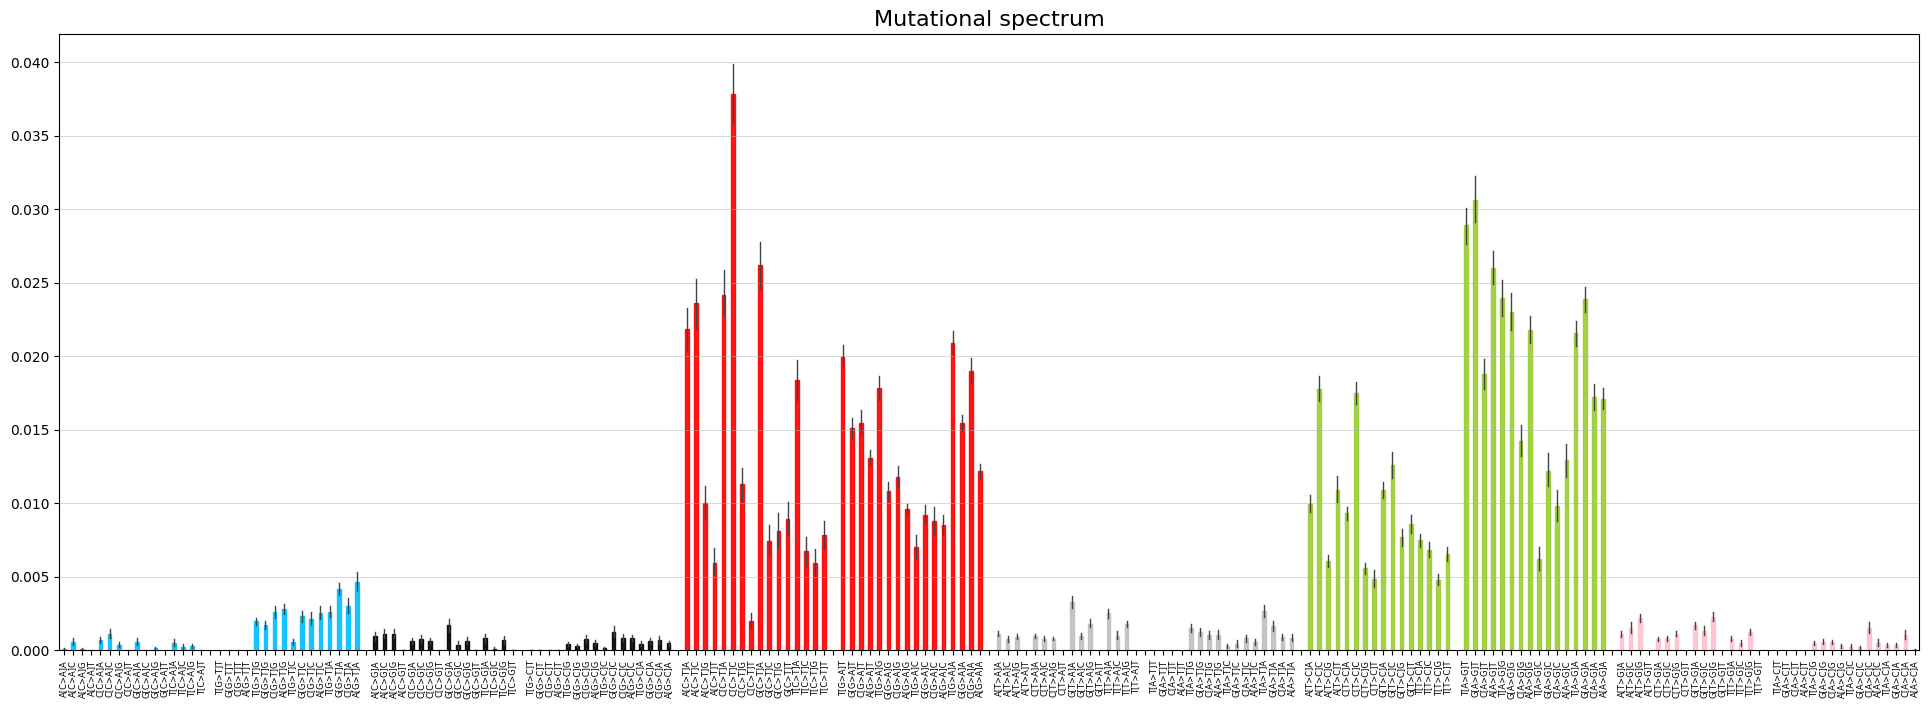

<AxesSubplot:title={'center':'Mutational spectrum'}>

In [36]:
plot_mutspec192(final_mutspec);

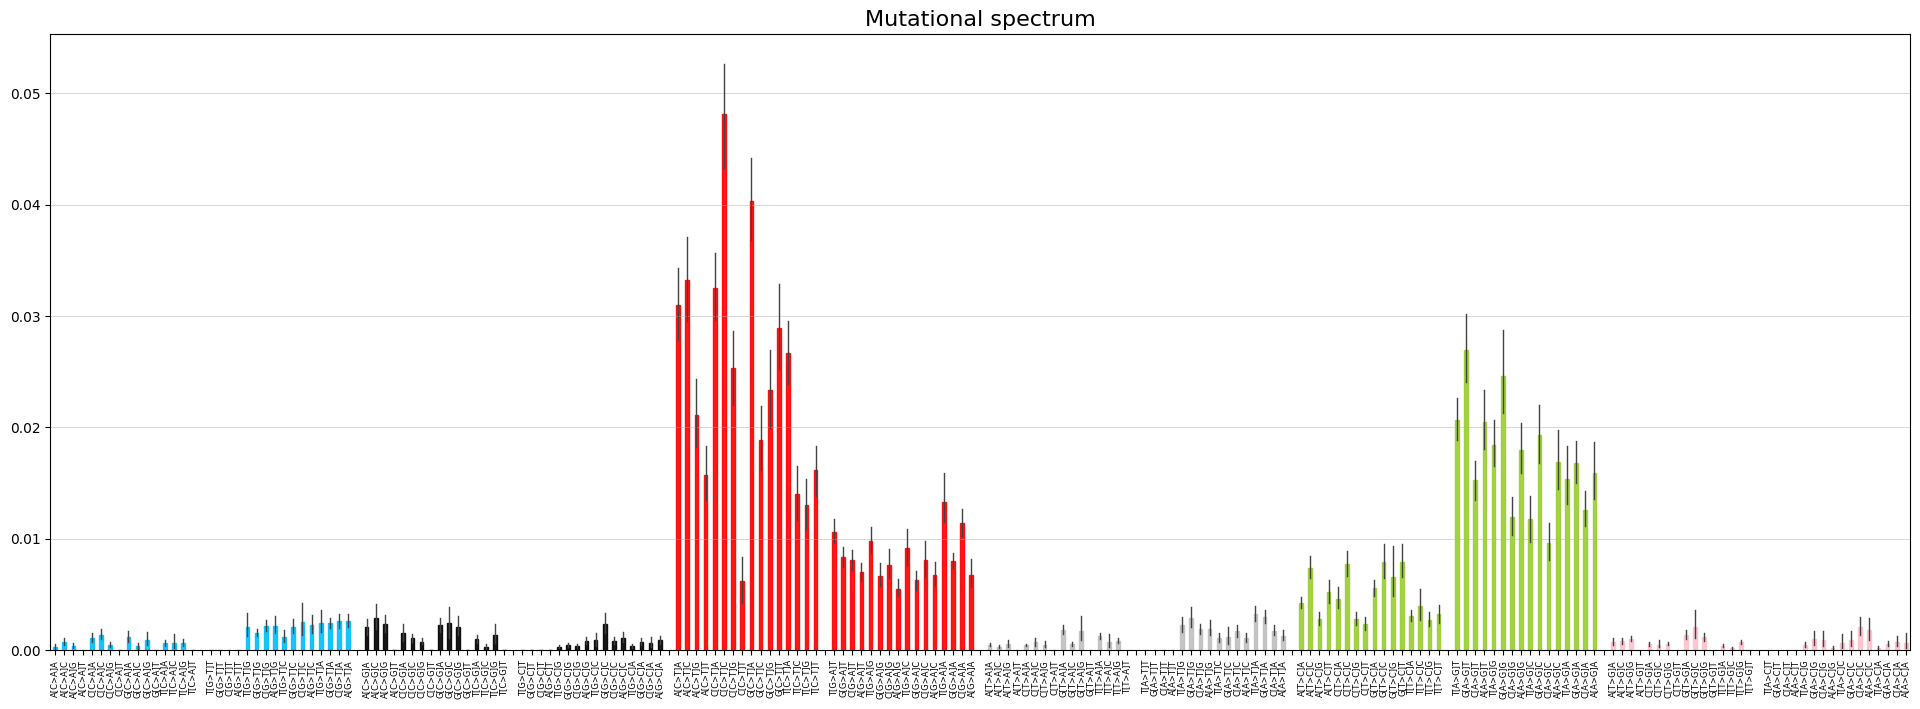

In [37]:
plot_mutspec192(old_dataset);

In [18]:
old_dataset = pd.read_csv('/home/kpotoh/192/data/MutSpecVertebratescytb.csv')
old_dataset.head()

,Species,Mut,Expected,Observed,RawMutSpec,RawMutSpecSum,MutSpec,MutBase,Context,Class
0,Abbottina_obtusirostris,T[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,TTT,Actinopterygii
1,Abbottina_obtusirostris,G[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,GTT,Actinopterygii
2,Abbottina_obtusirostris,C[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,CTT,Actinopterygii
3,Abbottina_obtusirostris,A[T>G]T,0.0,0.0,0.0,1.088889,0.0,T>G,ATT,Actinopterygii
4,Abbottina_obtusirostris,T[T>C]T,8.0,0.0,0.0,1.088889,0.0,T>C,TTT,Actinopterygii


In [35]:
def calc_mutspec_class(df: pd.DataFrame):
    ms_cls = df.groupby(['Class','Mut'])['RawMutSpec'].sum().reset_index()
    ms_cls["RawMutSpecSum"] = ms_cls.Class.map(ms_cls.groupby("Class").RawMutSpec.sum().to_dict())
    ms_cls['MutSpec'] = ms_cls.RawMutSpec / ms_cls.RawMutSpecSum
    ms_cls = ms_cls.drop(['RawMutSpec', 'RawMutSpecSum'], axis=1)
    
    return ms_cls

In [43]:
mut_new = final_mutspec.loc[final_mutspec['Species'].isin(old_dataset['Species'].unique())]
mut_old = old_dataset.loc[old_dataset['Species'].isin(mut_new['Species'].unique())]

In [44]:
sps_to_cosin = mut_new.Species.unique()

In [45]:
mut_new['Class'] = 'Vertebrata'
mut_new = calc_mutspec_class(mut_new)
mut_old['Class'] = 'Vertebrata'
mut_old = calc_mutspec_class(mut_old)

In [39]:
1 - spatial.distance.cosine(mut_new['MutSpec'], mut_old['MutSpec'])

0.9248450130741519

In [40]:
mutspec_bogdan = pd.read_csv('/home/kpotoh/nemu-pipeline/data/chordata2/raw_spectum192.csv')

mutspec_bogdan = mutspec_bogdan.drop('Unnamed: 0', axis=1)

mutspec_bogdan = mutspec_bogdan[mutspec_bogdan.Gene == 'Cytb']

mutspec_bogdan['ExpNum'] = np.where(mutspec_bogdan['ExpNum'] < 0.99, 0, mutspec_bogdan['ExpNum'])
mutspec_bogdan['ObsNum'] = np.where(mutspec_bogdan['ObsNum'] < 0.99, 0, mutspec_bogdan['ObsNum'])

### Norm again
mutspec_bogdan["RawMutSpec"] = (mutspec_bogdan["ObsNum"] / mutspec_bogdan["ExpNum"]).fillna(0)
mutspec_bogdan["RawMutSpec"] = mutspec_bogdan["RawMutSpec"].replace(np.inf, 0)
rawsum_df = mutspec_bogdan.groupby("Species").RawMutSpec.sum().reset_index().rename(columns={"RawMutSpec": "RawMutSpecSum"})
mutspec_bogdan = pd.merge(mutspec_bogdan, rawsum_df, on="Species")
mutspec_bogdan["MutSpec"] = mutspec_bogdan["RawMutSpec"] / mutspec_bogdan["RawMutSpecSum"]


In [41]:
mutspec_bogdan['Mut'] = mutspec_bogdan.Mut.apply(getrevers) # change annotation to heavy STRAND
mutspec_bogdan["MutBase"] = mutspec_bogdan.Mut.str.slice(2, 5)
mutspec_bogdan["Context"] = mutspec_bogdan.Mut.str.get(0) + mutspec_bogdan.Mut.str.get(2) + mutspec_bogdan.Mut.str.get(-1)


In [46]:
mutspec_bogdan['Class'] = 'Vertebrata'

In [50]:
mut_bog = mutspec_bogdan.loc[mutspec_bogdan['Species'].isin(sps_to_cosin)]
mut_bog = calc_mutspec_class(mut_bog)

In [51]:
1 - spatial.distance.cosine(mut_new['MutSpec'], mut_bog['MutSpec'])

0.965254957470618

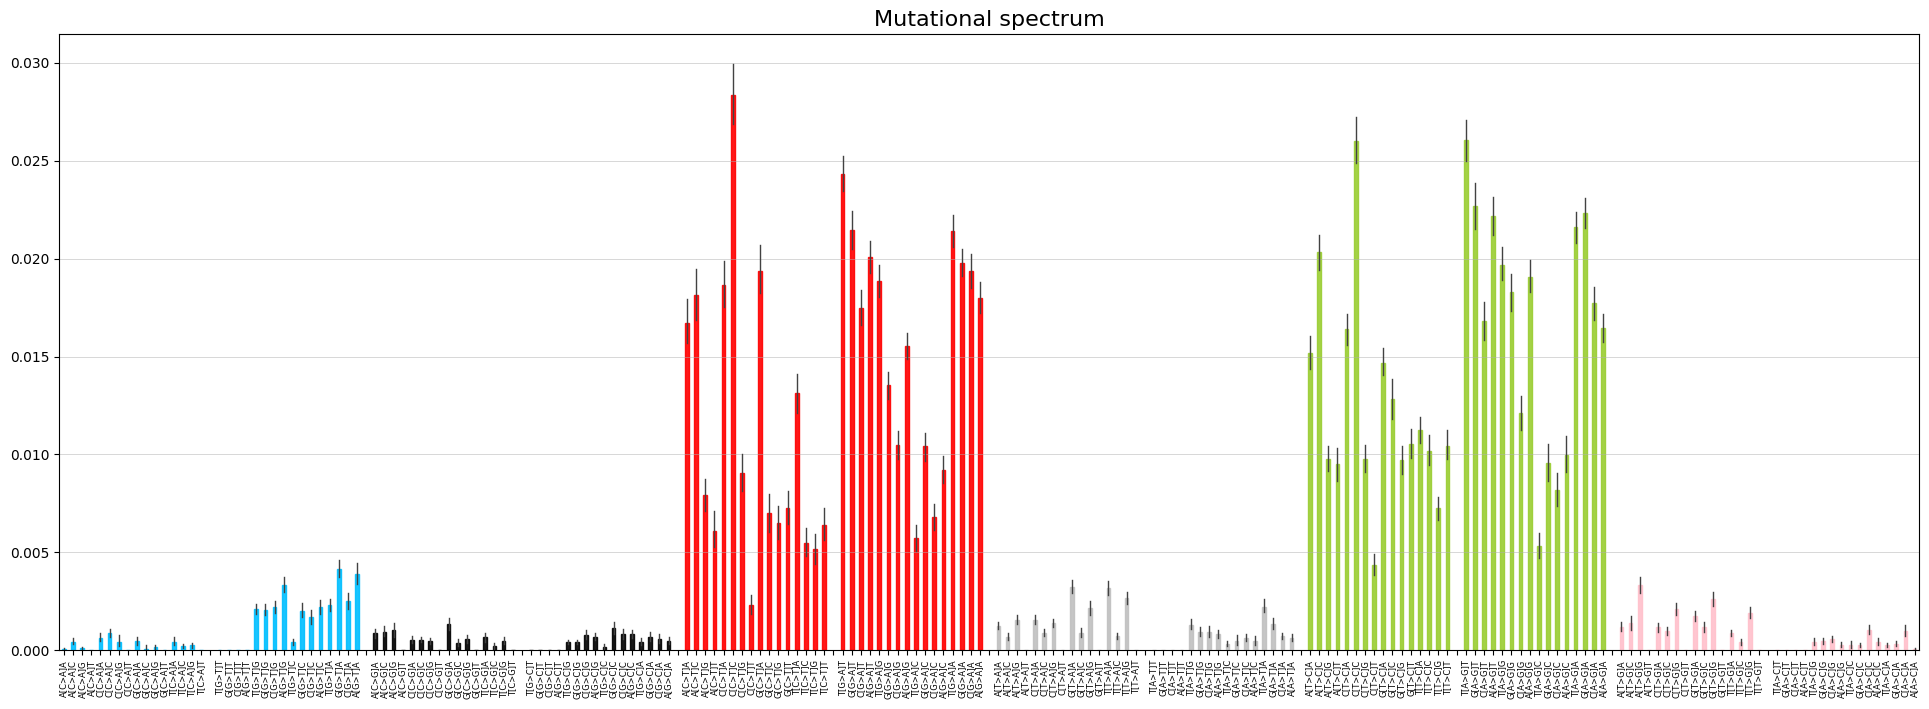

<AxesSubplot:title={'center':'Mutational spectrum'}>

In [33]:
plot_mutspec192(mutspec_bogdan)